## load libraries

In [1]:
import sys, os, subprocess
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pysam
from Bio import SeqIO
import logomaker as lm
from scipy import stats

%config Completer.use_jedi = False

Also load my custom repos

In [2]:
sys.path.append(os.path.relpath('/home/pculviner/Dropbox (MIT)/repositories/genomearray3/'))
import genomearray3 as ga
sys.path.append(os.path.relpath('/home/pculviner/Dropbox (MIT)/repositories/genomewindow/'))
import genomewindow as gw

In [3]:
from scipy.signal import convolve
from scipy.stats import gmean

def quickshell(command, print_output=True, output_path=None, return_output=False):
    process_output = subprocess.run(command, shell = True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    stdout = process_output.stdout.decode('utf-8')
    stderr = process_output.stderr.decode('utf-8')
    output_string = 'STDOUT:\n%s\nSTDERR:\n%s\n'%(stdout,stderr)
    if print_output:
        print('$ %s'%command)
        print(output_string)
    if output_path is not None:
        with open(output_path,'w') as f:
            f.write(output_string)
    if return_output:
        return stdout, stderr
    
# code to load arrays by strings inside a target folder
def loadarrays(target_folder, control_has = [], control_not = [], experimental_has = [], experimental_not = [], verbose = True):
    # find numpy files in the target folder
    stdout, _ = quickshell('ls %s*.npy'%target_folder, print_output=False, return_output=True)
    all_numpy_files = stdout.split('\n')[:-1]
    # output files
    control_arrays = []
    experimental_arrays = []
    # identify numpy files matching experimental and control strings
    for file_path in all_numpy_files:
        file_name = file_path.split('/')[-1]
        if all([s.lower() in file_name.lower() for s in control_has]) and all([s.lower() not in file_name.lower() for s in control_not]):
            control_arrays.append(np.load(file_path))
            if verbose:
                print('control: %s'%file_name)
        if all([s.lower() in file_name.lower() for s in experimental_has]) and all([s.lower() not in file_name.lower() for s in experimental_not]):
            experimental_arrays.append(np.load(file_path))
            if verbose:
                print('experimental: %s'%file_name)
    return control_arrays, experimental_arrays

def maskedcountnormalization(sample_arrays, mask, pseudo = True):
    sample_arrays = np.array(sample_arrays) # change to array or copy array to prevent overwrite
    # apply mask
    sample_arrays[:,mask] = 0
    # calculate size factors from raw reads mapped to bam files
    counts = []
    counts = np.nansum(sample_arrays,axis=(1,2))
    size_factors = counts / gmean(counts)
    # now normalize the arrays
    normalized_sample_arrays = (sample_arrays + int(pseudo)) / size_factors.reshape(*np.r_[-1,np.ones(len(sample_arrays.shape)-1).astype(int)])
    return normalized_sample_arrays

def convolvepwm(pwm, onehot_region):
    score_fwd = np.reshape(convolve(np.flip(np.flip(pwm,0),1),onehot_region[0],mode='valid'),-1)
    score_fwd = np.r_[score_fwd, np.zeros(onehot_region.shape[1] - score_fwd.shape[0]).astype(int)]
    score_rev = np.reshape(convolve(np.flip(np.flip(pwm,0),1),np.flip(onehot_region[1],0),mode='valid'),-1)
    score_rev = np.flip(np.r_[score_rev, np.zeros(onehot_region.shape[1] - score_rev.shape[0])],0)
    out = np.asarray([score_fwd, score_rev])
    return out

def makemotifmask(motif, onehot_genome):
    sites = np.asarray(np.where(convolvepwm(ga.dnatoonehot(motif),onehot_genome) == len(motif))).T
    # get first strand regions
    first_strand = sites[sites[:,0]==0]
    first_strand_regions = np.c_[first_strand,np.reshape(first_strand[:,1] + 2,(-1,1))]
    # get second strand regions
    second_strand = sites[sites[:,0]==1]
    second_strand_regions = np.c_[second_strand[:,0].reshape((-1,1)), np.reshape(second_strand[:,1]-len(motif)+1,(-1,1)), second_strand[:,1].reshape((-1,1))]
    # get region mask
    motif_mask = ga.regionstomask(np.r_[first_strand_regions, second_strand_regions], onehot_genome.shape[1])
    return motif_mask

def getmotiflocations(motif, onehot_genome):
    sites = np.asarray(np.where(convolvepwm(ga.dnatoonehot(motif),onehot_genome) == len(motif))).T
    single_nt_regions = np.c_[sites[:],sites[:,1]]
    motif_mask = ga.regionstomask(single_nt_regions, onehot_genome.shape[1])
    return motif_mask

def getmotifsites(motif, onehot_genome):
    sites = np.asarray(np.where(convolvepwm(ga.dnatoonehot(motif),onehot_genome) == len(motif))).T
    return sites

In [4]:
# set figure output sizes for easy viewing
params = {'axes.titlesize':11,
          'xtick.labelsize':7,
          'ytick.labelsize':7,
          'axes.labelsize': 8}
plt.rcParams.update(params)
plt.rcParams['figure.dpi'] = 300
plt.rcParams['pdf.fonttype'] = 42
sns.set_style(style='ticks',
              rc={'text.color':'k',
                  'xtick.color':'k',
                  'ytick.color':'k',
                  'axes.edgecolor':'k',
                  'axes.labelcolor':'k',
                  "text.usetex": False,
                  'mathtext.fontset':'Arial'})

import warnings
# filter matplotlib warnings because they're annoying
warnings.filterwarnings( "ignore", module = "genomewindow*" )

# Figure 1 (+ parts S1)

## Fig 1A: MazF growth preview

In [5]:
# load in dataframe of real data
growth_data = pd.read_csv('sucrose_gradients/190607_toxins_growth.csv',index_col=0)

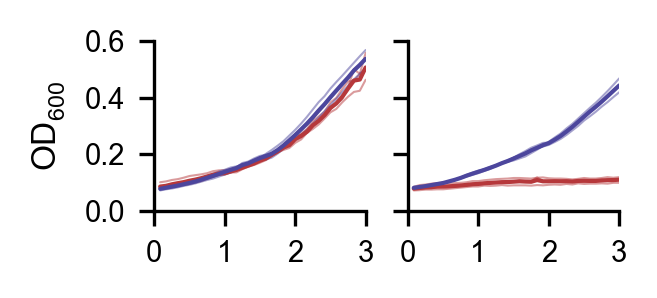

In [6]:
def plt_rescuecurve(ax, expr_name, dataframe, time_range=None, toxic_flag='tx', rescue_flag='rs'):
    # define x and y indexes of data to be plotted
    sel_col = dataframe.columns.str.contains(expr_name)
    tx_col = dataframe.columns.str.contains(toxic_flag)
    rs_col = dataframe.columns.str.contains(rescue_flag)
    if time_range == None:
        time_range = (dataframe.index[0],dataframe.index[-1])
    sel_row = np.all([np.asarray(dataframe.index) >= time_range[0],
                      np.asarray(dataframe.index) <= time_range[1]],axis=0)
    # actually plot the data
    x_data = dataframe.index[sel_row]
    ara_data = dataframe.loc[sel_row,np.all([sel_col,tx_col],0)]
    ara_atc_data = dataframe.loc[sel_row,np.all([sel_col,rs_col],0)]
    # arabinose plots
    ax.plot(x_data, # x is time
             ara_data, # y is OD600,
             color='#b6383b', lw=.5, alpha=.5)
    ax.plot(x_data, # x is time
             np.mean(ara_data,axis=1), # y is OD600,
             color='#b6383b', lw=1, alpha=1, zorder=10)
    # arabinose + atc plot(s)
    ax.plot(dataframe.index[sel_row], # x is time
             ara_atc_data, # y is OD600,
             color='#4c469d', lw=.5, alpha=.5)
    ax.plot(x_data, # x is time
             np.mean(ara_atc_data,axis=1), # y is OD600,
             color='#4c469d', lw=1, alpha=1, zorder=10)

fig, axes = plt.subplots(1,2,figsize=(2,.75),sharex=True,sharey=True)

ax = axes[0]
plt_rescuecurve(ax, 'empty', growth_data, time_range=(0,180))
ax.set_xlim(0,180)
plt.xticks([0,60,120,180],[0,1,2,3])
ax.set_ylim(0,.6)
plt.yticks([0,.2,.4,.6])
sns.despine()
ax.set_ylabel('$\mathregular{OD_{600}}$')

ax = axes[1]
plt_rescuecurve(ax, 'MazF', growth_data, time_range=(0,180))
ax.set_xlim(0,180)
plt.xticks([0,60,120,180],[0,1,2,3])
ax.set_ylim(0,.6)
sns.despine()

plt.savefig('figure_outputs/1A_mazF_growth.pdf',format='pdf',bbox_inches='tight')

## Fig 1B: toxin doubling times

['ChpB' 'HicA' 'HigB' 'MazF' 'MqsR' 'RelE' 'YafO' 'YhaV' 'YoeB' 'empty']


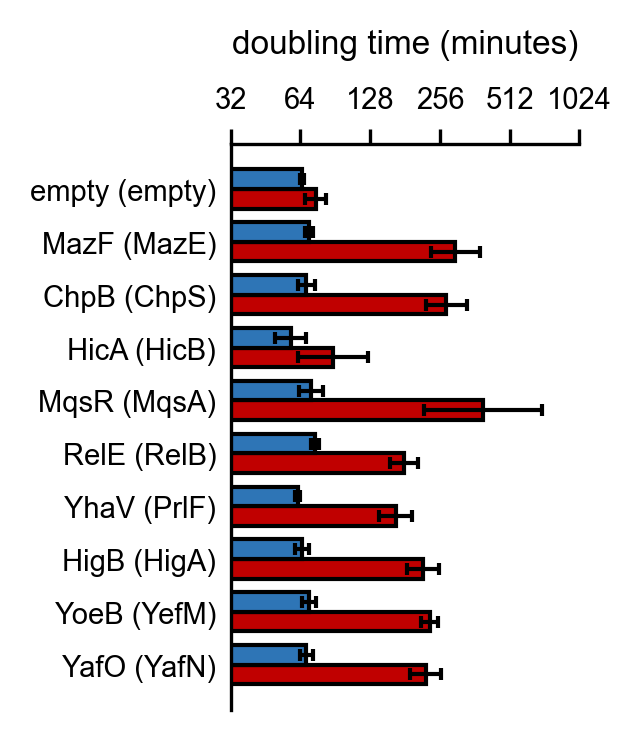

In [7]:
from scipy.stats import linregress

def get_doublings(x,y):
    # calculate doulbing time
    slopes = np.asarray([linregress(x,np.log2(y_col))[0] for y_col in y])
    doubling_time = 1/slopes
    return doubling_time

def plt_doublingtimes(dataframe, time_range=None, figsize=(3,6),
                      toxic_flag='tx', rescue_flag='rs', bar_width=0.37, order=None, actual_labels=None):
    # define x and y indexes of data to be plotted
    condition_names = np.unique([s.split('_')[0] for s in dataframe.columns]) # names of plots will be the string prior to the first '_'
    print(condition_names)
    tx_col = dataframe.columns.str.contains(toxic_flag)
    rs_col = dataframe.columns.str.contains(rescue_flag)
    if time_range == None:
        time_range = (dataframe.index[0],dataframe.index[-1])
    sel_row = np.all([np.asarray(dataframe.index) >= time_range[0],
                      np.asarray(dataframe.index) <= time_range[1]],axis=0)
    # calculate doubling times
    doubling_times = []
    if order is not None:
        condition_names = order
    for cname in condition_names:
        condition_col = dataframe.columns.str.contains(cname)
        doubling_times.append([get_doublings(dataframe.index[sel_row].values,dataframe.loc[sel_row,np.all([condition_col,tx_col],axis=0)].values.T),
                               get_doublings(dataframe.index[sel_row].values,dataframe.loc[sel_row,np.all([condition_col,rs_col],axis=0)].values.T)])
    doubling_times = np.log2(np.asarray(doubling_times))
    fig,ax = plt.subplots(1,1,figsize=figsize)
    bar_pos = -np.arange(len(condition_names))
    ax.barh(bar_pos-bar_width, np.mean(doubling_times[:,0,:],axis=1), bar_width, xerr=np.std(doubling_times[:,0,:],axis=1),
            capsize=1.5,error_kw={'lw':1}, color=(192/255.,0/255.,0/255.), edgecolor='k', linewidth=1,)
    ax.barh(bar_pos, np.mean(doubling_times[:,1,:],axis=1), bar_width, xerr=np.std(doubling_times[:,1,:],axis=1),
            capsize=1.5, error_kw={'lw':1}, color=(46/255.,117/255.,182/255.), edgecolor='k', linewidth=1,)
    plt.yticks(bar_pos-bar_width/2,actual_labels)
    ax.tick_params(axis='y',length=False)
    return ax, doubling_times 
    
condition_order = ['empty', 'MazF', 'ChpB', 'HicA', 'MqsR', 'RelE', 'YhaV', 'HigB', 'YoeB', 'YafO']
actual_labels = ['empty (empty)', 'MazF (MazE)', 'ChpB (ChpS)', 'HicA (HicB)', 'MqsR (MqsA)', 'RelE (RelB)', 'YhaV (PrlF)', 'HigB (HigA)', 'YoeB (YefM)', 'YafO (YafN)']
    
ax, dbl = plt_doublingtimes(growth_data,time_range=(30,120), order=condition_order, actual_labels=actual_labels, figsize=(1.5,2.5))
sns.despine(top=False,bottom=True)
ax.set_xlim(5,10)
ax.xaxis.tick_top()
plt.xticks([5,6,7,8,9,10],2**np.asarray([5,6,7,8,9,10]))
ax.set_xlabel('doubling time (minutes)',labelpad=8)

ax.xaxis.set_label_position('top')
plt.savefig('figure_outputs/1B_toxin_doublings.pdf',format='pdf',bbox_inches='tight')

## Fig S1A: YafQ and RnlA were not included

In [8]:
# load in dataframe of real data
growth_data_rnla_yafq = pd.read_csv('sucrose_gradients/early_growth_data_for_rnlA_yafQ.csv',index_col=0)

['RnlA' 'YafQ' 'empty']


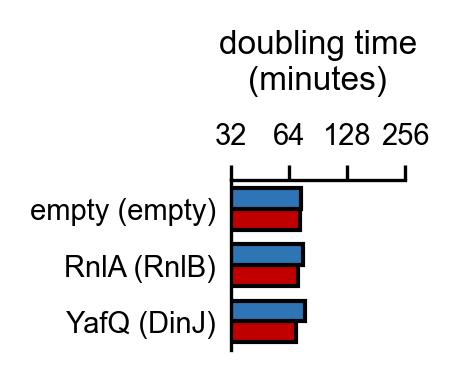

In [9]:
from scipy.stats import linregress

def get_doublings(x,y):
    # calculate doulbing time
    slopes = np.asarray([linregress(x,np.log2(y_col))[0] for y_col in y])
    doubling_time = 1/slopes
    return doubling_time

def plt_doublingtimes(dataframe, time_range=None, figsize=(3,6),
                      toxic_flag='tx', rescue_flag='rs', bar_width=0.37, order=None, actual_labels=None):
    # define x and y indexes of data to be plotted
    condition_names = np.unique([s.split('_')[0] for s in dataframe.columns]) # names of plots will be the string prior to the first '_'
    print(condition_names)
    tx_col = dataframe.columns.str.contains(toxic_flag)
    rs_col = dataframe.columns.str.contains(rescue_flag)
    if time_range == None:
        time_range = (dataframe.index[0],dataframe.index[-1])
    sel_row = np.all([np.asarray(dataframe.index) >= time_range[0],
                      np.asarray(dataframe.index) <= time_range[1]],axis=0)
    # calculate doubling times
    doubling_times = []
    if order is not None:
        condition_names = order
    for cname in condition_names:
        condition_col = dataframe.columns.str.contains(cname)
        doubling_times.append([get_doublings(dataframe.index[sel_row].values,dataframe.loc[sel_row,np.all([condition_col,tx_col],axis=0)].values.T),
                               get_doublings(dataframe.index[sel_row].values,dataframe.loc[sel_row,np.all([condition_col,rs_col],axis=0)].values.T)])
    doubling_times = np.log2(np.asarray(doubling_times))
    fig,ax = plt.subplots(1,1,figsize=figsize)
    bar_pos = -np.arange(len(condition_names))
    ax.barh(bar_pos-bar_width, np.mean(doubling_times[:,0,:],axis=1), bar_width, color=(192/255.,0/255.,0/255.), edgecolor='k', linewidth=1,)
    ax.barh(bar_pos, np.mean(doubling_times[:,1,:],axis=1), bar_width, color=(46/255.,117/255.,182/255.), edgecolor='k', linewidth=1,)
    plt.yticks(bar_pos-bar_width/2, actual_labels)
    ax.tick_params(axis='y',length=False)
    return ax
    
condition_order = ['empty', 'RnlA', 'YafQ']
actual_labels = ['empty (empty)', 'RnlA (RnlB)', 'YafQ (DinJ)']
    
ax = plt_doublingtimes(growth_data_rnla_yafq,time_range=(90,180), order=condition_order, actual_labels=actual_labels, figsize=(.75,.75))
sns.despine(top=False,bottom=True)
ax.set_xlim(5,8)
ax.xaxis.tick_top()
plt.xticks([5,6,7,8,],2**np.asarray([5,6,7,8]))
ax.set_xlabel('doubling time\n(minutes)',labelpad=8)
ax.xaxis.set_label_position('top')
plt.savefig('figure_outputs/S1A_toxin_doublings.pdf',format='pdf',bbox_inches='tight')

## Fig 1C: show _atpI-C_ operon for select toxins in ligation libraries

In [10]:
# load the mg1655 genome
genbank_path = '/home/pculviner/notebook/genomes/mg1655_v3/Ec_mg1655v3.gb'
loaded_genbank = SeqIO.read(genbank_path,'genbank')
# load a gene table csv from the provided path
gene_table_path = '/home/pculviner/notebook/genomes/mg1655_v3/gt_mg1655_v3.csv'
gene_table = pd.read_csv(gene_table_path, index_col=0)

window zero at 3922439, window is not reversed: False


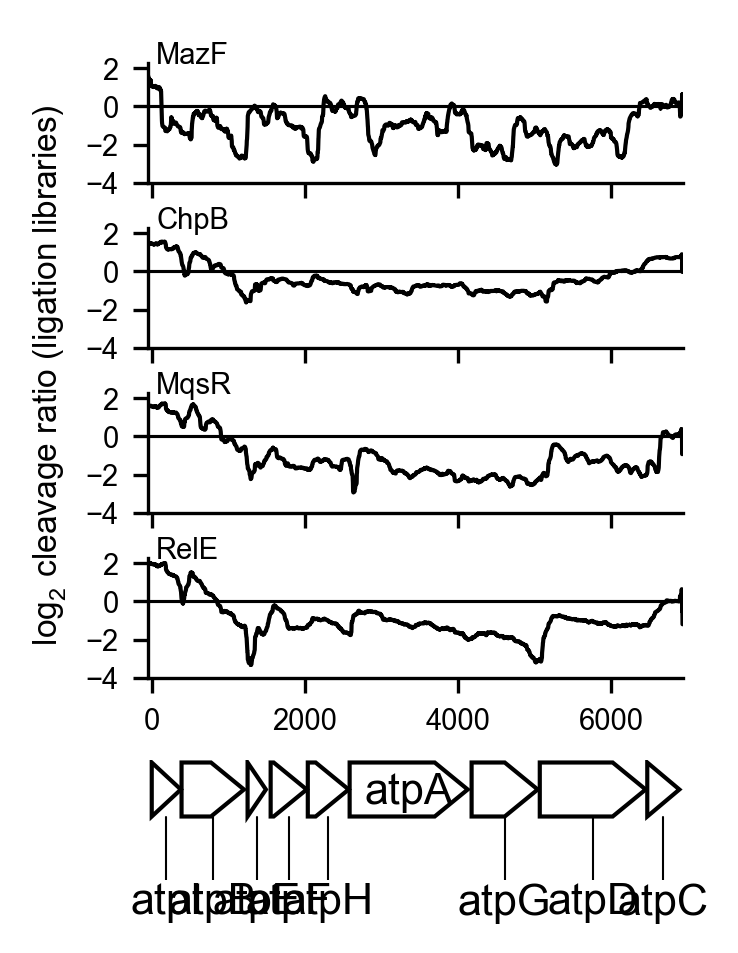

In [11]:
toxins = ['MazF', 'ChpB', 'MqsR', 'RelE']

window = gw.GenomeWindow(gene_table = gene_table, genome = loaded_genbank, gene_name_column='plt_tag',
                         axes_heights = [.4 for i in range(len(toxins))] + [.1,.4], fig_width=2.3, show_poi=True,)

window.setpositionbygene(name='atpI', nt_5=50, nt_3=6550)

cleavage_ratio_arrays = []
for tox in toxins:
    # size of mask around rRNA regions for count normalization
    rrna_margin = 100
    ### LOAD & NORMALIZE CLEAVAGE RATIO DATA
    if tox != 'MazF':
        # load arrays for peaks
        ctl_arrays, exp_arrays = loadarrays('/home/pculviner/notebook/storage/rnaseq/old_data/all_toxin_dutp/dutp_pipeline/density_numpy_all/',
                                            control_has = ['ev'],
                                            control_not = [],
                                            experimental_has = [tox],
                                            experimental_not = [], verbose = False)
    else:
        # load arrays for peaks
        ctl_arrays, exp_arrays = loadarrays('/home/pculviner/notebook/storage/rnaseq/old_data/mazf_dutp/dutp_pipeline/density_numpy_all/',
                                            control_has = ['ev'],
                                            control_not = [],
                                            experimental_has = [tox],
                                            experimental_not = [], verbose = False)
    # generate the rrna mask - these regions will not be included in the calculation of size factors for count normalization
    rrna_regions = gene_table.loc[gene_table.locus_type == 'rRNA',['strand', 'start', 'end']].values.astype(int)
    rrna_regions[:,1] = rrna_regions[:,1] - rrna_margin
    rrna_regions[:,2] = rrna_regions[:,2] + rrna_margin
    rrna_mask = ga.regionstomask(rrna_regions, len(loaded_genbank))
    # normalize the arrays by counts in the non-masked regions 
    normalized_arrays = maskedcountnormalization(np.r_[ctl_arrays,exp_arrays], rrna_mask, pseudo = True)
    # split the arrays back into control and experimental
    ctl_means = np.mean(np.log2(normalized_arrays[:len(ctl_arrays)]),axis=0)
    exp_means = np.mean(np.log2(normalized_arrays[len(ctl_arrays):]),axis=0)
    # calculate a mean ratio across both data sets - convert back into linear space for lulz
    cleavage_ratio = exp_means - ctl_means
    cleavage_ratio_arrays.append(cleavage_ratio)

for i in range(len(toxins)):
    window.plotdatastreams(axis_n = [i],
                       input_data = [cleavage_ratio_arrays[i]],
                       color = ['k',],
                       label = [toxins[i]],
                       alpha = 1, rasterize_data=False,
                       stream_type = gw.ArrayAsLine, lw = 1)
    window.axesdata[i].axhline(0,0,1,lw=.75,c='k')
    legend = window.axesdata[i].legend(bbox_to_anchor=(-.05, .85), loc='lower left',
                                       borderaxespad=0., fontsize=7, frameon=False, handlelength=0, labelcolor ='linecolor', markerscale=0)
# rescale all y axes
lims = (np.min([window.axesdata[i].get_ylim()[0] for i in range(len(toxins))]),
        np.max([window.axesdata[i].get_ylim()[1] for i in range(len(toxins))]))
[window.axesdata[i].set_ylim(lims) for i in range(len(toxins))]
[window.axesdata[i].set_yticks([-4,-2,0,2]) for i in range(len(toxins))]
window.axesdata[2].set_ylabel('                 log$\mathdefault{_2}$ cleavage ratio (ligation libraries)')

# move up genome plot slightly
gw.moveaxis(window.ax_sequence,dy=.05)
gw.moveaxis(window.ax_genes,dy=.225)

plt.savefig('figure_outputs/1C_ligation_data_valleys.pdf',format='pdf',bbox_inches='tight')

## Fig 1D: show % of coding regions more than 2-fold down in ligation libraries

In [12]:
# load the mg1655 genome
genbank_path = '/home/pculviner/notebook/genomes/mg1655_v3/Ec_mg1655v3.gb'
loaded_genbank = SeqIO.read(genbank_path,'genbank')
# load a gene table csv from the provided path
gene_table_path = '/home/pculviner/notebook/genomes/mg1655_v3/gt_mg1655_v3.csv'
gene_table = pd.read_csv(gene_table_path, index_col=0)

empty: 15/1090 (1.4%)
MazF: 714/980 (72.9%)
ChpB: 769/1766 (43.5%)
HicA: 618/1788 (34.6%)
MqsR: 1203/1849 (65.1%)
RelE: 1122/1699 (66.0%)
YhaV: 873/1853 (47.1%)
HigB: 1202/1718 (70.0%)
YoeB: 957/1782 (53.7%)
YafO: 358/1776 (20.2%)


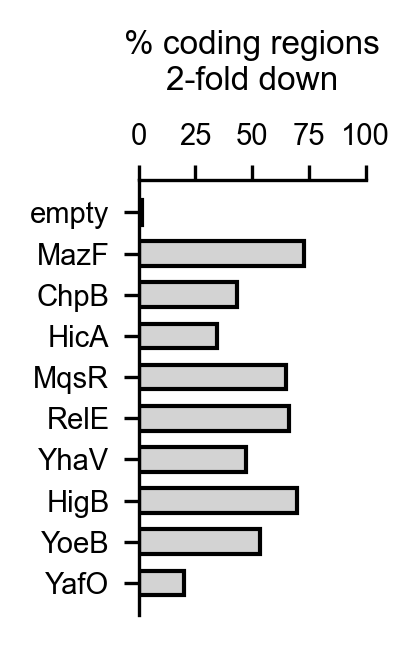

In [13]:
## INPUTS ##
toxin_list = ['empty', 'MazF', 'ChpB', 'HicA', 'MqsR', 'RelE', 'YhaV', 'HigB', 'YoeB', 'YafO']
rrna_margin = 100
exp_threshold = 6.
cr_threshold = -1

percent_down = []
for tox in toxin_list:
    # size of mask around rRNA regions for count normalization
    rrna_margin = 100
    ### LOAD & NORMALIZE CLEAVAGE RATIO DATA
    if tox == 'empty':
        ctl_arrays, _ = loadarrays('/home/pculviner/notebook/storage/rnaseq/old_data/mazf_dutp/dutp_pipeline/density_numpy_all/',
                                            control_has = ['ev'],
                                            control_not = [],
                                            experimental_has = [tox],
                                            experimental_not = [], verbose = False)
        # here just set one of the two ctl arrays to the exp array to do the empty vector to empty vector comparison
        exp_arrays = [ctl_arrays[0]]
        ctl_arrays = [ctl_arrays[1]]
    elif tox != 'MazF':
        # load arrays for peaks
        ctl_arrays, exp_arrays = loadarrays('/home/pculviner/notebook/storage/rnaseq/old_data/all_toxin_dutp/dutp_pipeline/density_numpy_all/',
                                            control_has = ['ev'],
                                            control_not = [],
                                            experimental_has = [tox],
                                            experimental_not = [], verbose = False)
    else:
        # load arrays for peaks
        ctl_arrays, exp_arrays = loadarrays('/home/pculviner/notebook/storage/rnaseq/old_data/mazf_dutp/dutp_pipeline/density_numpy_all/',
                                            control_has = ['ev'],
                                            control_not = [],
                                            experimental_has = [tox],
                                            experimental_not = [], verbose = False)
    # generate the rrna mask - these regions will not be included in the calculation of size factors for count normalization
    rrna_regions = gene_table.loc[gene_table.locus_type == 'rRNA',['strand', 'start', 'end']].values.astype(int)
    rrna_regions[:,1] = rrna_regions[:,1] - rrna_margin
    rrna_regions[:,2] = rrna_regions[:,2] + rrna_margin
    rrna_mask = ga.regionstomask(rrna_regions, len(loaded_genbank))
    # normalize the arrays by counts in the non-masked regions 
    normalized_arrays = maskedcountnormalization(np.r_[ctl_arrays,exp_arrays], rrna_mask, pseudo = True)
    # split the arrays back into control and experimental
    ctl_means = np.mean(np.log2(normalized_arrays[:len(ctl_arrays)]),axis=0)
    exp_means = np.mean(np.log2(normalized_arrays[len(ctl_arrays):]),axis=0)
    # calculate a mean ratio across both data sets - convert back into linear space for lulz
    cleavage_ratio = exp_means - ctl_means
    # get coding regions
    coding_regions = gene_table.loc[gene_table.locus_type == 'CDS',['strand', 'start', 'end']].values.astype(int)
    # generate a mask for regions completely above the expression threshold
    data_mask = ctl_means >= exp_threshold
    data_expressed = ga.regionfunc(np.all, coding_regions, data_mask)
    # get a mask for regions that drop below cleavage threshold
    data_cleaved_mask = cleavage_ratio <= cr_threshold
    data_cleaved = ga.regionfunc(np.any, coding_regions, data_cleaved_mask)
    # calculate numbers
    total_cleaved = np.all([data_expressed,data_cleaved],axis=0).sum()
    total_expressed = np.sum(data_expressed)
    print ('%s: %i/%i (%.1f%%)'%(tox, total_cleaved, total_expressed, total_cleaved/total_expressed*100))
    percent_down.append(total_cleaved/total_expressed*100)
    
# generate the plot
fig,ax = plt.subplots(1,figsize=(1.5,2.25))
ax.barh(-1*np.arange(len(percent_down)),percent_down,height=.6,color='#D3D3D3',edgecolor='k',lw=1,)
sns.despine(top=False,bottom=True)
ax.set_xticks([0,25,50,75,100])
ax.set_yticks(-1*np.arange(len(percent_down)))
ax.set_yticklabels(toxin_list)
ax.set_xlabel('% coding regions\n2-fold down',labelpad=8)
ax.xaxis.set_label_position('top')
plt.tight_layout()


plt.savefig('figure_outputs/1D_percent_cleaved.pdf',format='pdf',bbox_inches='tight')

# Figure 2 (+ parts S1)

## Fig 2E: _dnaK_ comparision of data types

In [14]:
# load the mg1655 genome
genbank_path = '/home/pculviner/notebook/genomes/mg1655_v3/Ec_mg1655v3.gb'
loaded_genbank = SeqIO.read(genbank_path,'genbank')
# load a gene table csv from the provided path
gene_table_path = '/home/pculviner/notebook/genomes/mg1655_v3/gt_mg1655_v3.csv'
gene_table = pd.read_csv(gene_table_path, index_col=0)
# generate a onehot representation of the genome
onehot_genome = ga.genometoonehot(loaded_genbank)
aca_loc = getmotiflocations('ACA', onehot_genome)

window zero at 12162, window is not reversed: True


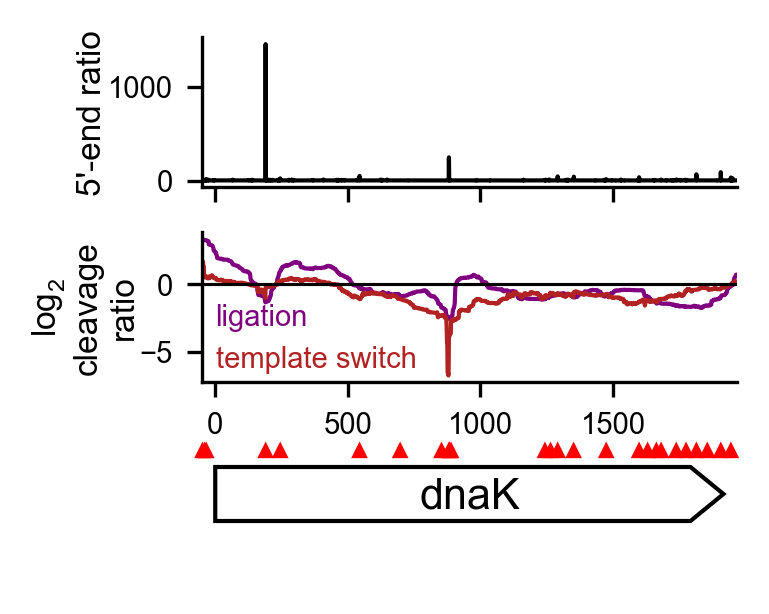

In [15]:
toxin = 'MazF'

window = gw.GenomeWindow(gene_table = gene_table, genome = loaded_genbank, gene_name_column='plt_tag',
                         axes_heights = [.5,.5,.1,.4], fig_width=2.3, show_poi=True,)

window.setpositionbygene(name='dnaK', nt_5=50, nt_3=50)

## load peaks ##
# size of mask around rRNA regions for count normalization
rrna_margin = 100
# load arrays for peaks
ctl_arrays, exp_arrays = loadarrays('/home/pculviner/notebook/storage/rnaseq/PCe22_novaseq/ezpool_pipeline/five_prime_numpy_all/',
                                    control_has = ['rz','ev',],
                                    control_not = ['trna', 'frg'],
                                    experimental_has = ['rz',toxin,],
                                    experimental_not = ['trna', 'frg'], verbose = False)
# generate the rrna mask - these regions will not be included in the calculation of size factors for count normalization
rrna_regions = gene_table.loc[gene_table.locus_type == 'rRNA',['strand', 'start', 'end']].values.astype(int)
rrna_regions[:,1] = rrna_regions[:,1] - rrna_margin
rrna_regions[:,2] = rrna_regions[:,2] + rrna_margin
rrna_mask = ga.regionstomask(rrna_regions, len(loaded_genbank))
# normalize the arrays by counts in the non-masked regions 
normalized_arrays = maskedcountnormalization(np.r_[ctl_arrays,exp_arrays], rrna_mask, pseudo = True)
# split the arrays back into control and experimental
ctl_means = np.mean(np.log2(normalized_arrays[:len(ctl_arrays)]),axis=0)
exp_means = np.mean(np.log2(normalized_arrays[len(ctl_arrays):]),axis=0)
# calculate a mean ratio across both data sets
peaks = exp_means - ctl_means

window.plotdatastreams(axis_n = [0],
                   input_data = [2**peaks],
                   color = ['k',],
                   alpha = [1,], rasterize_data = False,
                   stream_type = gw.ArrayAsLine, lw = 1)

### LOAD & NORMALIZE CLEAVAGE RATIO DATA
# load arrays for peaks
ctl_arrays, exp_arrays = loadarrays('/home/pculviner/notebook/storage/rnaseq/PCe22_novaseq/ezpool_pipeline/density_numpy_all/',
                                    control_has = ['rz','ev','frg'],
                                    control_not = ['trna', ],
                                    experimental_has = ['rz',toxin,'frg'],
                                    experimental_not = ['trna',], verbose = False)
# generate the rrna mask - these regions will not be included in the calculation of size factors for count normalization
rrna_regions = gene_table.loc[gene_table.locus_type == 'rRNA',['strand', 'start', 'end']].values.astype(int)
rrna_regions[:,1] = rrna_regions[:,1] - rrna_margin
rrna_regions[:,2] = rrna_regions[:,2] + rrna_margin
rrna_mask = ga.regionstomask(rrna_regions, len(loaded_genbank))
# normalize the arrays by counts in the non-masked regions 
normalized_arrays = maskedcountnormalization(np.r_[ctl_arrays,exp_arrays], rrna_mask, pseudo = True)
# split the arrays back into control and experimental
ctl_means = np.mean(np.log2(normalized_arrays[:len(ctl_arrays)]),axis=0)
exp_means = np.mean(np.log2(normalized_arrays[len(ctl_arrays):]),axis=0)
# calculate a mean ratio across both data sets
cleavage_ratio_frag = exp_means - ctl_means

# load arrays for valleys
ctl_arrays, exp_arrays = loadarrays('/home/pculviner/notebook/storage/rnaseq/old_data/mazf_dutp/dutp_pipeline/density_numpy_all/',
                                    control_has = ['ev',],
                                    control_not = [],
                                    experimental_has = [toxin,],
                                    experimental_not = [], verbose = False)
# generate the rrna mask - these regions will not be included in the calculation of size factors for count normalization
rrna_regions = gene_table.loc[gene_table.locus_type == 'rRNA',['strand', 'start', 'end']].values.astype(int)
rrna_regions[:,1] = rrna_regions[:,1] - rrna_margin
rrna_regions[:,2] = rrna_regions[:,2] + rrna_margin
rrna_mask = ga.regionstomask(rrna_regions, len(loaded_genbank))
# normalize the arrays by counts in the non-masked regions 
normalized_arrays = maskedcountnormalization(np.r_[ctl_arrays,exp_arrays], rrna_mask, pseudo = True)
# split the arrays back into control and experimental
ctl_means = np.mean(np.log2(normalized_arrays[:len(ctl_arrays)]),axis=0)
exp_means = np.mean(np.log2(normalized_arrays[len(ctl_arrays):]),axis=0)
# calculate a mean ratio across both data sets
dutp_cleavage_ratio = exp_means - ctl_means

window.plotdatastreams(axis_n = [1,1],
                   input_data = [dutp_cleavage_ratio, cleavage_ratio_frag],
                   color = ['purple','firebrick',],
                   label = ['ligation','template switch',],
                   alpha = 1, rasterize_data=False,
                   stream_type = gw.ArrayAsLine, lw = 1)

window.plotdatastreams(axis_n = None,
                   input_data = aca_loc,
                   stream_type = gw.PointsOfInterest)

# window.axesdata[0].set_ylim(0,12)

# apply some labels
window.axesdata[0].set_ylabel("5'-end ratio",labelpad=0)
window.axesdata[1].set_ylabel('log$\mathdefault{_2}$\ncleavage\nratio',labelpad=0)
window.axesdata[1].axhline(0,0,1,lw=.75,c='k')
# generate a legend
legend = window.axesdata[1].legend(bbox_to_anchor=(-.04, -.02), loc='lower left',
                        borderaxespad=0., fontsize=7, frameon=False, handlelength=0, labelcolor ='linecolor', markerscale=0)
# move up genome plot slightly
gw.moveaxis(window.ax_sequence,dy=.05)
gw.moveaxis(window.ax_genes,dy=.225)
# save
plt.savefig('figure_outputs/2E_dnaK_gene.pdf',format='pdf',bbox_inches='tight')

## S1B: data around peaks

In [16]:
def pullsequence(location, five, three, genome):
    strand, position = location
    if strand == 0:
        return str(genome.seq[position-five:position+three])
    if strand == 1:
        return str(genome.seq[position-three+1:position+five+1].reverse_complement())

control: rz_5m-ev1.2.1.npy
control: rz_5m-ev2.2.13.npy
experimental: rz_5m-mazf1.2.2.npy
experimental: rz_5m-mazf2.2.14.npy
control: rz_frg_5m-ev1.1.1.npy
control: rz_frg_5m-ev2.1.13.npy
experimental: rz_frg_5m-mazf1.1.2.npy
experimental: rz_frg_5m-mazf2.1.14.npy
control: ev1_5m.1.npy
control: ev2_5m.2.npy
experimental: mazf1_5m.3.npy
experimental: mazf2_5m.4.npy
239


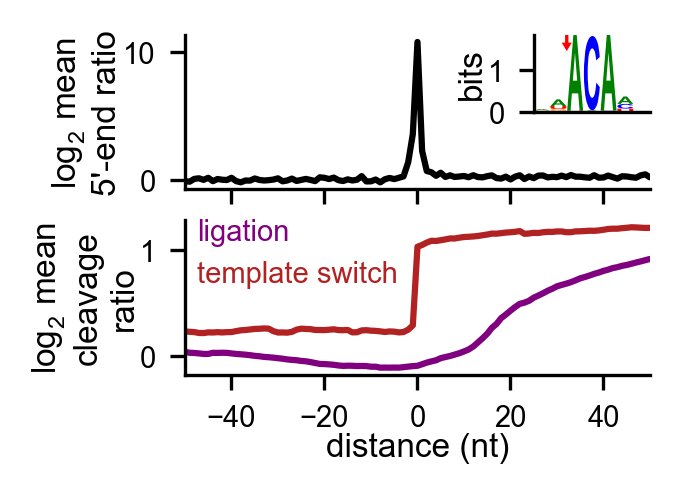

In [17]:
######## INPUTS ######## 
########################
figsize = (2,1.5)
# size of mask around rRNA regions for count normalization
rrna_margin = 100
# log2 threshold
threshold = np.log2(1000)
# motif region
five, three = (2,5)
# cleavage profile region
surrounding_nt = 50
# load the mg1655 genome
genbank_path = '/home/pculviner/notebook/genomes/mg1655_v3/Ec_mg1655v3.gb'
loaded_genbank = SeqIO.read(genbank_path,'genbank')
# load a gene table csv from the provided path
gene_table_path = '/home/pculviner/notebook/genomes/mg1655_v3/gt_mg1655_v3.csv'
gene_table = pd.read_csv(gene_table_path, index_col=0)


########################
########################

#### LOAD 5'-RATIO ARRAYS
# load arrays
ctl_arrays, exp_arrays = loadarrays('/home/pculviner/notebook/storage/rnaseq/PCe22_novaseq/ezpool_pipeline/five_prime_numpy_all/',
                                    control_has = ['rz','ev'],
                                    control_not = ['trna','frg'],
                                    experimental_has = ['rz','mazf'],
                                    experimental_not = ['trna','frg'])
# generate the rrna mask - these regions will not be included in the calculation of size factors for count normalization
rrna_regions = gene_table.loc[gene_table.locus_type == 'rRNA',['strand', 'start', 'end']].values.astype(int)
rrna_regions[:,1] = rrna_regions[:,1] - rrna_margin
rrna_regions[:,2] = rrna_regions[:,2] + rrna_margin
rrna_mask = ga.regionstomask(rrna_regions, len(loaded_genbank))
# normalize the arrays by counts in the non-masked regions 
normalized_arrays = maskedcountnormalization(np.r_[ctl_arrays,exp_arrays], rrna_mask, pseudo = True)
# split the arrays back into control and experimental
ctl_arrays = normalized_arrays[:len(ctl_arrays)]
exp_arrays = normalized_arrays[len(ctl_arrays):]
# calculate a mean ratio across both data sets
ratio_data = np.mean(np.log2(exp_arrays/ctl_arrays),axis=0)

#### LOAD FRAG TSWITCH CLEAVAGE PROFILES
# load arrays
ctl_arrays, exp_arrays = loadarrays('/home/pculviner/notebook/storage/rnaseq/PCe22_novaseq/ezpool_pipeline/density_numpy_all/',
                                    control_has = ['rz','ev','frg'],
                                    control_not = ['trna',],
                                    experimental_has = ['rz','mazf','frg'],
                                    experimental_not = ['trna',], verbose = True)
# generate the rrna mask - these regions will not be included in the calculation of size factors for count normalization
rrna_regions = gene_table.loc[gene_table.locus_type == 'rRNA',['strand', 'start', 'end']].values.astype(int)
rrna_regions[:,1] = rrna_regions[:,1] - rrna_margin
rrna_regions[:,2] = rrna_regions[:,2] + rrna_margin
rrna_mask = ga.regionstomask(rrna_regions, len(loaded_genbank))
# normalize the arrays by counts in the non-masked regions 
normalized_arrays = maskedcountnormalization(np.r_[ctl_arrays,exp_arrays], rrna_mask, pseudo = True)
# split the arrays back into control and experimental
ctl_means = np.mean(np.log2(normalized_arrays[:len(ctl_arrays)]),axis=0)
exp_means = np.mean(np.log2(normalized_arrays[len(ctl_arrays):]),axis=0)
# calculate a cleavage ratio
fragmented_tswitch_cr = (exp_means - ctl_means)

#### LOAD LIGATION CLEAVAGE PROFILES
# load arrays
ctl_arrays, exp_arrays = loadarrays('/home/pculviner/notebook/storage/rnaseq/old_data/mazf_dutp/dutp_pipeline/density_numpy_all/',
                                    control_has = ['ev'],
                                    control_not = [],
                                    experimental_has = ['mazf'],
                                    experimental_not = [], verbose = True)
# generate the rrna mask - these regions will not be included in the calculation of size factors for count normalization
rrna_regions = gene_table.loc[gene_table.locus_type == 'rRNA',['strand', 'start', 'end']].values.astype(int)
rrna_regions[:,1] = rrna_regions[:,1] - rrna_margin
rrna_regions[:,2] = rrna_regions[:,2] + rrna_margin
rrna_mask = ga.regionstomask(rrna_regions, len(loaded_genbank))
# normalize the arrays by counts in the non-masked regions 
normalized_arrays = maskedcountnormalization(np.r_[ctl_arrays,exp_arrays], rrna_mask, pseudo = True)
# split the arrays back into control and experimental
ctl_means = np.mean(np.log2(normalized_arrays[:len(ctl_arrays)]),axis=0)
exp_means = np.mean(np.log2(normalized_arrays[len(ctl_arrays):]),axis=0)
# calculate a cleavage ratio
ligation_cr = (exp_means - ctl_means)

#### PULL REGIONS AROUND PEAKS FOR NT INFORMATION AND CLEAVAGE PROFILE INFORMATION
flagged_sites = np.asarray(np.where(ratio_data >= threshold)).T # sites that meet threshold
nt_counts = np.zeros((five+three,4)) # array for storage of nt counts
# step through flagged sites and record nt data
for flagged_site in flagged_sites:
    nt_counts += ga.dnatoonehot(pullsequence(flagged_site, five, three, loaded_genbank))
# get left and right regions around peak
flagged_regions = np.asarray([flagged_sites[:,0],flagged_sites[:,1]-surrounding_nt,flagged_sites[:,1]+surrounding_nt]).T
# plot
fig,axes = plt.subplots(2,1,sharex=True, figsize=figsize)
# calculate x values
x_values = np.arange(-1*surrounding_nt,surrounding_nt+1)
# plot the peak quantification
axes[0].plot(x_values,np.mean(ga.regionfunc(lambda x:x, flagged_regions, ratio_data),axis=0),c='k', label="template switch")
axes[0].set_ylabel("log$\mathdefault{_2}$ mean\n5'-end ratio",labelpad=0)
# plot cleavage ratio data from new experiments
axes[1].plot(x_values,np.mean(ga.regionfunc(lambda x:x, flagged_regions, ligation_cr),axis=0),c='purple',label='ligation')
axes[1].plot(x_values,np.mean(ga.regionfunc(lambda x:x, flagged_regions, fragmented_tswitch_cr),axis=0),c='firebrick',label='template switch')
# generate a legend
legend = axes[1].legend(bbox_to_anchor=(-.05, 1.09), loc='upper left', borderaxespad=0., fontsize=7, frameon=False, handlelength=0, labelcolor ='linecolor', markerscale=0)
# label the axes
axes[1].set_xlim(-1*surrounding_nt,surrounding_nt)
axes[1].set_ylabel("log$\mathdefault{_2}$ mean\ncleavage\nratio",labelpad=0)
axes[1].set_xlabel('distance (nt)',labelpad=0)

# generate an inset axis with MazF's sequence logo
inset_ax = axes[0].inset_axes((0.75,0.5,.25,.5))

logo = lm.Logo(lm.transform_matrix(pd.DataFrame(data=nt_counts, columns = ['A','U','G','C']), from_type='counts', to_type='information'),
        font_name = 'Arial',
        ax = inset_ax,
        figsize=(1.3,.9),)
logo.style_spines(spines=['right','top'], visible=False)
logo.ax.set_ylabel('bits',labelpad=0)
logo.ax.set_xticks([])
logo.ax.arrow(five-.5,logo.ax.get_ylim()[1],0,logo.ax.get_ylim()[1]*-.1,width=0.2,ec='None',fc='red',head_length=.2)
# global despine
sns.despine()
# save
plt.savefig('figure_outputs/S1B_MazF_peak_surroundings.pdf',format='pdf',bbox_inches='tight')
print(len(flagged_regions))

## Fig 2F: correlation main figure

n genes = 213


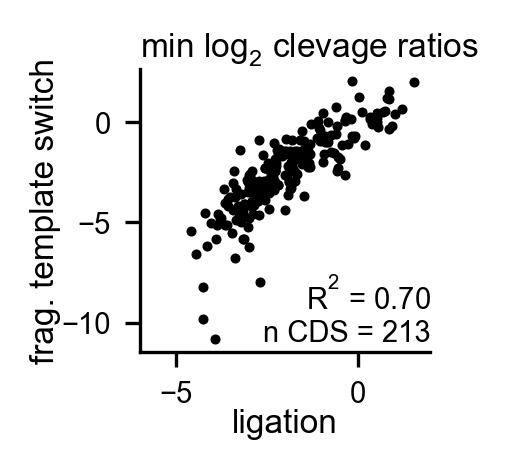

In [18]:
# size of mask around rRNA regions for count normalization
rrna_margin = 100
# load the mg1655 genome
genbank_path = '/home/pculviner/notebook/genomes/mg1655_v3/Ec_mg1655v3.gb'
loaded_genbank = SeqIO.read(genbank_path,'genbank')
# load a gene table csv from the provided path
gene_table_path = '/home/pculviner/notebook/genomes/mg1655_v3/gt_mg1655_v3.csv'
gene_table = pd.read_csv(gene_table_path, index_col=0)

### LOAD & NORMALIZE CLEAVAGE RATIO DATA
# load arrays for peaks
ctl_arrays, exp_arrays = loadarrays('/home/pculviner/notebook/storage/rnaseq/PCe22_novaseq/ezpool_pipeline/density_numpy_all/',
                                    control_has = ['rz','ev','frg'],
                                    control_not = ['trna', ],
                                    experimental_has = ['rz','mazf','frg'],
                                    experimental_not = ['trna',], verbose = False)
# generate the rrna mask - these regions will not be included in the calculation of size factors for count normalization
rrna_regions = gene_table.loc[gene_table.locus_type == 'rRNA',['strand', 'start', 'end']].values.astype(int)
rrna_regions[:,1] = rrna_regions[:,1] - rrna_margin
rrna_regions[:,2] = rrna_regions[:,2] + rrna_margin
rrna_mask = ga.regionstomask(rrna_regions, len(loaded_genbank))
# normalize the arrays by counts in the non-masked regions 
normalized_arrays = maskedcountnormalization(np.r_[ctl_arrays,exp_arrays], rrna_mask, pseudo = True)
# split the arrays back into control and experimental
frag_ctl_means = np.mean(np.log2(normalized_arrays[:len(ctl_arrays)]),axis=0)
frag_exp_means = np.mean(np.log2(normalized_arrays[len(ctl_arrays):]),axis=0)
# calculate a mean ratio across both data sets
cleavage_ratio_frag = frag_exp_means - frag_ctl_means

# load arrays for peaks
ctl_arrays, exp_arrays = loadarrays('/home/pculviner/notebook/storage/rnaseq/PCe22_novaseq/ezpool_pipeline/density_numpy_all/',
                                    control_has = ['rz','ev',],
                                    control_not = ['trna','frg' ],
                                    experimental_has = ['rz','mazf',],
                                    experimental_not = ['trna','frg'], verbose = False)
# generate the rrna mask - these regions will not be included in the calculation of size factors for count normalization
rrna_regions = gene_table.loc[gene_table.locus_type == 'rRNA',['strand', 'start', 'end']].values.astype(int)
rrna_regions[:,1] = rrna_regions[:,1] - rrna_margin
rrna_regions[:,2] = rrna_regions[:,2] + rrna_margin
rrna_mask = ga.regionstomask(rrna_regions, len(loaded_genbank))
# normalize the arrays by counts in the non-masked regions 
normalized_arrays = maskedcountnormalization(np.r_[ctl_arrays,exp_arrays], rrna_mask, pseudo = True)
# split the arrays back into control and experimental
nofrag_ctl_means = np.mean(np.log2(normalized_arrays[:len(ctl_arrays)]),axis=0)
nofrag_exp_means = np.mean(np.log2(normalized_arrays[len(ctl_arrays):]),axis=0)
# calculate a mean ratio across both data sets
cleavage_ratio_nofrag = nofrag_exp_means - nofrag_ctl_means

# load arrays for valleys
ctl_arrays, exp_arrays = loadarrays('/home/pculviner/notebook/storage/rnaseq/old_data/mazf_dutp/dutp_pipeline/density_numpy_all/',
                                    control_has = ['ev',],
                                    control_not = [],
                                    experimental_has = ['mazf',],
                                    experimental_not = [], verbose = False)
# generate the rrna mask - these regions will not be included in the calculation of size factors for count normalization
rrna_regions = gene_table.loc[gene_table.locus_type == 'rRNA',['strand', 'start', 'end']].values.astype(int)
rrna_regions[:,1] = rrna_regions[:,1] - rrna_margin
rrna_regions[:,2] = rrna_regions[:,2] + rrna_margin
rrna_mask = ga.regionstomask(rrna_regions, len(loaded_genbank))
# normalize the arrays by counts in the non-masked regions 
normalized_arrays = maskedcountnormalization(np.r_[ctl_arrays,exp_arrays], rrna_mask, pseudo = True)
# split the arrays back into control and experimental
dutp_ctl_means = np.mean(np.log2(normalized_arrays[:len(ctl_arrays)]),axis=0)
dutp_exp_means = np.mean(np.log2(normalized_arrays[len(ctl_arrays):]),axis=0)
# calculate a mean ratio across both data sets
dutp_cleavage_ratio = dutp_exp_means - dutp_ctl_means

from scipy import stats

threshold = 8
coding_regions = gene_table.loc[gene_table.locus_type == 'CDS',['strand', 'start', 'end']].values.astype(int)
data_mask = np.all([dutp_ctl_means >= threshold, frag_ctl_means >= threshold],axis=0)
data_expressed = ga.regionfunc(np.all, coding_regions, data_mask)
print('n genes = %i'%np.sum(data_expressed))
x = ga.regionfunc(np.min, coding_regions[data_expressed], dutp_cleavage_ratio)
y = ga.regionfunc(np.min, coding_regions[data_expressed], cleavage_ratio_frag)

fig, ax = plt.subplots(1,figsize=(1.25,1.25),sharex=True,sharey=True)
ax.scatter(x,y, s=2, color='k')
slope, intercept, r_value, _, _ = stats.linregress(x, y)
ax.set_xlim(-6,2)
ax.set_xticks([-5,0])

# show some information
# label
ax.text(ax.get_xlim()[0],ax.get_ylim()[1],'min log$\mathdefault{_2}$ clevage ratios', size = 8, ha='left', va='bottom')
# statistics 
ax.text(ax.get_xlim()[1],ax.get_ylim()[0]+.2,'$\mathdefault{R^2}$ = %.2f\nn CDS = %i'%(r_value**2,np.sum(data_expressed)),size = 7, ha='right', va='bottom')
ax.set_xlabel('ligation', labelpad=0)
ax.set_ylabel('frag. template switch', labelpad=0)
sns.despine()
# save
plt.savefig('figure_outputs/2F_cds_minimum_correlations.pdf',format='pdf',bbox_inches='tight')

## Figure S1C: threshold variation in correlations

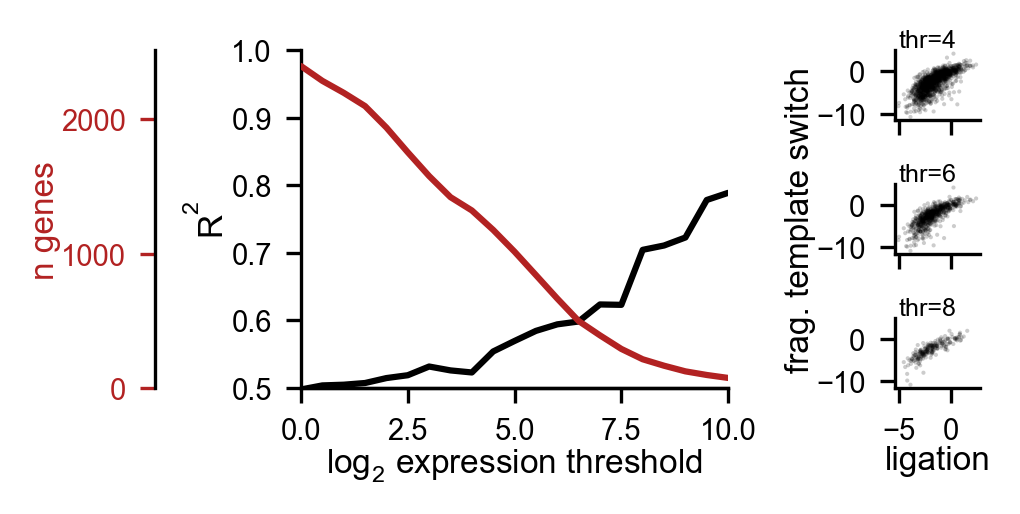

In [19]:
# size of mask around rRNA regions for count normalization
rrna_margin = 100
# load the mg1655 genome
genbank_path = '/home/pculviner/notebook/genomes/mg1655_v3/Ec_mg1655v3.gb'
loaded_genbank = SeqIO.read(genbank_path,'genbank')
# load a gene table csv from the provided path
gene_table_path = '/home/pculviner/notebook/genomes/mg1655_v3/gt_mg1655_v3.csv'
gene_table = pd.read_csv(gene_table_path, index_col=0)

### LOAD & NORMALIZE CLEAVAGE RATIO DATA
# load arrays for peaks
ctl_arrays, exp_arrays = loadarrays('/home/pculviner/notebook/storage/rnaseq/PCe22_novaseq/ezpool_pipeline/density_numpy_all/',
                                    control_has = ['rz','ev','frg'],
                                    control_not = ['trna', ],
                                    experimental_has = ['rz','mazf','frg'],
                                    experimental_not = ['trna',], verbose = False)
# generate the rrna mask - these regions will not be included in the calculation of size factors for count normalization
rrna_regions = gene_table.loc[gene_table.locus_type == 'rRNA',['strand', 'start', 'end']].values.astype(int)
rrna_regions[:,1] = rrna_regions[:,1] - rrna_margin
rrna_regions[:,2] = rrna_regions[:,2] + rrna_margin
rrna_mask = ga.regionstomask(rrna_regions, len(loaded_genbank))
# normalize the arrays by counts in the non-masked regions 
normalized_arrays = maskedcountnormalization(np.r_[ctl_arrays,exp_arrays], rrna_mask, pseudo = True)
# split the arrays back into control and experimental
frag_ctl_means = np.mean(np.log2(normalized_arrays[:len(ctl_arrays)]),axis=0)
frag_exp_means = np.mean(np.log2(normalized_arrays[len(ctl_arrays):]),axis=0)
# calculate a mean ratio across both data sets
cleavage_ratio_frag = frag_exp_means - frag_ctl_means

# load arrays for peaks
ctl_arrays, exp_arrays = loadarrays('/home/pculviner/notebook/storage/rnaseq/PCe22_novaseq/ezpool_pipeline/density_numpy_all/',
                                    control_has = ['rz','ev',],
                                    control_not = ['trna','frg' ],
                                    experimental_has = ['rz','mazf',],
                                    experimental_not = ['trna','frg'], verbose = False)
# generate the rrna mask - these regions will not be included in the calculation of size factors for count normalization
rrna_regions = gene_table.loc[gene_table.locus_type == 'rRNA',['strand', 'start', 'end']].values.astype(int)
rrna_regions[:,1] = rrna_regions[:,1] - rrna_margin
rrna_regions[:,2] = rrna_regions[:,2] + rrna_margin
rrna_mask = ga.regionstomask(rrna_regions, len(loaded_genbank))
# normalize the arrays by counts in the non-masked regions 
normalized_arrays = maskedcountnormalization(np.r_[ctl_arrays,exp_arrays], rrna_mask, pseudo = True)
# split the arrays back into control and experimental
nofrag_ctl_means = np.mean(np.log2(normalized_arrays[:len(ctl_arrays)]),axis=0)
nofrag_exp_means = np.mean(np.log2(normalized_arrays[len(ctl_arrays):]),axis=0)
# calculate a mean ratio across both data sets
cleavage_ratio_nofrag = nofrag_exp_means - nofrag_ctl_means

# load arrays for valleys
ctl_arrays, exp_arrays = loadarrays('/home/pculviner/notebook/storage/rnaseq/old_data/mazf_dutp/dutp_pipeline/density_numpy_all/',
                                    control_has = ['ev',],
                                    control_not = [],
                                    experimental_has = ['mazf',],
                                    experimental_not = [], verbose = False)
# generate the rrna mask - these regions will not be included in the calculation of size factors for count normalization
rrna_regions = gene_table.loc[gene_table.locus_type == 'rRNA',['strand', 'start', 'end']].values.astype(int)
rrna_regions[:,1] = rrna_regions[:,1] - rrna_margin
rrna_regions[:,2] = rrna_regions[:,2] + rrna_margin
rrna_mask = ga.regionstomask(rrna_regions, len(loaded_genbank))
# normalize the arrays by counts in the non-masked regions 
normalized_arrays = maskedcountnormalization(np.r_[ctl_arrays,exp_arrays], rrna_mask, pseudo = True)
# split the arrays back into control and experimental
dutp_ctl_means = np.mean(np.log2(normalized_arrays[:len(ctl_arrays)]),axis=0)
dutp_exp_means = np.mean(np.log2(normalized_arrays[len(ctl_arrays):]),axis=0)
# calculate a mean ratio across both data sets
dutp_cleavage_ratio = dutp_exp_means - dutp_ctl_means

#### GENERATE PLOTS

thresholds = np.arange(0,10.5,.5)
plotted_thresholds = [4,6,8]
plotted_thresholds_data = []
correlations = []
n_genes = []
for t in thresholds:
    coding_regions = gene_table.loc[gene_table.locus_type == 'CDS',['strand', 'start', 'end']].values.astype(int)
    data_mask = np.all([dutp_ctl_means >= t, frag_ctl_means >= t],axis=0)
    data_expressed = ga.regionfunc(np.all, coding_regions, data_mask)
    # calculate minimum cleavage ratios for both data types
    x = ga.regionfunc(np.min, coding_regions[data_expressed], dutp_cleavage_ratio)
    y = ga.regionfunc(np.min, coding_regions[data_expressed], cleavage_ratio_frag)
    slope, intercept, r_value, _, _ = stats.linregress(x, y)
    # save data
    correlations.append(r_value**2)
    n_genes.append(np.sum(data_expressed))
    if t in plotted_thresholds:
        plotted_thresholds_data.append((x,y))
    

## plot figures
fig = plt.figure(constrained_layout=True, figsize=(3.25,1.6))
# make a gridspec
gridspec = fig.add_gridspec(ncols=6, nrows=3)
coor_ax = fig.add_subplot(gridspec[:,:5])
scatter_axes = [fig.add_subplot(gridspec[i,5:]) for i in [0,1,2]] 
# prepare the correlation axis
coor_ax.plot(thresholds,correlations,c='k')
n_genes_ax = coor_ax.twinx()
n_genes_ax.plot(thresholds,n_genes,c='firebrick')
# plot the three sample axes
for i,(t, t_data) in enumerate(zip(plotted_thresholds,plotted_thresholds_data)):
    scatter_axes[i].scatter(t_data[0],t_data[1],s=1,edgecolor='None',alpha=.2,facecolor='k',rasterized=True)
[(ax.sharex(scatter_axes[0]),ax.sharey(scatter_axes[0])) for ax in scatter_axes[1:]] # share x and y axes
[(plt.setp(ax.get_xticklabels(),visible=False)) for ax in scatter_axes[:-1]]
[ax.text(0.05,1.05,'thr=%i'%t,transform=ax.transAxes,fontsize=6) for t,ax in zip(plotted_thresholds,scatter_axes)]


# set limits
coor_ax.set_ylim(0.5,1)
n_genes_ax.set_ylim(0,n_genes_ax.get_ylim()[1])
coor_ax.set_xlim(0,10)
# set labels
coor_ax.set_ylabel("$\mathdefault{R^2}$",labelpad=0)
coor_ax.set_xlabel('log$\mathdefault{_2}$ expression threshold',labelpad=0)
n_genes_ax.yaxis.set_label_position("left")
n_genes_ax.set_ylabel('n genes',c='firebrick',labelpad=0)
n_genes_ax.tick_params(axis='y', colors='firebrick')
scatter_axes[1].set_ylabel('frag. template switch',labelpad=0)
scatter_axes[2].set_xlabel('ligation',labelpad=0)
# position n genes axis

n_genes_ax.yaxis.tick_left()
n_genes_ax.spines['left'].set_position(('outward',35))

sns.despine()
plt.savefig('figure_outputs/S1C_threshold_setting.pdf',format='pdf',bbox_inches='tight')

# Figure 3 (+ S3)

## Figure 3A & 3B:

In [20]:
def normalizebynonrrna(ctl_arrays, exp_arrays, rrna_margin, gene_table):
    # generate the rrna mask - these regions will not be included in the calculation of size factors for count normalization
    rrna_regions = gene_table.loc[gene_table.locus_type == 'rRNA',['strand', 'start', 'end']].values.astype(int)
    rrna_regions[:,1] = rrna_regions[:,1] - rrna_margin
    rrna_regions[:,2] = rrna_regions[:,2] + rrna_margin
    rrna_mask = ga.regionstomask(rrna_regions, len(loaded_genbank))
    # normalize the arrays by counts in the non-masked regions 
    normalized_arrays = maskedcountnormalization(np.r_[ctl_arrays,exp_arrays], rrna_mask, pseudo = True)
    # split the arrays back into control and experimental
    normalized_ctl_arrays = normalized_arrays[:len(ctl_arrays)]
    normalized_exp_arrays = normalized_arrays[len(ctl_arrays):]
    return normalized_ctl_arrays, normalized_exp_arrays

## INPUTS ##
toxin_list = ['MazF', 'ChpB', 'MqsR', 'RelE']
rrna_margin = 100
end_threshold = np.log2(32)
cr_region = (10,0)
exp_threshold = 6.
cr_threshold = -1
############

# load the mg1655 genome
genbank_path = '/home/pculviner/notebook/genomes/mg1655_v3/Ec_mg1655v3.gb'
loaded_genbank = SeqIO.read(genbank_path,'genbank')
# load a gene table csv from the provided path
gene_table_path = '/home/pculviner/notebook/genomes/mg1655_v3/gt_mg1655_v3.csv'
gene_table = pd.read_csv(gene_table_path, index_col=0)
# storage arrays for things that need be handleded at the end
peak_storage = []
for i,toxin_name in enumerate(toxin_list):
    print('%s: load data...'%toxin_name)
    # load end sequencing arrays
    end_ctl_arrays, end_exp_arrays = loadarrays('/home/pculviner/notebook/storage/rnaseq/PCe22_novaseq/ezpool_pipeline/five_prime_numpy_all/',
                                                control_has = ['rz','ev'], control_not = ['trna','frg'],
                                                experimental_has = ['rz',toxin_name], experimental_not = ['trna','frg'], verbose = False)
    end_ctl_arrays, end_exp_arrays = normalizebynonrrna(end_ctl_arrays, end_exp_arrays, rrna_margin, gene_table)
    tswitch_end_mapping = np.mean(np.log2(end_exp_arrays),axis=0) - np.mean(np.log2(end_ctl_arrays),axis=0)
    
    # load fragmented arrays
    density_ctl_arrays, density_exp_arrays = loadarrays('/home/pculviner/notebook/storage/rnaseq/PCe22_novaseq/ezpool_pipeline/density_numpy_all/',
                                                         control_has = ['rz','ev','frg'], control_not = ['trna',],
                                                         experimental_has = ['rz',toxin_name,'frg'], experimental_not = ['trna',], verbose = False)
    density_ctl_arrays, density_exp_arrays = normalizebynonrrna(density_ctl_arrays, density_exp_arrays, rrna_margin, gene_table)
    mean_ctl_density = np.mean(np.log2(density_ctl_arrays),axis=0)
    tswitch_cleavage_ratio = np.mean(np.log2(density_exp_arrays),axis=0) - np.mean(np.log2(density_ctl_arrays),axis=0)
    
    # identify peaks
    meets_end_threshold = np.asarray(np.where(tswitch_end_mapping >= end_threshold)).T
    # convert to region format [strand, start, end] where start == end
    toxin_peaks = np.c_[meets_end_threshold,meets_end_threshold[:,1:2]]
    # verify that:
    # 1. nearby region is expressed to make a cleavage call 
    meets_exp_threshold = np.asarray(ga.regionfunc(np.min, toxin_peaks, mean_ctl_density, addl_nt=cr_region)) >= exp_threshold
    # 2. cleavage meets required threshold
    meets_cr_threshold = np.asarray(ga.regionfunc(np.min, toxin_peaks, tswitch_cleavage_ratio, addl_nt=cr_region)) <= cr_threshold
    # get filtered peaks
    peaks_pass_filter = toxin_peaks[np.all([meets_exp_threshold,meets_cr_threshold], axis=0)]
    # append peaks passing filter to list
    peak_storage.append(peaks_pass_filter)

MazF: load data...
ChpB: load data...
MqsR: load data...
RelE: load data...


window zero at 3919856, window is not reversed: False


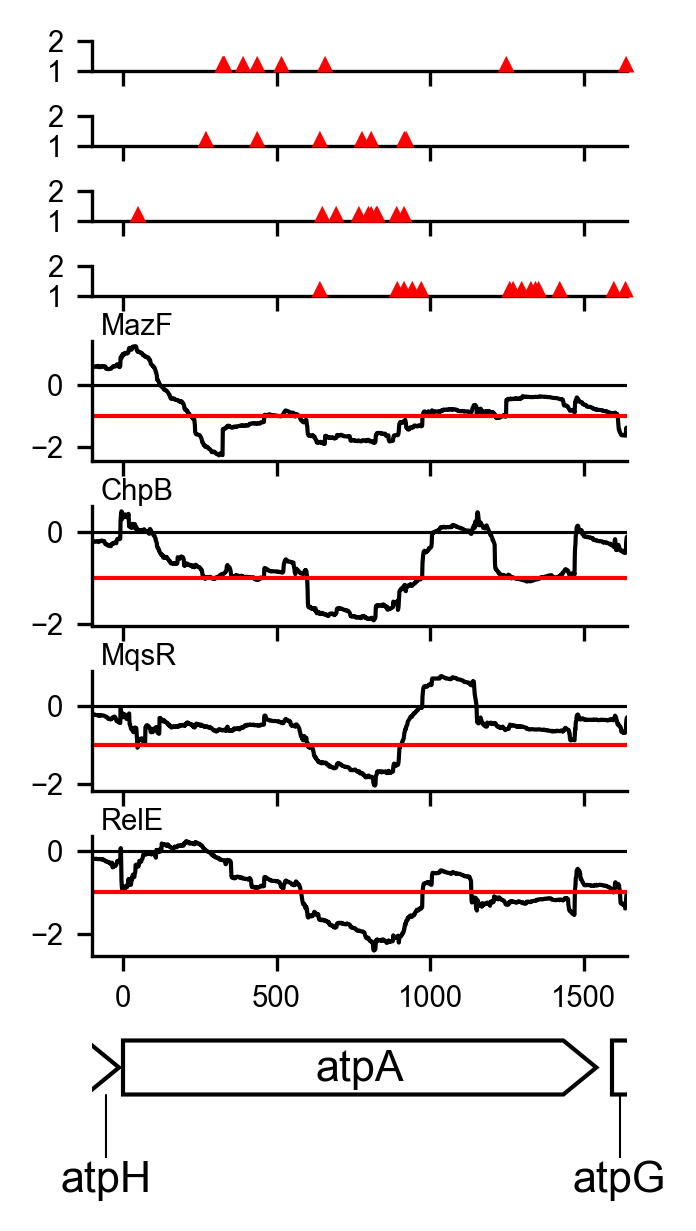

In [21]:
toxins = ['MazF', 'ChpB', 'MqsR', 'RelE']

window = gw.GenomeWindow(gene_table = gene_table, genome = loaded_genbank, gene_name_column='plt_tag',
                         axes_heights = [.1 for i in range(len(toxins))] + [.4 for i in range(len(toxins))] + [.1,.4], fig_width=2.3, show_poi=True,)

window.setpositionbygene(name='atpA', nt_5=100, nt_3=100)

cleavage_ratio_arrays = []
for tox in toxins:
    # size of mask around rRNA regions for count normalization
    rrna_margin = 100
    ### LOAD & NORMALIZE CLEAVAGE RATIO DATA
    # load arrays for peaks
    ctl_arrays, exp_arrays = loadarrays('/home/pculviner/notebook/storage/rnaseq/PCe22_novaseq/ezpool_pipeline/density_numpy_all/',
                                        control_has = ['rz','ev','frg'],
                                        control_not = ['trna', ],
                                        experimental_has = ['rz',tox,'frg'],
                                        experimental_not = ['trna',], verbose = False)
    # generate the rrna mask - these regions will not be included in the calculation of size factors for count normalization
    rrna_regions = gene_table.loc[gene_table.locus_type == 'rRNA',['strand', 'start', 'end']].values.astype(int)
    rrna_regions[:,1] = rrna_regions[:,1] - rrna_margin
    rrna_regions[:,2] = rrna_regions[:,2] + rrna_margin
    rrna_mask = ga.regionstomask(rrna_regions, len(loaded_genbank))
    # normalize the arrays by counts in the non-masked regions 
    normalized_arrays = maskedcountnormalization(np.r_[ctl_arrays,exp_arrays], rrna_mask, pseudo = True)
    # split the arrays back into control and experimental
    ctl_means = np.mean(np.log2(normalized_arrays[:len(ctl_arrays)]),axis=0)
    exp_means = np.mean(np.log2(normalized_arrays[len(ctl_arrays):]),axis=0)
    # calculate a mean ratio across both data sets
    cleavage_ratio_frag = exp_means - ctl_means
    cleavage_ratio_arrays.append(cleavage_ratio_frag)

# plot toxin data streams
for i in range(len(toxins)):
    window.plotdatastreams(axis_n = [len(toxins)+i],
                       input_data = [cleavage_ratio_arrays[i]],
                       color = ['k',],
                       label = [toxins[i]],
                       alpha = 1, rasterize_data=False,
                       stream_type = gw.ArrayAsLine, lw = 1)
    window.axesdata[len(toxins)+i].axhline(0,0,1,lw=.75,c='k')
    legend = window.axesdata[len(toxins)+i].legend(bbox_to_anchor=(-.05, .9), loc='lower left',
                                       borderaxespad=0., fontsize=7, frameon=False, handlelength=0, labelcolor ='linecolor', markerscale=0)
    
    window.axesdata[len(toxins)+i].axhline(-1,0,1,c='r',lw=1)

# plot peaks passing filter
for i in range(len(toxins)):
    window.plotdatastreams(axis_n = [i],
                       input_data = ga.regionstomask(peak_storage[i],len(loaded_genbank)),
                       stream_type = gw.PointsOfInterest,)
    
# move up genome plot slightly
gw.moveaxis(window.ax_sequence,dy=.05)
gw.moveaxis(window.ax_genes,dy=.225)

plt.savefig('figure_outputs/3A_atp_template_switch_valleys_marked.pdf',format='pdf',bbox_inches='tight')

window zero at 3919856, window is not reversed: False
control: rz_5m-ev1.2.1.npy
control: rz_5m-ev2.2.13.npy
experimental: rz_5m-mazf1.2.2.npy
experimental: rz_5m-mazf2.2.14.npy
experimental: rz_5m-chpb1.2.4.npy
experimental: rz_5m-chpb2.2.16.npy
control: rz_5m-ev1.2.1.npy
control: rz_5m-ev2.2.13.npy
control: rz_5m-ev1.2.1.npy
control: rz_5m-ev2.2.13.npy
experimental: rz_5m-mqsr1.2.7.npy
experimental: rz_5m-mqsr2.2.19.npy
control: rz_5m-ev1.2.1.npy
control: rz_5m-ev2.2.13.npy
experimental: rz_5m-rele1.2.3.npy
experimental: rz_5m-rele2.2.15.npy


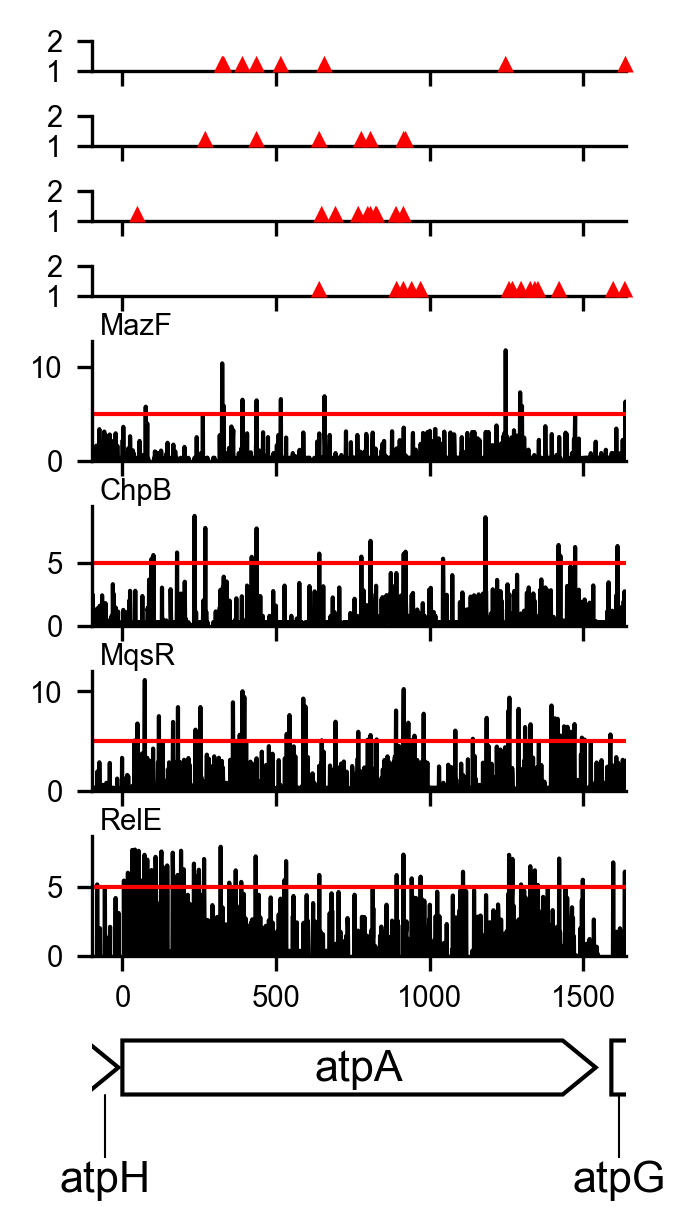

In [22]:
toxins = ['MazF', 'ChpB', 'MqsR', 'RelE']

window = gw.GenomeWindow(gene_table = gene_table, genome = loaded_genbank, gene_name_column='plt_tag',
                         axes_heights = [.1 for i in range(len(toxins))] + [.4 for i in range(len(toxins))] + [.1,.4], fig_width=2.3, show_poi=True,)

window.setpositionbygene(name='atpA', nt_5=100, nt_3=100)

cleavage_ratio_arrays = []
for tox in toxins:
    # size of mask around rRNA regions for count normalization
    rrna_margin = 100
    ### LOAD & NORMALIZE CLEAVAGE RATIO DATA
    # load arrays for peaks
    ctl_arrays, exp_arrays = loadarrays('/home/pculviner/notebook/storage/rnaseq/PCe22_novaseq/ezpool_pipeline/five_prime_numpy_all/',
                                        control_has = ['rz','ev',],
                                        control_not = ['trna','frg'],
                                        experimental_has = ['rz',tox,],
                                        experimental_not = ['trna','frg'], verbose = True)
    # generate the rrna mask - these regions will not be included in the calculation of size factors for count normalization
    rrna_regions = gene_table.loc[gene_table.locus_type == 'rRNA',['strand', 'start', 'end']].values.astype(int)
    rrna_regions[:,1] = rrna_regions[:,1] - rrna_margin
    rrna_regions[:,2] = rrna_regions[:,2] + rrna_margin
    rrna_mask = ga.regionstomask(rrna_regions, len(loaded_genbank))
    # normalize the arrays by counts in the non-masked regions 
    normalized_arrays = maskedcountnormalization(np.r_[ctl_arrays,exp_arrays], rrna_mask, pseudo = True)
    # split the arrays back into control and experimental
    ctl_means = np.mean(np.log2(normalized_arrays[:len(ctl_arrays)]),axis=0)
    exp_means = np.mean(np.log2(normalized_arrays[len(ctl_arrays):]),axis=0)
    # calculate a mean ratio across both data sets - convert back into linear space for lulz
    cleavage_ratio_frag = exp_means - ctl_means
    cleavage_ratio_arrays.append(cleavage_ratio_frag)

# plot toxin data streams
for i in range(len(toxins)):
    window.plotdatastreams(axis_n = [len(toxins)+i],
                       input_data = [cleavage_ratio_arrays[i]],
                       color = ['k',],
                       label = [toxins[i]],
                       alpha = 1, rasterize_data=False,
                       stream_type = gw.ArrayAsLine, lw = 1)
    window.axesdata[len(toxins)+i].axhline(0,0,1,lw=.75,c='k')
    legend = window.axesdata[len(toxins)+i].legend(bbox_to_anchor=(-.05, .9), loc='lower left',
                                       borderaxespad=0., fontsize=7, frameon=False, handlelength=0, labelcolor ='linecolor', markerscale=0)
    # reset limits to cut off negative values
    window.axesdata[len(toxins)+i].set_ylim(0,window.axesdata[len(toxins)+i].get_ylim()[1])
    
    window.axesdata[len(toxins)+i].axhline(np.log2(32),0,1,c='r',lw=1)

# plot peaks passing filter
for i in range(len(toxins)):
    window.plotdatastreams(axis_n = [i],
                       input_data = ga.regionstomask(peak_storage[i],len(loaded_genbank)),
                       stream_type = gw.PointsOfInterest,)
    
# move up genome plot slightly
gw.moveaxis(window.ax_sequence,dy=.05)
gw.moveaxis(window.ax_genes,dy=.225)

plt.savefig('figure_outputs/3B_atp_template_switch_peaks_log_marked.pdf',format='pdf',bbox_inches='tight')

## Figure 3C: Toxin specificities

In [23]:
def normalizebynonrrna(ctl_arrays, exp_arrays, rrna_margin, gene_table):
    # generate the rrna mask - these regions will not be included in the calculation of size factors for count normalization
    rrna_regions = gene_table.loc[gene_table.locus_type == 'rRNA',['strand', 'start', 'end']].values.astype(int)
    rrna_regions[:,1] = rrna_regions[:,1] - rrna_margin
    rrna_regions[:,2] = rrna_regions[:,2] + rrna_margin
    rrna_mask = ga.regionstomask(rrna_regions, len(loaded_genbank))
    # normalize the arrays by counts in the non-masked regions 
    normalized_arrays = maskedcountnormalization(np.r_[ctl_arrays,exp_arrays], rrna_mask, pseudo = True)
    # split the arrays back into control and experimental
    normalized_ctl_arrays = normalized_arrays[:len(ctl_arrays)]
    normalized_exp_arrays = normalized_arrays[len(ctl_arrays):]
    return normalized_ctl_arrays, normalized_exp_arrays

def pullsequence(location, five, three, genome):
    strand, position = location
    if strand == 0:
        return str(genome.seq[position-five:position+three])
    if strand == 1:
        return str(genome.seq[position-three+1:position+five+1].reverse_complement())

paint codon positions on the genome

In [24]:
# load the mg1655 genome
genbank_path = '/home/pculviner/notebook/genomes/mg1655_v3/Ec_mg1655v3.gb'
loaded_genbank = SeqIO.read(genbank_path,'genbank')
# load a gene table csv from the provided path
gene_table_path = '/home/pculviner/notebook/genomes/mg1655_v3/gt_mg1655_v3.csv'
gene_table = pd.read_csv(gene_table_path, index_col=0)

In [25]:
# generate a mask recording the nt position in a coding region
record_counts = np.zeros((2,len(loaded_genbank)))
coding_position_mask = np.zeros((2,len(loaded_genbank))) + np.nan

for r in gene_table.loc[gene_table.locus_type == 'CDS',['strand','start','end']].iterrows():
    gene_name, data = r
    strand, start, end = data.values.astype(int)
    if int(end-start+1)%3 == 0: # only consider coding regions with nt multiples of 3, other cases are fishy
        if strand == 0: # first strand is in the forward direction
            coding_position_mask[strand,start:end+1] = np.arange(end-start+1)%3
        elif strand == 1: # second strand is in the reverse direction
            coding_position_mask[strand,start:end+1] = (np.arange(end-start+1))[::-1]%3
        record_counts[strand,start:end+1] += 1 # mark that we've recorded data at these positions
# remove the few positions that had multiple CDSs mapping and those that were outside of coding regions
coding_position_mask[record_counts > 1] = 4 # code for mutiple possible mappings (due to overlapping CDS), we're going to ignore these
coding_position_mask[record_counts == 0] = 3 # code for no mappings - outside of CDS

paint % through coding regions on the genome

In [26]:
# generate a mask recording the nt position in a coding region
record_counts = np.zeros((2,len(loaded_genbank)))
percent_through_coding_mask = np.zeros((2,len(loaded_genbank))) + np.nan

for r in gene_table.loc[gene_table.locus_type == 'CDS',['strand','start','end']].iterrows():
    gene_name, data = r
    strand, start, end = data.values.astype(int)
    if int(end-start+1)%3 == 0: # only consider coding regions with nt multiples of 3, other cases are fishy
        if strand == 0: # first strand is in the forward direction
            percent_through_coding_mask[strand,start:end+1] = (np.arange(end-start+1)+1) / (end-start+1) * 100
        elif strand == 1: # second strand is in the reverse direction
            percent_through_coding_mask[strand,start:end+1] = (np.arange(end-start+1)+1)[::-1] / (end-start+1) * 100
    record_counts[strand,start:end+1] += 1 # mark that we've recorded data at these positions
# remove the few positions that had multiple CDSs mapping, mask undesireable data to np.nan in this case
percent_through_coding_mask[record_counts > 1] = np.nan
percent_through_coding_mask[record_counts == 0] = np.nan

make a record of coding regions

In [27]:
coding_regions = gene_table.loc[gene_table.locus_type == 'CDS',['strand','start','end']].values

generate plots

MazF: load data...
undefined subcodon positions (due to overlapping CDS): 4


ChpB: load data...
undefined subcodon positions (due to overlapping CDS): 0


HicA: load data...
undefined subcodon positions (due to overlapping CDS): 1


MqsR: load data...
undefined subcodon positions (due to overlapping CDS): 4


RelE: load data...
undefined subcodon positions (due to overlapping CDS): 8


YhaV: load data...
undefined subcodon positions (due to overlapping CDS): 4


HigB: load data...
undefined subcodon positions (due to overlapping CDS): 8


YoeB: load data...
undefined subcodon positions (due to overlapping CDS): 9


YafO: load data...
undefined subcodon positions (due to overlapping CDS): 1




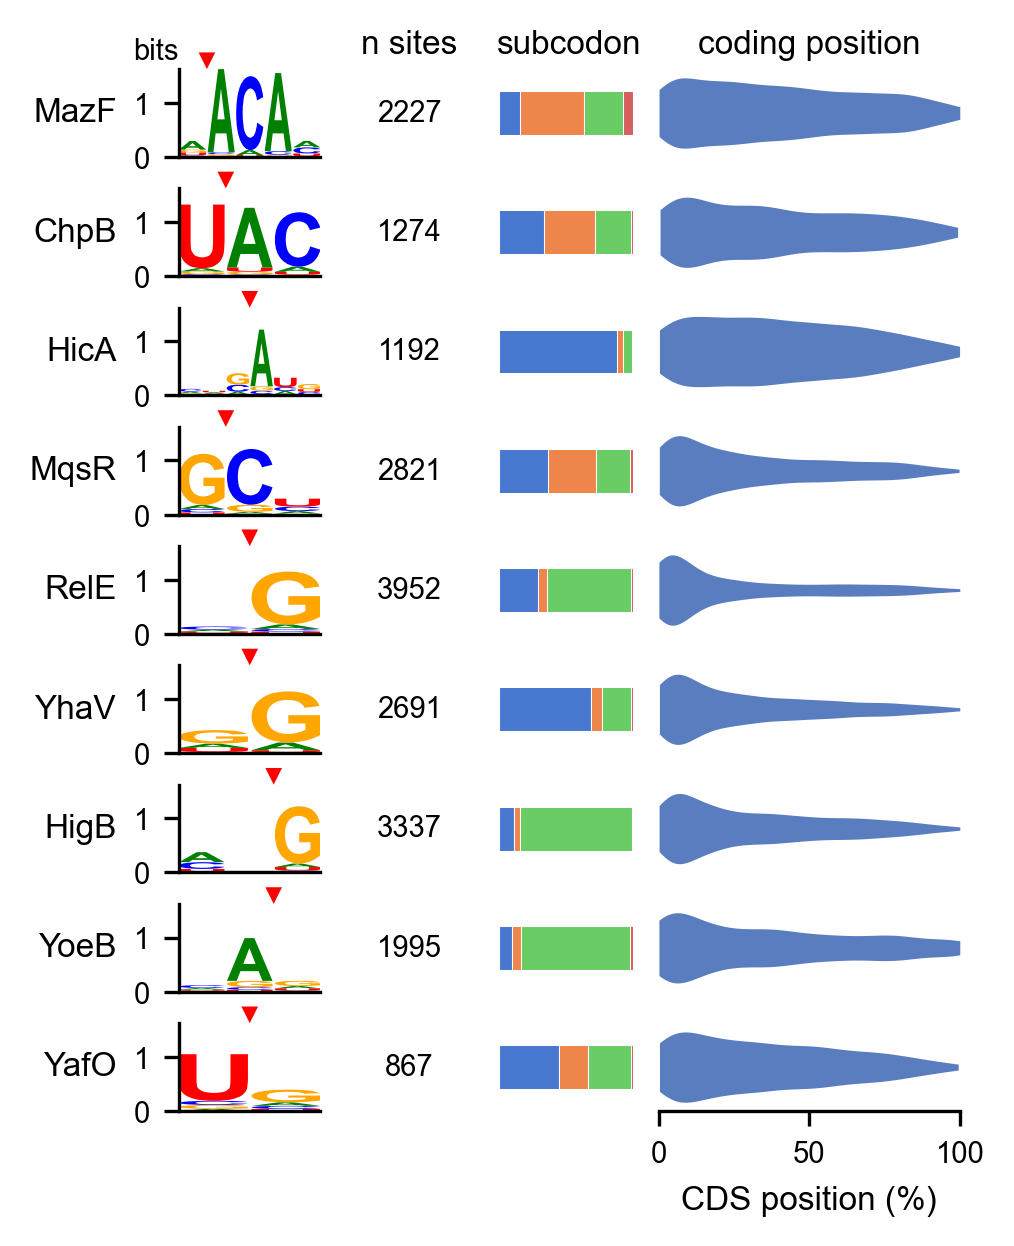

In [28]:
## INPUTS ##
toxin_list = ['MazF', 'ChpB', 'HicA', 'MqsR', 'RelE', 'YhaV', 'HigB', 'YoeB', 'YafO']
rrna_margin = 100
end_threshold = np.log2(32)
cr_region = (10,0)
exp_threshold = 6.
cr_threshold = -1
information_threshold = 0.05
subcodon_colors = sns.color_palette('muted',4)
subcodon_labels = ['subcodon 1', 'subcodon 2', 'subcodon 3', 'non-coding']

############
toxin_list = toxin_list[:]

# prepare gridspec for holding and organizing data
## plot figures
fig = plt.figure(constrained_layout=False, figsize=(3.25,len(toxin_list)*.4+.425))
# make a gridspec and assign axes
gridspec  = fig.add_gridspec(ncols=5, nrows=(len(toxin_list)))
logo_axes = [fig.add_subplot(gridspec[i,0]) for i in range(len(toxin_list))]
info_axes = [fig.add_subplot(gridspec[i,1]) for i in range(len(toxin_list))]
[(ax.set_frame_on(False), ax.axes.get_xaxis().set_visible(False), plt.setp(ax.get_xticklabels(),visible=False),ax.axes.get_yaxis().set_visible(False)) for ax in info_axes]
subcodon_axes = [fig.add_subplot(gridspec[i,2]) for i in range(len(toxin_list))]
[(ax.set_frame_on(False), ax.axes.get_xaxis().set_visible(False), plt.setp(ax.get_xticklabels(),visible=False),ax.axes.get_yaxis().set_visible(False)) for ax in subcodon_axes]
coding_position_axes = [fig.add_subplot(gridspec[i,3:5]) for i in range(len(toxin_list))]
[(ax.set_frame_on(False), ax.axes.get_xaxis().set_visible(False), plt.setp(ax.get_xticklabels(),visible=False),ax.axes.get_yaxis().set_visible(False)) for ax in coding_position_axes[:-1]]

# load the mg1655 genome
genbank_path = '/home/pculviner/notebook/genomes/mg1655_v3/Ec_mg1655v3.gb'
loaded_genbank = SeqIO.read(genbank_path,'genbank')
# load a gene table csv from the provided path
gene_table_path = '/home/pculviner/notebook/genomes/mg1655_v3/gt_mg1655_v3.csv'
gene_table = pd.read_csv(gene_table_path, index_col=0)
# storage arrays for things that need be handleded at the end
logo_extents = []
for i,toxin_name in enumerate(toxin_list):
    print('%s: load data...'%toxin_name)
    # load end sequencing arrays
    end_ctl_arrays, end_exp_arrays = loadarrays('/home/pculviner/notebook/storage/rnaseq/PCe22_novaseq/ezpool_pipeline/five_prime_numpy_all/',
                                                control_has = ['rz','ev'], control_not = ['trna','frg'],
                                                experimental_has = ['rz',toxin_name], experimental_not = ['trna','frg'], verbose = False)
    end_ctl_arrays, end_exp_arrays = normalizebynonrrna(end_ctl_arrays, end_exp_arrays, rrna_margin, gene_table)
    tswitch_end_mapping = np.mean(np.log2(end_exp_arrays),axis=0) - np.mean(np.log2(end_ctl_arrays),axis=0)
    
    # load fragmented arrays
    density_ctl_arrays, density_exp_arrays = loadarrays('/home/pculviner/notebook/storage/rnaseq/PCe22_novaseq/ezpool_pipeline/density_numpy_all/',
                                                         control_has = ['rz','ev','frg'], control_not = ['trna',],
                                                         experimental_has = ['rz',toxin_name,'frg'], experimental_not = ['trna',], verbose = False)
    density_ctl_arrays, density_exp_arrays = normalizebynonrrna(density_ctl_arrays, density_exp_arrays, rrna_margin, gene_table)
    mean_ctl_density = np.mean(np.log2(density_ctl_arrays),axis=0)
    tswitch_cleavage_ratio = np.mean(np.log2(density_exp_arrays),axis=0) - np.mean(np.log2(density_ctl_arrays),axis=0)
    
    # identify peaks
    meets_end_threshold = np.asarray(np.where(tswitch_end_mapping >= end_threshold)).T
    # convert to region format [strand, start, end] where start == end
    toxin_peaks = np.c_[meets_end_threshold,meets_end_threshold[:,1:2]]
    # verify that:
    # 1. nearby region is expressed to make a cleavage call 
    meets_exp_threshold = np.asarray(ga.regionfunc(np.min, toxin_peaks, mean_ctl_density, addl_nt=cr_region)) >= exp_threshold
    # 2. cleavage meets required threshold
    meets_cr_threshold = np.asarray(ga.regionfunc(np.min, toxin_peaks, tswitch_cleavage_ratio, addl_nt=cr_region)) <= cr_threshold
    # get filtered peaks
    peaks_pass_filter = toxin_peaks[np.all([meets_exp_threshold,meets_cr_threshold], axis=0)]
    # get sequence counts in onehot format
    nt_counts = np.asarray([ga.dnatoonehot(pullsequence(location,6,6,loaded_genbank)) for location in peaks_pass_filter[:,:2]]).sum(0)
    
    # plot logo
    # get sites with more information than the threshold
    meet_info_threshold = np.max(lm.transform_matrix(pd.DataFrame(data=nt_counts), from_type='counts', to_type='information').values,axis=1) >= information_threshold
    motif_extent = [np.where(meet_info_threshold)[0][0], np.where(meet_info_threshold)[0][-1]]
    # draw the logo
    logo = lm.Logo(lm.transform_matrix(pd.DataFrame(data=nt_counts[motif_extent[0]:motif_extent[1]+1,:], columns = ['A','U','G','C']), from_type='counts', to_type='information'),
            font_name = 'Arial', ax = logo_axes[i],)
    logo.style_spines(spines=['right','top'], visible=False)
    logo.ax.set_xticks([])
    logo_axes[i].set_ylabel(toxin_name, rotation=0, ha='right',va='center')
    logo_extents.append(motif_extent)
    # print information on a hidden axis
    info_axes[i].text(0.5,0.5,'%i'%len(peaks_pass_filter), transform=info_axes[i].transAxes, ha='center',va='center',fontsize=7)
    
    # plot subcodon postions
    subcodon_position = coding_position_mask[tuple(peaks_pass_filter[:,:2].T)]
    subcodon_counts = np.asarray([np.sum(subcodon_position == 0), np.sum(subcodon_position == 1), np.sum(subcodon_position == 2), np.sum(subcodon_position == 3)])
    print('undefined subcodon positions (due to overlapping CDS): %i'%np.sum(subcodon_position == 4))
    subcodon_percents = (subcodon_counts/subcodon_counts.sum())*100
    
    subcodon_axes[i].barh(.25,height=.5, width=subcodon_percents, left=np.cumsum(subcodon_percents) - subcodon_percents,
                          color=subcodon_colors, align='edge', zorder=0, edgecolor='white',linewidth=.25)
    subcodon_axes[i].set_ylim(0,1)
    
    # plot percent through coding regions
    coding_percent_through = percent_through_coding_mask[tuple(peaks_pass_filter[:,:2].T)]
    sns.violinplot(x=coding_percent_through, cut=0, palette = 'muted', ax = coding_position_axes[i], inner=None, linewidth=0)
    coding_position_axes[i].set_xlim(0,100)    
    print('\n')
    

logo_axes[0].text(0,1.05,'bits', transform=logo_axes[0].transAxes, ha='right',va='bottom',fontsize=7)
info_axes[0].text(.5,1.1,'n sites', transform=info_axes[0].transAxes, ha='center',va='bottom',fontsize=8)
subcodon_axes[0].text(.5,1.1,'subcodon', transform=subcodon_axes[0].transAxes, ha='center',va='bottom',fontsize=8)
# tweak coding position data
coding_position_axes[0].text(.5,1.1,'coding position', transform=coding_position_axes[0].transAxes, ha='center',va='bottom',fontsize=8)
sns.despine(ax=coding_position_axes[-1],bottom=False,left=True)
coding_position_axes[-1].set_yticks([])
coding_position_axes[-1].set_xticks([0,50,100])
coding_position_axes[-1].set_xlabel('CDS position (%)')
# make some modifications to logo axes 
logo_axes_maximum = np.max([ax.get_ylim()[1] for ax in logo_axes])
for ax,motif_extent in zip(logo_axes,logo_extents):
    ax.set_ylim(0,logo_axes_maximum)
    ax.annotate('',(6-motif_extent[0]-.5,ax.get_ylim()[1]), (6-motif_extent[0]-.5,ax.get_ylim()[1]+.05) ,
                 arrowprops={'width':0,'headwidth':4,'headlength':4,'facecolor':'r','edgecolor':'None'}) 
gridspec.tight_layout(fig,pad=.25)
plt.savefig('figure_outputs/3C_cleavage_specificty.pdf',format='pdf',bbox_inches='tight')

## Figure S3 Cleavage Site Overlap

In [29]:
def normalizebynonrrna(ctl_arrays, exp_arrays, rrna_margin, gene_table):
    # generate the rrna mask - these regions will not be included in the calculation of size factors for count normalization
    rrna_regions = gene_table.loc[gene_table.locus_type == 'rRNA',['strand', 'start', 'end']].values.astype(int)
    rrna_regions[:,1] = rrna_regions[:,1] - rrna_margin
    rrna_regions[:,2] = rrna_regions[:,2] + rrna_margin
    rrna_mask = ga.regionstomask(rrna_regions, len(loaded_genbank))
    # normalize the arrays by counts in the non-masked regions 
    normalized_arrays = maskedcountnormalization(np.r_[ctl_arrays,exp_arrays], rrna_mask, pseudo = True)
    # split the arrays back into control and experimental
    normalized_ctl_arrays = normalized_arrays[:len(ctl_arrays)]
    normalized_exp_arrays = normalized_arrays[len(ctl_arrays):]
    return normalized_ctl_arrays, normalized_exp_arrays

def pullsequence(location, five, three, genome):
    strand, position = location
    if strand == 0:
        return str(genome.seq[position-five:position+three])
    if strand == 1:
        return str(genome.seq[position-three+1:position+five+1].reverse_complement())

paint codon positions on the genome

In [30]:
# load the mg1655 genome
genbank_path = '/home/pculviner/notebook/genomes/mg1655_v3/Ec_mg1655v3.gb'
loaded_genbank = SeqIO.read(genbank_path,'genbank')
# load a gene table csv from the provided path
gene_table_path = '/home/pculviner/notebook/genomes/mg1655_v3/gt_mg1655_v3.csv'
gene_table = pd.read_csv(gene_table_path, index_col=0)

In [31]:
# generate a mask recording the nt position in a coding region
record_counts = np.zeros((2,len(loaded_genbank)))
coding_position_mask = np.zeros((2,len(loaded_genbank))) + np.nan

for r in gene_table.loc[gene_table.locus_type == 'CDS',['strand','start','end']].iterrows():
    gene_name, data = r
    strand, start, end = data.values.astype(int)
    if int(end-start+1)%3 == 0: # only consider coding regions with nt multiples of 3, other cases are fishy
        if strand == 0: # first strand is in the forward direction
            coding_position_mask[strand,start:end+1] = np.arange(end-start+1)
        elif strand == 1: # second strand is in the reverse direction
            coding_position_mask[strand,start:end+1] = (np.arange(end-start+1))[::-1]
        record_counts[strand,start:end+1] += 1 # mark that we've recorded data at these positions
# remove the few positions that had multiple CDSs mapping, mask undesireable data to np.nan in this case
coding_position_mask[record_counts > 1] = np.nan
coding_position_mask[record_counts == 0] = np.nan

### Site -> U^ACA

In [32]:
site_loc = getmotifsites('TACA', onehot_genome)
# modify site locations to account for offset of +1
offset = 1
site_loc[site_loc[:,0] == 0, 1] = site_loc[site_loc[:,0] == 0, 1] + offset
site_loc[site_loc[:,0] == 1, 1] = site_loc[site_loc[:,0] == 1, 1] - offset
# next


## INPUTS ##
toxin_list = ['MazF', 'ChpB']
rrna_margin = 100
cr_region = (10,0)
information_threshold = 0.025

expression_values = []
end_ratios = []
cleavage_ratios = []
# iterate across the toxin list
for i,toxin_name in enumerate(toxin_list):
    print('%s: load data...'%toxin_name)
    # load end sequencing arrays
    end_ctl_arrays, end_exp_arrays = loadarrays('/home/pculviner/notebook/storage/rnaseq/PCe22_novaseq/ezpool_pipeline/five_prime_numpy_all/',
                                                control_has = ['rz','ev'], control_not = ['trna','frg'],
                                                experimental_has = ['rz',toxin_name], experimental_not = ['trna','frg'], verbose = False)
    end_ctl_arrays, end_exp_arrays = normalizebynonrrna(end_ctl_arrays, end_exp_arrays, rrna_margin, gene_table)
    tswitch_end_mapping = np.mean(np.log2(end_exp_arrays),axis=0) - np.mean(np.log2(end_ctl_arrays),axis=0)
    
    # load fragmented arrays
    density_ctl_arrays, density_exp_arrays = loadarrays('/home/pculviner/notebook/storage/rnaseq/PCe22_novaseq/ezpool_pipeline/density_numpy_all/',
                                                         control_has = ['rz','ev','frg'], control_not = ['trna',],
                                                         experimental_has = ['rz',toxin_name,'frg'], experimental_not = ['trna',], verbose = False)
    density_ctl_arrays, density_exp_arrays = normalizebynonrrna(density_ctl_arrays, density_exp_arrays, rrna_margin, gene_table)
    mean_ctl_density = np.mean(np.log2(density_ctl_arrays),axis=0)
    tswitch_cleavage_ratio = np.mean(np.log2(density_exp_arrays),axis=0) - np.mean(np.log2(density_ctl_arrays),axis=0)
    
    # save data to arrays
    expression_values.append(mean_ctl_density[tuple(site_loc.T)])
    end_ratios.append(tswitch_end_mapping[tuple(site_loc.T)])
    cleavage_ratios.append(tswitch_cleavage_ratio[tuple(site_loc.T)])

MazF: load data...
ChpB: load data...


In [33]:
min_exp_values = np.min(np.asarray(expression_values),0)
columns = ['strand','pos','exp'] + [j+i for i in ['_end', '_cr'] for j in toxin_list]
comparison_table = pd.DataFrame(columns=columns, data = np.c_[site_loc, np.asarray([min_exp_values]).T,np.asarray(end_ratios).T, np.asarray(cleavage_ratios).T])

In [34]:
expression_threshold = 6.
end_ratio_threshold = np.log2(10)
cleavage_ratio_threshold = -1

# slice and dice the table
expressed_mask = comparison_table.loc[:,'exp'] >= expression_threshold
# cleavage
mazf_mask = np.all([comparison_table.loc[:,'MazF_end'] >= end_ratio_threshold, comparison_table.loc[:,'MazF_cr'] <= cleavage_ratio_threshold],0)
chpb_mask = np.all([comparison_table.loc[:,'ChpB_end'] >= end_ratio_threshold, comparison_table.loc[:,'ChpB_cr'] <= cleavage_ratio_threshold],0)
both_mask = np.all([mazf_mask,chpb_mask],0)
print('both: %i'%np.all([both_mask,expressed_mask],0).sum())
print('mazf only: %i'%np.all([mazf_mask,~chpb_mask,expressed_mask],0).sum())
print('chpb only: %i'%np.all([~mazf_mask,chpb_mask,expressed_mask],0).sum())
print('neither: %i'%np.all([~mazf_mask,~chpb_mask,expressed_mask],0).sum())

both: 121
mazf only: 319
chpb only: 267
neither: 3802


maximum value: 62


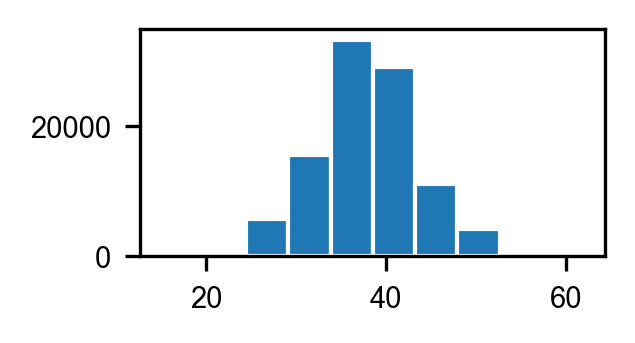

In [35]:
n_both = []
for i in range(100000):
    mazf_choice = np.random.choice(np.arange(4509),size=319+121,replace=False)
    mazf_mask = np.zeros(4509).astype(bool)
    mazf_mask[mazf_choice] = True
    chpb_choice = np.random.choice(np.arange(4509),size=267+121,replace=False)
    chpb_mask = np.zeros(4509).astype(bool)
    chpb_mask[chpb_choice] = True
    n_both.append(np.all([mazf_mask,chpb_mask],0).sum())
plt.subplots(1,figsize=(2,1))
plt.gca().hist(n_both)
print('maximum value: %i'%np.max(n_both))

### Site -> ^G (3)

In [36]:
site_loc = getmotifsites('G', onehot_genome)
# modify site locations to account for offset of +1
offset = 0
site_loc[site_loc[:,0] == 0, 1] = site_loc[site_loc[:,0] == 0, 1] + offset
site_loc[site_loc[:,0] == 1, 1] = site_loc[site_loc[:,0] == 1, 1] - offset
# add codon position requirement to site_loc
site_loc = site_loc[(coding_position_mask%3)[tuple(site_loc.T)] == 2]


## INPUTS ##
toxin_list = ['RelE', 'HigB']
rrna_margin = 100
cr_region = (10,0)
information_threshold = 0.025

expression_values = []
end_ratios = []
cleavage_ratios = []
# iterate across the toxin list
for i,toxin_name in enumerate(toxin_list):
    print('%s: load data...'%toxin_name)
    # load end sequencing arrays
    end_ctl_arrays, end_exp_arrays = loadarrays('/home/pculviner/notebook/storage/rnaseq/PCe22_novaseq/ezpool_pipeline/five_prime_numpy_all/',
                                                control_has = ['rz','ev'], control_not = ['trna','frg'],
                                                experimental_has = ['rz',toxin_name], experimental_not = ['trna','frg'], verbose = False)
    end_ctl_arrays, end_exp_arrays = normalizebynonrrna(end_ctl_arrays, end_exp_arrays, rrna_margin, gene_table)
    tswitch_end_mapping = np.mean(np.log2(end_exp_arrays),axis=0) - np.mean(np.log2(end_ctl_arrays),axis=0)
    
    # load fragmented arrays
    density_ctl_arrays, density_exp_arrays = loadarrays('/home/pculviner/notebook/storage/rnaseq/PCe22_novaseq/ezpool_pipeline/density_numpy_all/',
                                                         control_has = ['rz','ev','frg'], control_not = ['trna',],
                                                         experimental_has = ['rz',toxin_name,'frg'], experimental_not = ['trna',], verbose = False)
    density_ctl_arrays, density_exp_arrays = normalizebynonrrna(density_ctl_arrays, density_exp_arrays, rrna_margin, gene_table)
    mean_ctl_density = np.mean(np.log2(density_ctl_arrays),axis=0)
    tswitch_cleavage_ratio = np.mean(np.log2(density_exp_arrays),axis=0) - np.mean(np.log2(density_ctl_arrays),axis=0)
    
    # save data to arrays
    expression_values.append(mean_ctl_density[tuple(site_loc.T)])
    end_ratios.append(tswitch_end_mapping[tuple(site_loc.T)])
    cleavage_ratios.append(tswitch_cleavage_ratio[tuple(site_loc.T)])

<ipython-input-36-25db859dfd64>:7: RuntimeWarning: invalid value encountered in remainder
  site_loc = site_loc[(coding_position_mask%3)[tuple(site_loc.T)] == 2]


RelE: load data...
HigB: load data...


In [37]:
min_exp_values = np.min(np.asarray(expression_values),0)
columns = ['strand','pos','exp'] + [j+i for i in ['_end', '_cr'] for j in toxin_list]
comparison_table = pd.DataFrame(columns=columns, data = np.c_[site_loc, np.asarray([min_exp_values]).T,np.asarray(end_ratios).T, np.asarray(cleavage_ratios).T])

In [38]:
expression_threshold = 6.
end_ratio_threshold = np.log2(10)
cleavage_ratio_threshold = -1

# slice and dice the table
expressed_mask = comparison_table.loc[:,'exp'] >= expression_threshold
# cleavage
rele_mask = np.all([comparison_table.loc[:,'RelE_end'] >= end_ratio_threshold, comparison_table.loc[:,'RelE_cr'] <= cleavage_ratio_threshold],0)
higb_mask = np.all([comparison_table.loc[:,'HigB_end'] >= end_ratio_threshold, comparison_table.loc[:,'HigB_cr'] <= cleavage_ratio_threshold],0)
both_mask = np.all([rele_mask,higb_mask],0)
print('both: %i'%np.all([both_mask,expressed_mask],0).sum())
print('rele only: %i'%np.all([rele_mask,~higb_mask,expressed_mask],0).sum())
print('higb only: %i'%np.all([~rele_mask,higb_mask,expressed_mask],0).sum())
print('neither: %i'%np.all([~rele_mask,~higb_mask,expressed_mask],0).sum())

both: 879
rele only: 2593
higb only: 3158
neither: 171224


maximum value: 113


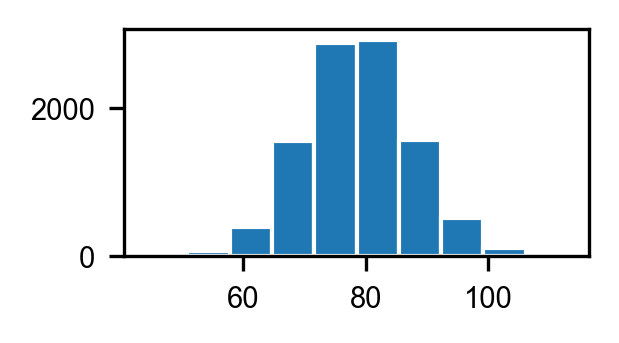

In [39]:
total = 171224 + 3158 + 2593 + 879

n_both = []
for i in range(10000):
    mazf_choice = np.random.choice(np.arange(total),size=2593+879,replace=False)
    mazf_mask = np.zeros(total).astype(bool)
    mazf_mask[mazf_choice] = True
    chpb_choice = np.random.choice(np.arange(total),size=3158+879,replace=False)
    chpb_mask = np.zeros(total).astype(bool)
    chpb_mask[chpb_choice] = True
    n_both.append(np.all([mazf_mask,chpb_mask],0).sum())
plt.subplots(1,figsize=(2,1))
plt.gca().hist(n_both)
print('maximum value: %i'%np.max(n_both))

generate plots

# Figure 4

## Figure 4A: tRNA control plot

In [40]:
from matplotlib.ticker import MultipleLocator,ScalarFormatter,FuncFormatter

def pullsequence(location, five, three, genome):
    strand, position = location
    if strand == 0:
        return str(genome.seq[position-five:position+three])
    if strand == 1:
        return str(genome.seq[position-three+1:position+five+1].reverse_complement())
    
def muscleAlign(names, sequences):
    # write a temporary fasta file for muscle to read / align
    writeFasta('_temp.fasta', names, sequences)
    # conduct a muscle alignment on the temporary fasta
    subprocess.call(['muscle','-in','_temp.fasta','-out','_temp_aligned.fasta'])
    # import alignments back into python
    names, sequences = readFasta('_temp_aligned.fasta',True)
    # clean up temporary file
    os.remove('_temp.fasta')
    return names, sequences

def writeFasta(filepath, names, sequences):
    # accepts list of names (spaces will be replaced with underscores) and list of sequences, writes to filepath
    with open(filepath,'w') as f:
        for n,seq in zip(names,sequences):
            f.write('>%s\n%s\n'%(n.replace(' ','_'),str(seq)))
    return filepath

def readFasta(filepath, delete=False):
    # returns names and records
    with open(filepath,'r') as f:
        lines = f.readlines()
        # now take out the records
        records = []
        names = []
        current_record = ''
        for line in lines:
            if line[0] == '>':
                names.append(line[1:-1])
                records.append(current_record)
                current_record = ''
            else:
                current_record += line[:-1]
        records.append(current_record)
        names = np.asarray(names)
        records = np.asarray(records[1:])
    if delete: # burn after reading
        os.remove(filepath)
    return names, records

def pullindexdata(target_indexes, alignment_mask, input_data, function = lambda x: x):
    return [function(input_data[alignment_mask == i]) for i in target_indexes]

def normalizebytrnaregions_ctl(input_arrays, trna_margin, gene_table, genome, pseudo = False):
    # generate the rrna mask - these regions will not be included in the calculation of size factors for count normalization
    trna_regions = gene_table.loc[gene_table.locus_type == 'tRNA',['strand', 'start', 'end']].values.astype(int)
    trna_regions[:,1] = trna_regions[:,1] - trna_margin
    trna_regions[:,2] = trna_regions[:,2] + trna_margin
    trna_mask = ~ga.regionstomask(trna_regions, len(genome)) # inverse mask, we only want to use tRNA regions here
    # normalize the arrays by counts in the non-masked regions 
    normalized_arrays = maskedcountnormalization(input_arrays, trna_mask, pseudo = pseudo)
    return normalized_arrays

print_alignments = False
upstream_nt = 4
downstream_nt = 4

# load the mg1655 genome
genbank_path = '/home/pculviner/notebook/genomes/mg1655_v3/Ec_mg1655v3.gb'
loaded_genbank = SeqIO.read(genbank_path,'genbank')
# load a gene table csv from the provided path
gene_table_path = '/home/pculviner/notebook/genomes/mg1655_v3/gt_mg1655_v3.csv'
gene_table = pd.read_csv(gene_table_path, index_col=0)

# pull tRNA sequences from the genome
trna_names = []
trna_sequences = []
for gene,strand,start,end in gene_table.loc[gene_table.locus_type == 'tRNA', ['gene','strand','start','end']].values:
    if strand == 0:
        sequence = pullsequence([strand,start], 0, end-start+1, loaded_genbank)
    if strand == 1:
        sequence = pullsequence([strand,end], 0, end-start+1, loaded_genbank)
    if len(sequence) <= 77 and gene != 'hisR':
        trna_names.append(gene)
        trna_sequences.append(sequence)
# align the sequences
names, alignments = muscleAlign(trna_names, trna_sequences)
# print alignment with ruler if desired
if print_alignments is True:
    for n,a in zip(names,alignments):
        print(n)
        print('1   5    10   15   20   25   30   35')
        print(' |||||||  ||||         |||| |||||  W21')
        print(a)
# convert the alignments into a character array
alignments_array = np.asarray([list(a) for a in alignments])
label_array = np.asarray(names)

In [41]:
## paint the alignment positions on the genome
# generate a mask with np.nan at every position
alignment_mask = np.zeros((2,len(loaded_genbank)))+np.nan
# generate an array index including every position in the alignment
global_array_index = np.arange(len(alignments_array[0]))
# generate a count of positions at each array index
index_record = []
# iterate across the alignments we've made
for gene,strand,start,end in gene_table.loc[gene_table.loc[:,'gene'].isin(label_array), ['gene','strand','start','end']].values:
    # pull gene from list of alignments          
    a_array = alignments_array[label_array == gene][0]
    # calculate indexes to paint onto genome
    indexes_to_paint = np.asarray([i for i, base in enumerate(a_array) if base != '-'])
    last_nt = indexes_to_paint[-1]
    # modify list to include upstream and downstream bases
    indexes_to_paint = np.r_[np.arange(upstream_nt),
                             indexes_to_paint+upstream_nt,
                             np.arange(downstream_nt)+indexes_to_paint[-1]+upstream_nt+1]
    index_record = np.r_[index_record,indexes_to_paint]
    # paint this alignment onto the genome
    if strand == 0:
        alignment_mask[0,start-upstream_nt:end+1+downstream_nt] = indexes_to_paint
    elif strand == 1:
        alignment_mask[1,start-downstream_nt:end+1+upstream_nt] = indexes_to_paint[::-1]


# global_array_index_counts = np.sum(alignments_array != '-',0)
## error checking ##
# # check alignment mask
# for i in global_array_index:
#     print('%i:%s'%(i,''.join([pullsequence(location, 0, 1, loaded_genbank) for location in np.asarray(np.where(alignment_mask == i)).T])))
####################

In [42]:
global_array_index

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77])

In [43]:
end5_ctl_arrays, _ = loadarrays('/home/pculviner/notebook/storage/rnaseq/PCe22_novaseq/ezpool_pipeline/five_prime_numpy_all/',
                                                control_has = ['rz','ev','trna'], control_not = ['frg'],
                                                experimental_has = ['null'], experimental_not = [], verbose = True)

end5_ctl_arrays = normalizebytrnaregions_ctl(end5_ctl_arrays, 100, gene_table, loaded_genbank, pseudo = False)

end3_ctl_arrays, _ = loadarrays('/home/pculviner/notebook/storage/rnaseq/PCe22_novaseq/ezpool_pipeline/three_prime_numpy_all/',
                                                control_has = ['rz','ev','trna'], control_not = ['frg'],
                                                experimental_has = ['null'], experimental_not = [], verbose = True)

end3_ctl_arrays = normalizebytrnaregions_ctl(end3_ctl_arrays, 100, gene_table, loaded_genbank, pseudo = False)

density_ctl_arrays, _ = loadarrays('/home/pculviner/notebook/storage/rnaseq/PCe22_novaseq/ezpool_pipeline/density_numpy_all//',
                                                control_has = ['rz','ev','trna'], control_not = ['frg'],
                                                experimental_has = ['null'], experimental_not = [], verbose = True)

density_ctl_arrays = normalizebytrnaregions_ctl(density_ctl_arrays, 100, gene_table, loaded_genbank, pseudo = False)

control: rz_5m_trna-ev1.5.1.npy
control: rz_5m_trna-ev2.5.13.npy
control: rz_5m_trna-ev1.5.1.npy
control: rz_5m_trna-ev2.5.13.npy
control: rz_5m_trna-ev1.5.1.npy
control: rz_5m_trna-ev2.5.13.npy


window zero at 4, window is not reversed: True


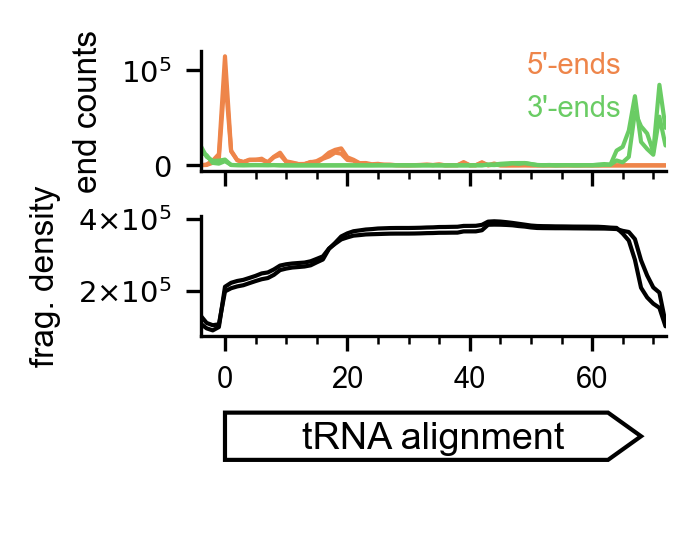

In [44]:
four_color = sns.color_palette('muted',4)

# for pulling from the genome
target_indexes, index_counts = np.unique(index_record,return_counts=True)
target_indexes = target_indexes[index_counts == np.max(index_counts)]

# gene alignment length
gene_alignment_length = len(target_indexes) - upstream_nt - downstream_nt

# plot x values
x_values = np.r_[np.arange(upstream_nt) - upstream_nt, np.arange(gene_alignment_length), np.arange(downstream_nt) + gene_alignment_length]

# generate a plot of tRNA 5'-ends
trna_gene_table = pd.DataFrame(columns=['strand', 'start', 'end', 'plt_tag'],
                               data=[[0, upstream_nt, gene_alignment_length + upstream_nt - 1, 'tRNA alignment']])

window = gw.GenomeWindow(gene_table = trna_gene_table, genome = '-'*len(target_indexes), gene_name_column='plt_tag', axes_heights = [.4,.4,.35], fig_width=2,)

window.setpositionbygene(name='tRNA alignment', nt_5=4, nt_3=4)

window.axesdata[0].plot(x_values, np.asarray(pullindexdata(target_indexes, alignment_mask, end5_ctl_arrays[0], function = np.sum)),
                        c=four_color[1], lw=1, label="5'-ends")
window.axesdata[0].plot(x_values, np.asarray(pullindexdata(target_indexes, alignment_mask, end5_ctl_arrays[1], function = np.sum)),
                        c=four_color[1], lw=1)

window.axesdata[0].plot(x_values, pullindexdata(target_indexes, alignment_mask, end3_ctl_arrays[0], function = np.sum),
                        c=four_color[2], lw=1, label="3'-ends")
window.axesdata[0].plot(x_values, pullindexdata(target_indexes, alignment_mask, end3_ctl_arrays[1], function = np.sum),
                        c=four_color[2], lw=1)

window.axesdata[1].plot(x_values, np.asarray(pullindexdata(target_indexes, alignment_mask, density_ctl_arrays[0], function = np.sum)),
                        c='k', lw=1)
window.axesdata[1].plot(x_values, np.asarray(pullindexdata(target_indexes, alignment_mask, density_ctl_arrays[1], function = np.sum)),
                        c='k', lw=1)

# set all data axes to match gene axis
# set linear range and scientific notation for y axes
f = ScalarFormatter(useOffset=False, useMathText=True)
g = lambda x,pos : "${}$".format(f._formatSciNotation('%1.10e'%x))
[ax.yaxis.set_major_formatter(FuncFormatter(g)) for ax in window.axesdata]
# set x limits to the same for each plot
[ax.set_xlim(window.ax_genes.get_xlim()) for ax in window.axesdata]
# set x axes formatters
[ax.xaxis.set_major_locator(MultipleLocator(20)) for ax in window.axesdata]
[ax.xaxis.set_minor_locator(MultipleLocator(5)) for ax in window.axesdata]
# add a legend to top axis
legend = window.axesdata[0].legend(bbox_to_anchor=(.93, 1.09), loc='upper right', borderaxespad=0., fontsize=7, frameon=False, handlelength=0, labelcolor ='linecolor', markerscale=0)
# add y-yabels
window.axesdata[0].set_ylabel('end counts')
window.axesdata[1].set_ylabel('frag. density')

plt.savefig('figure_outputs/4A_trna_alignments.pdf',format='pdf',bbox_inches='tight')

## Figure 4B: tRNA examples

In [45]:
from matplotlib.ticker import MultipleLocator,ScalarFormatter,FuncFormatter

def normalizebytrnaregions_samples(ctl_arrays, exp_arrays, trna_margin, gene_table, genome, pseudo = False):
    # generate the rrna mask - these regions will not be included in the calculation of size factors for count normalization
    trna_regions = gene_table.loc[gene_table.locus_type == 'tRNA',['strand', 'start', 'end']].values.astype(int)
    trna_regions[:,1] = trna_regions[:,1] - trna_margin
    trna_regions[:,2] = trna_regions[:,2] + trna_margin
    trna_mask = ~ga.regionstomask(trna_regions, len(genome)) # inverse mask, we only want to use tRNA regions here
    # normalize the arrays by counts in the non-masked regions
    normalized_arrays = maskedcountnormalization(np.r_[ctl_arrays,exp_arrays], trna_mask, pseudo = pseudo)
    # split the arrays back into control and experimental
    normalized_ctl_arrays = normalized_arrays[:len(ctl_arrays)]
    normalized_exp_arrays = normalized_arrays[len(ctl_arrays):]
    return normalized_ctl_arrays, normalized_exp_arrays

def moveaxis(ax, dx=0, dy=0):
    # where x and y are in inches on final figure
    fig = ax.get_figure()
    ax_coor = ax.get_position()
    dx = dx / fig.get_figwidth() # convert to figure coordinates
    dy = dy / fig.get_figheight() #  .5 = 2 1 # .25  = 2 .5
    ax.set_position([ax_coor.x0+dx, ax_coor.y0+dy, ax_coor.x1-ax_coor.x0, ax_coor.y1-ax_coor.y0])

In [46]:
# load the mg1655 genome
genbank_path = '/home/pculviner/notebook/genomes/mg1655_v3/Ec_mg1655v3.gb'
loaded_genbank = SeqIO.read(genbank_path,'genbank')
# load a gene table csv from the provided path
gene_table_path = '/home/pculviner/notebook/genomes/mg1655_v3/gt_mg1655_v3.csv'
gene_table = pd.read_csv(gene_table_path, index_col=0)
# generate a onehot representation of the genome
onehot_genome = ga.genometoonehot(loaded_genbank)
# trinucleotide masks for MazF, ChpB and MqsR
aca_loc = getmotiflocations('ACA', onehot_genome)
gcu_loc = getmotiflocations('GCT', onehot_genome)

window zero at 3982734, window is not reversed: True


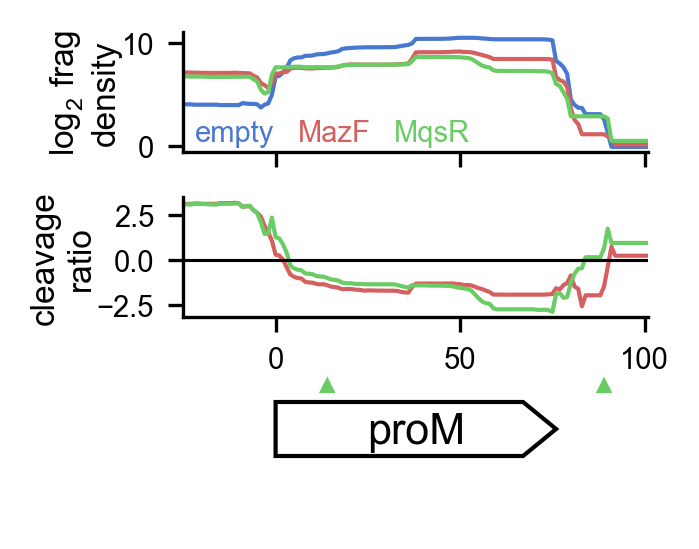

In [47]:
trna_margin = 100
gene_name = 'proM'
blue4, orange4, green4, red4 = sns.color_palette('muted',4)
############

window = gw.GenomeWindow(gene_table = gene_table, genome = loaded_genbank, gene_name_column='plt_tag',
                         axes_heights = [.4,.4,.1,.4], fig_width=2, show_poi=True,)

window.setpositionbygene(name=gene_name, nt_5=25, nt_3=25)

# load the mg1655 genome
genbank_path = '/home/pculviner/notebook/genomes/mg1655_v3/Ec_mg1655v3.gb'
loaded_genbank = SeqIO.read(genbank_path,'genbank')
# load a gene table csv from the provided path
gene_table_path = '/home/pculviner/notebook/genomes/mg1655_v3/gt_mg1655_v3.csv'
gene_table = pd.read_csv(gene_table_path, index_col=0)
# store tRNA information for checking regions
trna_regions = gene_table.loc[gene_table.locus_type == 'tRNA',['strand', 'start', 'end']].values.astype(int)

### PLOT MAZF AND EMPTY VECTOR
toxin_name = 'MazF'
# load density arrays
density_ctl_arrays, density_exp_arrays = loadarrays('/home/pculviner/notebook/storage/rnaseq/PCe22_novaseq/ezpool_pipeline/density_numpy_all/',
                                                     control_has = ['rz','ev','trna'], control_not = ['frg',],
                                                     experimental_has = ['rz',toxin_name,'trna'], experimental_not = ['frg',], verbose = False)
density_ctl_arrays, density_exp_arrays = normalizebytrnaregions_samples(density_ctl_arrays, density_exp_arrays, trna_margin, gene_table, loaded_genbank, pseudo=True)
# calculate log2 averages
tswitch_ctl_density = np.log2(density_ctl_arrays)
tswitch_exp_density = np.log2(density_exp_arrays)
avg_tswitch_cleavage_ratio = np.mean(tswitch_exp_density,axis=0) - np.mean(tswitch_ctl_density,axis=0)

window.plotdatastreams(axis_n = 0, input_data = np.mean(tswitch_ctl_density,axis=0),
                       color = blue4, rasterize_data = False, stream_type = gw.ArrayAsLine, lw = 1, label='empty')

window.plotdatastreams(axis_n = 0, input_data = np.mean(tswitch_exp_density,axis=0),
                       color = red4, rasterize_data = False, stream_type = gw.ArrayAsLine, lw = 1, label = 'MazF')

window.plotdatastreams(axis_n = 1, input_data = avg_tswitch_cleavage_ratio,
                       color = red4, rasterize_data = False, stream_type = gw.ArrayAsLine, lw = 1, label = 'MazF')

toxin_name = 'MqsR'
# load density arrays
density_ctl_arrays, density_exp_arrays = loadarrays('/home/pculviner/notebook/storage/rnaseq/PCe22_novaseq/ezpool_pipeline/density_numpy_all/',
                                                     control_has = ['rz','ev','trna'], control_not = ['frg',],
                                                     experimental_has = ['rz',toxin_name,'trna'], experimental_not = ['frg',], verbose = False)
density_ctl_arrays, density_exp_arrays = normalizebytrnaregions_samples(density_ctl_arrays, density_exp_arrays, trna_margin, gene_table, loaded_genbank, pseudo=True)
# calculate log2 averages
tswitch_ctl_density = np.log2(density_ctl_arrays)
tswitch_exp_density = np.log2(density_exp_arrays)
avg_tswitch_cleavage_ratio = np.mean(tswitch_exp_density,axis=0) - np.mean(tswitch_ctl_density,axis=0)

window.plotdatastreams(axis_n = 0, input_data = np.mean(tswitch_exp_density,axis=0),
                       color = green4, rasterize_data = False, stream_type = gw.ArrayAsLine, lw = 1, label='MqsR')

window.plotdatastreams(axis_n = 1, input_data = avg_tswitch_cleavage_ratio,
                       color = green4, rasterize_data = False, stream_type = gw.ArrayAsLine, lw = 1, label='MqsR')


# plot points of interest - ACA and GCU sites
window.plotdatastreams(axis_n = None,
                   input_data = aca_loc,
                   stream_type = gw.PointsOfInterest,
                   arrowprops= {'width':0,'headwidth':4,'headlength':4,'facecolor':red4,'edgecolor':'None'})

window.plotdatastreams(axis_n = None,
                   input_data = gcu_loc,
                   stream_type = gw.PointsOfInterest,
                   arrowprops= {'width':0,'headwidth':4,'headlength':4,'facecolor':green4,'edgecolor':'None'})


# prepare axes labels and legends
# apply some labels
window.axesdata[0].set_ylabel("log$\mathdefault{_2}$ frag\ndensity",labelpad=0)
window.axesdata[1].set_ylabel('cleavage\nratio',labelpad=0)
window.axesdata[1].axhline(0,0,1,lw=.75,c='k')
# generate a legend
legend = window.axesdata[0].legend(bbox_to_anchor=(-.05, -.05), loc='lower left', ncol=4, columnspacing=0,
                        borderaxespad=0., fontsize=7, frameon=False, handlelength=0, labelcolor ='linecolor', markerscale=0)


# move up genome plot slightly
gw.moveaxis(window.ax_sequence,dy=.05)
gw.moveaxis(window.ax_genes,dy=.225)

plt.savefig('figure_outputs/4B_left_proM.pdf',format='pdf',bbox_inches='tight')

window zero at 1746434, window is not reversed: True


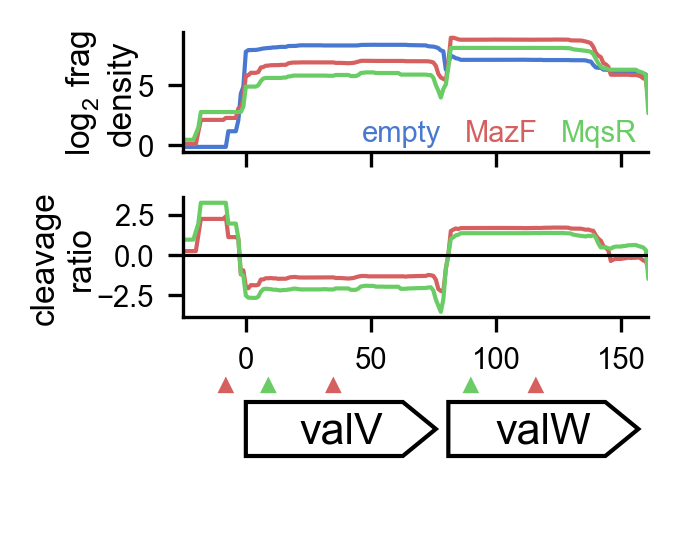

In [48]:
trna_margin = 100
gene_name = 'valV'
blue4, orange4, green4, red4 = sns.color_palette('muted',4)
############

window = gw.GenomeWindow(gene_table = gene_table, genome = loaded_genbank, gene_name_column='plt_tag',
                         axes_heights = [.4,.4,.1,.4], fig_width=2, show_poi=True,)

window.setpositionbygene(name=gene_name, nt_5=25, nt_3=85)

# load the mg1655 genome
genbank_path = '/home/pculviner/notebook/genomes/mg1655_v3/Ec_mg1655v3.gb'
loaded_genbank = SeqIO.read(genbank_path,'genbank')
# load a gene table csv from the provided path
gene_table_path = '/home/pculviner/notebook/genomes/mg1655_v3/gt_mg1655_v3.csv'
gene_table = pd.read_csv(gene_table_path, index_col=0)
# store tRNA information for checking regions
trna_regions = gene_table.loc[gene_table.locus_type == 'tRNA',['strand', 'start', 'end']].values.astype(int)

### PLOT MAZF AND EMPTY VECTOR
toxin_name = 'MazF'
# load density arrays
density_ctl_arrays, density_exp_arrays = loadarrays('/home/pculviner/notebook/storage/rnaseq/PCe22_novaseq/ezpool_pipeline/density_numpy_all/',
                                                     control_has = ['rz','ev','trna'], control_not = ['frg',],
                                                     experimental_has = ['rz',toxin_name,'trna'], experimental_not = ['frg',], verbose = False)
density_ctl_arrays, density_exp_arrays = normalizebytrnaregions_samples(density_ctl_arrays, density_exp_arrays, trna_margin, gene_table, loaded_genbank, pseudo=True)
# calculate log2 averages
tswitch_ctl_density = np.log2(density_ctl_arrays)
tswitch_exp_density = np.log2(density_exp_arrays)
avg_tswitch_cleavage_ratio = np.mean(tswitch_exp_density,axis=0) - np.mean(tswitch_ctl_density,axis=0)

window.plotdatastreams(axis_n = 0, input_data = np.mean(tswitch_ctl_density,axis=0),
                       color = blue4, rasterize_data = False, stream_type = gw.ArrayAsLine, lw = 1, label='empty')

window.plotdatastreams(axis_n = 0, input_data = np.mean(tswitch_exp_density,axis=0),
                       color = red4, rasterize_data = False, stream_type = gw.ArrayAsLine, lw = 1, label = 'MazF')

window.plotdatastreams(axis_n = 1, input_data = avg_tswitch_cleavage_ratio,
                       color = red4, rasterize_data = False, stream_type = gw.ArrayAsLine, lw = 1, label = 'MazF')

toxin_name = 'MqsR'
# load density arrays
density_ctl_arrays, density_exp_arrays = loadarrays('/home/pculviner/notebook/storage/rnaseq/PCe22_novaseq/ezpool_pipeline/density_numpy_all/',
                                                     control_has = ['rz','ev','trna'], control_not = ['frg',],
                                                     experimental_has = ['rz',toxin_name,'trna'], experimental_not = ['frg',], verbose = False)
density_ctl_arrays, density_exp_arrays = normalizebytrnaregions_samples(density_ctl_arrays, density_exp_arrays, trna_margin, gene_table, loaded_genbank, pseudo=True)
# calculate log2 averages
tswitch_ctl_density = np.log2(density_ctl_arrays)
tswitch_exp_density = np.log2(density_exp_arrays)
avg_tswitch_cleavage_ratio = np.mean(tswitch_exp_density,axis=0) - np.mean(tswitch_ctl_density,axis=0)

window.plotdatastreams(axis_n = 0, input_data = np.mean(tswitch_exp_density,axis=0),
                       color = green4, rasterize_data = False, stream_type = gw.ArrayAsLine, lw = 1, label='MqsR')

window.plotdatastreams(axis_n = 1, input_data = avg_tswitch_cleavage_ratio,
                       color = green4, rasterize_data = False, stream_type = gw.ArrayAsLine, lw = 1, label='MqsR')


# plot points of interest - ACA and GCU sites
window.plotdatastreams(axis_n = None,
                   input_data = aca_loc,
                   stream_type = gw.PointsOfInterest,
                   arrowprops= {'width':0,'headwidth':4,'headlength':4,'facecolor':red4,'edgecolor':'None'})

window.plotdatastreams(axis_n = None,
                   input_data = gcu_loc,
                   stream_type = gw.PointsOfInterest,
                   arrowprops= {'width':0,'headwidth':4,'headlength':4,'facecolor':green4,'edgecolor':'None'})


# prepare axes labels and legends
# apply some labels
window.axesdata[0].set_ylabel("log$\mathdefault{_2}$ frag\ndensity",labelpad=0)
window.axesdata[1].set_ylabel('cleavage\nratio',labelpad=0)
window.axesdata[1].axhline(0,0,1,lw=.75,c='k')
# generate a legend
legend = window.axesdata[0].legend(bbox_to_anchor=(1, -.05), loc='lower right', ncol=4, columnspacing=0,
                        borderaxespad=0., fontsize=7, frameon=False, handlelength=0, labelcolor ='linecolor', markerscale=0)


# move up genome plot slightly
gw.moveaxis(window.ax_sequence,dy=.05)
gw.moveaxis(window.ax_genes,dy=.225)

plt.savefig('figure_outputs/4B_right_valV.pdf',format='pdf',bbox_inches='tight')

## Figure 4C: tRNA heatmap

In [49]:
from matplotlib.ticker import MultipleLocator,ScalarFormatter,FuncFormatter

def normalizebytrnaregions_samples(ctl_arrays, exp_arrays, trna_margin, gene_table, genome, pseudo = False):
    # generate the rrna mask - these regions will not be included in the calculation of size factors for count normalization
    trna_regions = gene_table.loc[gene_table.locus_type == 'tRNA',['strand', 'start', 'end']].values.astype(int)
    trna_regions[:,1] = trna_regions[:,1] - trna_margin
    trna_regions[:,2] = trna_regions[:,2] + trna_margin
    trna_mask = ~ga.regionstomask(trna_regions, len(genome)) # inverse mask, we only want to use tRNA regions here
    # normalize the arrays by counts in the non-masked regions
    normalized_arrays = maskedcountnormalization(np.r_[ctl_arrays,exp_arrays], trna_mask, pseudo = pseudo)
    # split the arrays back into control and experimental
    normalized_ctl_arrays = normalized_arrays[:len(ctl_arrays)]
    normalized_exp_arrays = normalized_arrays[len(ctl_arrays):]
    return normalized_ctl_arrays, normalized_exp_arrays

def moveaxis(ax, dx=0, dy=0):
    # where x and y are in inches on final figure
    fig = ax.get_figure()
    ax_coor = ax.get_position()
    dx = dx / fig.get_figwidth() # convert to figure coordinates
    dy = dy / fig.get_figheight() #  .5 = 2 1 # .25  = 2 .5
    ax.set_position([ax_coor.x0+dx, ax_coor.y0+dy, ax_coor.x1-ax_coor.x0, ax_coor.y1-ax_coor.y0])

calculate expression levels

In [50]:
## INPUTS ##
toxin_list = ['MazF', 'ChpB', 'MqsR', 'HicA', 'RelE', 'YoeB', 'YhaV', 'HigB', 'YafO',]
trna_margin = 100
expression_threshold = np.log2(32)

############
# load the mg1655 genome
genbank_path = '/home/pculviner/notebook/genomes/mg1655_v3/Ec_mg1655v3.gb'
loaded_genbank = SeqIO.read(genbank_path,'genbank')
# load a gene table csv from the provided path
gene_table_path = '/home/pculviner/notebook/genomes/mg1655_v3/gt_mg1655_v3.csv'
gene_table = pd.read_csv(gene_table_path, index_col=0)
# store tRNA information for checking regions
trna_regions = gene_table.loc[gene_table.locus_type == 'tRNA',['strand', 'start', 'end']].values.astype(int)
trna_names   = gene_table.loc[gene_table.locus_type == 'tRNA',['gene']].values.reshape(-1)
# storage arrays for things that need be handled at the end
raw_cleavage_ratio   = []
cleavage_ratio_range = []
for i,toxin_name in enumerate(toxin_list):
    print('%s: load data...'%toxin_name)
    # load density arrays
    density_ctl_arrays, density_exp_arrays = loadarrays('/home/pculviner/notebook/storage/rnaseq/PCe22_novaseq/ezpool_pipeline/density_numpy_all/',
                                                         control_has = ['rz','ev','trna'], control_not = ['frg',],
                                                         experimental_has = ['rz',toxin_name,'trna'], experimental_not = ['frg',], verbose = False)
    density_ctl_arrays, density_exp_arrays = normalizebytrnaregions_samples(density_ctl_arrays, density_exp_arrays, trna_margin, gene_table, loaded_genbank, pseudo=True)
    # calculate log2 averages
    avg_tswitch_ctl_density =  np.mean(np.log2(density_ctl_arrays),axis=0)
    avg_tswitch_cleavage_ratio = np.mean(np.log2(density_exp_arrays),axis=0) - np.mean(np.log2(density_ctl_arrays),axis=0)
    # mask the dataframe for positions below the threshold
    avg_tswitch_cleavage_ratio[avg_tswitch_ctl_density < expression_threshold] = np.nan
    # store maximum and minimum data
    raw_cleavage_ratio.append(ga.regionfunc(np.min, trna_regions, avg_tswitch_cleavage_ratio))
    cleavage_ratio_range.append(np.asarray(ga.regionfunc(np.min, trna_regions, avg_tswitch_cleavage_ratio)) - np.asarray(ga.regionfunc(np.max, trna_regions, avg_tswitch_cleavage_ratio)))

MazF: load data...
ChpB: load data...
MqsR: load data...
HicA: load data...
RelE: load data...
YoeB: load data...
YhaV: load data...
HigB: load data...
YafO: load data...


In [51]:
# convert both data sets into cleavage ratios 
raw_cleavage_frame = pd.DataFrame(data = np.asarray(raw_cleavage_ratio).T,
                                  columns = toxin_list,
                                  index=trna_names)
range_cleavage_frame = pd.DataFrame(data = np.asarray(cleavage_ratio_range).T,
                                    columns = toxin_list,
                                    index=trna_names)

# apply a hard filter to remove any tRNA genes below the expression threshold
is_expressed = ~np.any(raw_cleavage_frame.isnull(),1)
raw_cleavage_frame = raw_cleavage_frame.loc[is_expressed]
range_cleavage_frame = range_cleavage_frame.loc[is_expressed]

# argsort both in increasing order based on the raw cleavage data mean
i_order = np.argsort(raw_cleavage_frame.mean(1)).values
raw_cleavage_frame = raw_cleavage_frame.iloc[i_order]
range_cleavage_frame = range_cleavage_frame.iloc[i_order]
np.sum(is_expressed)

82

generate motif masks and count number of motifs in each

In [52]:
# load the mg1655 genome
genbank_path = '/home/pculviner/notebook/genomes/mg1655_v3/Ec_mg1655v3.gb'
loaded_genbank = SeqIO.read(genbank_path,'genbank')
# load a gene table csv from the provided path
gene_table_path = '/home/pculviner/notebook/genomes/mg1655_v3/gt_mg1655_v3.csv'
gene_table = pd.read_csv(gene_table_path, index_col=0)
# generate a onehot representation of the genome
onehot_genome = ga.genometoonehot(loaded_genbank)
# trinucleotide masks for MazF, ChpB and MqsR
aca_counts = ga.regionfunc(np.sum, trna_regions, getmotiflocations('ACA', onehot_genome))
uac_counts = ga.regionfunc(np.sum, trna_regions, getmotiflocations('TAC', onehot_genome))
gcu_counts = ga.regionfunc(np.sum, trna_regions, getmotiflocations('GCT', onehot_genome))
# cut site dataframe
motif_dataframe = pd.DataFrame(data=np.asarray([aca_counts,uac_counts,gcu_counts]).T, columns=['ACA (MazF)', 'UAC (ChpB)', 'GCU (MqsR)'], index=trna_names)
# modify to remove unexpressed tRNA and reorder into above order
motif_dataframe = motif_dataframe.loc[is_expressed].iloc[i_order]
motif_dataframe_ouptut = motif_dataframe.copy()
# max out values at 3
motif_dataframe.values[motif_dataframe.values > 3] = 3

In [53]:
# prepare colormap for minimum
blue_black_yellow = sns.diverging_palette(65, 230, s=90, l=80, as_cmap=True, center="dark")
raw_vmin, raw_vmax = raw_cleavage_frame.values.min(), raw_cleavage_frame.values.max()
# prepare categorical colormap for motif
discrete_white_black = sns.color_palette("dark:white_r",4)

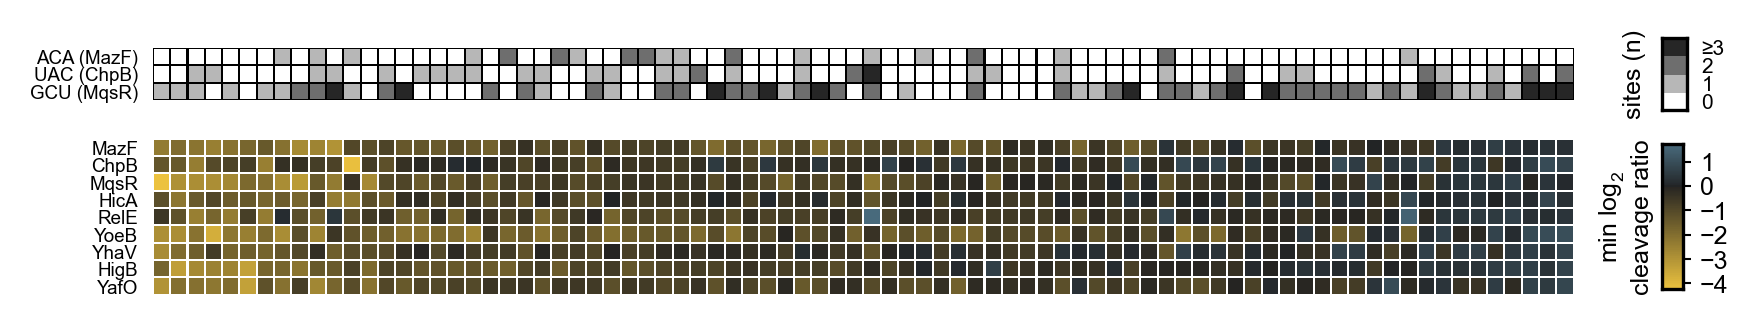

In [54]:
## plot figures
fig = plt.figure(constrained_layout=False, figsize=(9,4))
# make a gridspec and assign axes
gridspec  = fig.add_gridspec(ncols=20, nrows=9)
heatmap_1 = fig.add_subplot(gridspec[0:3,:17])
heatmap_2 = fig.add_subplot(gridspec[3:6,:17])



# plot heatmaps
# plot motif counts
sns.heatmap(data = motif_dataframe.transpose(), cmap=discrete_white_black, vmin =-.5, vmax=3.5, 
            ax = heatmap_1, xticklabels=False, yticklabels=False, square = True, linewidth = .25, linecolor='k', cbar_kws={'shrink':.25, 'use_gridspec':True, 'aspect':3})
# raw cleavage value
sns.heatmap(data = raw_cleavage_frame.transpose(), vmin=raw_vmin, vmax=raw_vmax, center=0, cmap=blue_black_yellow,
            ax = heatmap_2, xticklabels=False, yticklabels=False, square = True, linewidth = .25, cbar_kws={'shrink':.5, 'use_gridspec':True, 'aspect':7})


# format heatmaps and colorbars
heatmap_1.set_yticks(np.arange(len(motif_dataframe.columns))+.5)
heatmap_1.tick_params(axis='both', which='both',length=0)
heatmap_1.set_yticklabels(motif_dataframe.columns,fontsize=4.5)

heatmap_2.set_yticks(np.arange(len(raw_cleavage_frame.columns))+.5)
heatmap_2.tick_params(axis='both', which='both',length=0)
heatmap_2.set_yticklabels(raw_cleavage_frame.columns,fontsize=4.5)

# format colorbars
fig.axes[2].set_frame_on(True)
fig.axes[2].yaxis.set_ticks([0,1,2,3])
fig.axes[2].set_yticklabels([0,1,2,'≥3'],fontsize=5)
fig.axes[2].tick_params(axis='y', which='both',length=0)
fig.axes[2].yaxis.set_label_position('left')
fig.axes[2].set_ylabel('sites (n)',fontsize=6)

fig.axes[3].set_frame_on(True)
fig.axes[3].yaxis.set_major_locator(MultipleLocator(1))
fig.axes[3].tick_params(axis='y', which='both',length=2, width=.5, labelsize= 6, pad=2)
fig.axes[3].yaxis.set_label_position('left')
fig.axes[3].set_ylabel('min log$\mathregular{_2}$\ncleavage ratio',fontsize=6,labelpad=2)

# move axes down
moveaxis(heatmap_1, 0, -.55)
moveaxis(fig.axes[2], 0, -.55)

plt.savefig('figure_outputs/4C_tRNA_heatmaps.pdf',format='pdf',bbox_inches='tight')

# Figure 5

## Figure 5A: identify top peaks in rRNA regions

In [55]:
from matplotlib.ticker import MultipleLocator,ScalarFormatter,FuncFormatter
from regex import search

def pullsequence(location, five, three, genome):
    strand, position = location
    if strand == 0:
        return str(genome.seq[position-five:position+three])
    if strand == 1:
        return str(genome.seq[position-three+1:position+five+1].reverse_complement())
    
def muscleAlign(names, sequences):
    # write a temporary fasta file for muscle to read / align
    writeFasta('_temp.fasta', names, sequences)
    # conduct a muscle alignment on the temporary fasta
    subprocess.call(['muscle','-in','_temp.fasta','-out','_temp_aligned.fasta'])
    # import alignments back into python
    names, sequences = readFasta('_temp_aligned.fasta',True)
    # clean up temporary file
    os.remove('_temp.fasta')
    return names, sequences

def writeFasta(filepath, names, sequences):
    # accepts list of names (spaces will be replaced with underscores) and list of sequences, writes to filepath
    with open(filepath,'w') as f:
        for n,seq in zip(names,sequences):
            f.write('>%s\n%s\n'%(n.replace(' ','_'),str(seq)))
    return filepath

def readFasta(filepath, delete=False):
    # returns names and records
    with open(filepath,'r') as f:
        lines = f.readlines()
        # now take out the records
        records = []
        names = []
        current_record = ''
        for line in lines:
            if line[0] == '>':
                names.append(line[1:-1])
                records.append(current_record)
                current_record = ''
            else:
                current_record += line[:-1]
        records.append(current_record)
        names = np.asarray(names)
        records = np.asarray(records[1:])
    if delete: # burn after reading
        os.remove(filepath)
    return names, records

def pullindexdata(target_indexes, alignment_mask, input_data, function = lambda x: x):
    return [function(input_data[alignment_mask == i]) for i in target_indexes]

def loadnormalizearbitraryarrays(target_folder, search_strings = None, verbose = True, normalization_mask = None, pseudo = True):
    # find numpy files in the target folder
    stdout, _ = quickshell('ls %s*.npy'%target_folder, print_output=False, return_output=True)
    all_numpy_files = stdout.split('\n')[:-1]
    # iterate through search strings of shape [[has1,has2,has3...],[not1,not2,not3...]]
    raw_arrays = []
    out_shape = []    
    for i,(has_strings, not_strings) in enumerate(search_strings):
        n = 0
        for file_path in all_numpy_files:
            file_name = file_path.split('/')[-1]
            if all([s.lower() in file_name.lower() for s in has_strings]) and all([s.lower() not in file_name.lower() for s in not_strings]):
                print('group %i: %s'%(i+1,file_name))
                raw_arrays.append(np.load(file_path))
                n+=1
        if n != 0:
            out_shape.append(n)
    # set empty normalization mask if none was given
    if normalization_mask is None:
        normalization_mask = np.zeros(raw_arrays[0].shape).astype(bool)
    # normalize arrays
    normalized_arrays = maskedcountnormalization(raw_arrays, normalization_mask, pseudo = pseudo)
    # reshape into output sets by slicing
    output_arrays = []
    for i in out_shape:
        output_arrays.append(normalized_arrays[:i])
        normalized_arrays = normalized_arrays[i:]
    return output_arrays

### collect 16S data

In [56]:
upstream_nt = 200
downstream_nt = 50
gene_product = '16S ribosomal RNA'

# load the mg1655 genome
genbank_path = '/home/pculviner/notebook/genomes/mg1655_v3/Ec_mg1655v3.gb'
loaded_genbank = SeqIO.read(genbank_path,'genbank')
# load a gene table csv from the provided path
gene_table_path = '/home/pculviner/notebook/genomes/mg1655_v3/gt_mg1655_v3.csv'
gene_table = pd.read_csv(gene_table_path, index_col=0)

# pull tRNA sequences from the genome
trna_sequences = []
for strand,start,end in gene_table.loc[gene_table.loc[:,'product'] == gene_product, ['strand', 'start', 'end']].values:
    if strand == 0:
        trna_sequences.append(pullsequence([strand,start], upstream_nt, end-start+downstream_nt+1, loaded_genbank))
    if strand == 1:
        trna_sequences.append(pullsequence([strand,end], upstream_nt, end-start+downstream_nt+1, loaded_genbank))
# align the sequences
names, alignments = muscleAlign(gene_table.loc[gene_table.loc[:,'product'] == gene_product].gene.values, trna_sequences)

# convert the alignments into a character array
alignments_array = np.asarray([list(a) for a in alignments])
label_array = np.asarray(names)

## paint the alignment positions on the genome
# generate a mask with np.nan at every position
alignment_mask = np.zeros((2,len(loaded_genbank)))+np.nan
# generate an array index including every position in the alignment
global_array_index = np.arange(len(alignments_array[0]))
# generate a count of positions at each array index
global_array_index_counts = np.sum(alignments_array != '-',0)
# iterate across the alignments we've made
for gene,strand,start,end in gene_table.loc[gene_table.loc[:,'product'] == gene_product, ['gene', 'strand', 'start', 'end']].values:
    # pull gene from list of alignments          
    a_array = alignments_array[label_array == gene][0]
    # calculate indexes to paint onto genome
    indexes_to_paint = [i for i, base in enumerate(a_array) if base != '-']
    # paint this alignment onto the genome
    if strand == 0:
        alignment_mask[0,start-upstream_nt:end+1+downstream_nt] = indexes_to_paint
    elif strand == 1:
        alignment_mask[1,start-downstream_nt:end+1+upstream_nt] = indexes_to_paint[::-1]
        
## error checking ##
# # check alignment mask
# for i in global_array_index:
#     print('%i:%s'%(i,''.join([pullsequence(location, 0, 1, loaded_genbank) for location in np.asarray(np.where(alignment_mask == i)).T])))
####################

# identify all indexes with no gaps
no_gaps_index = global_array_index[global_array_index_counts == np.max(global_array_index_counts)]
# store start and end in alignment coordinates
reference_string = ''.join(alignments_array[0][no_gaps_index])
start_index = search('AAATTGAAGAG', reference_string).span()[0]
end_index   = search('TCACCTCCTTA', reference_string).span()[1]-1

In [57]:
###### LOADING DATA #######
# function for moving from genome space to alignment space
reindexsamples = lambda sample_arrays, alignment_mask, target_indexes, function: [[pullindexdata(target_indexes, alignment_mask, replicate, function)
                                                                                   for replicate in sample_group] for sample_group in sample_arrays]

search_strings = [[['tot_30m','ev'],[]],
                  [['tot_30m','mazF'],[]],
                  [['tot_30m','chpB'],[]],
                  [['tot_30m','hicA'],[]],
                  [['tot_30m','mqsR'],[]],
                  [['tot_30m','relE'],[]],
                  [['tot_30m','yhaV'],[]],
                  [['tot_30m','higB'],[]],
                  [['tot_30m','yoeB'],[]],
                  [['tot_30m','yafO'],[]],]

title_list = ['MazF',
              'ChpB',
              'HicA',
              'MqsR',
              'RelE',
              'YhaV',
              'HigB',
              'YoeB',
              'YafO',]

# load a set of sample arrays
loaded_arrays = loadnormalizearbitraryarrays('/home/pculviner/notebook/storage/rnaseq/PCe22_novaseq/ezpool_pipeline/five_prime_numpy_all/',
                                             search_strings = search_strings)
# reindex using reindexing function into alignment space
reindexed_arrays = reindexsamples(loaded_arrays, alignment_mask, no_gaps_index, np.sum)

group 1: tot_30m-ev1.4.1.npy
group 1: tot_30m-ev2.4.13.npy
group 2: tot_30m-mazf1.4.2.npy
group 2: tot_30m-mazf2.4.14.npy
group 3: tot_30m-chpb1.4.4.npy
group 3: tot_30m-chpb2.4.16.npy
group 4: tot_30m-hica1.4.5.npy
group 4: tot_30m-hica2.4.17.npy
group 5: tot_30m-mqsr1.4.7.npy
group 5: tot_30m-mqsr2.4.19.npy
group 6: tot_30m-rele1.4.3.npy
group 6: tot_30m-rele2.4.15.npy
group 7: tot_30m-yhav1.4.6.npy
group 7: tot_30m-yhav2.4.18.npy
group 8: tot_30m-higb1.4.12.npy
group 8: tot_30m-higb2.4.24.npy
group 9: tot_30m-yoeb1.4.9.npy
group 9: tot_30m-yoeb2.4.21.npy
group 10: tot_30m-yafo1.4.10.npy
group 10: tot_30m-yafo2.4.22.npy


In [58]:
top_n = 25
pull_nt = 4

# storage for this data
peak_sequences_16S = []
# reorganize into mean signal
mean_signals = np.mean(np.log2(np.asarray(reindexed_arrays)),1)
# end ratio for the toxins
log_end_ratio = mean_signals[1:] - mean_signals[0]
for txi in range(len(log_end_ratio)):
    # storage for this particular toxin
    toxin_specific_list = []
    # find the top n sites for each toxin
    top_sites = np.argsort(log_end_ratio[txi])[::-1][:top_n]
    site_values = np.sort(log_end_ratio[txi])[::-1][:top_n]
    # iterate through the alignment indexes of the top sites
    for ai,val in zip(no_gaps_index[top_sites],site_values):
        surrounding_sequence_array = alignments_array[:,ai-pull_nt:ai+pull_nt]
        # check for variants at this site
        no_variants = np.all([len(np.unique(row)) == 1 for row in surrounding_sequence_array.T])
        if no_variants:
            toxin_specific_list.append([''.join(surrounding_sequence_array[0]),val])
    peak_sequences_16S.append(toxin_specific_list)

### collect 23S data

In [59]:
upstream_nt = 75
downstream_nt = 75
gene_product = '23S ribosomal RNA'

# load the mg1655 genome
genbank_path = '/home/pculviner/notebook/genomes/mg1655_v3/Ec_mg1655v3.gb'
loaded_genbank = SeqIO.read(genbank_path,'genbank')
# load a gene table csv from the provided path
gene_table_path = '/home/pculviner/notebook/genomes/mg1655_v3/gt_mg1655_v3.csv'
gene_table = pd.read_csv(gene_table_path, index_col=0)

# pull tRNA sequences from the genome
trna_sequences = []
for strand,start,end in gene_table.loc[gene_table.loc[:,'product'] == gene_product, ['strand', 'start', 'end']].values:
    if strand == 0:
        trna_sequences.append(pullsequence([strand,start], upstream_nt, end-start+downstream_nt+1, loaded_genbank))
    if strand == 1:
        trna_sequences.append(pullsequence([strand,end], upstream_nt, end-start+downstream_nt+1, loaded_genbank))
# align the sequences
names, alignments = muscleAlign(gene_table.loc[gene_table.loc[:,'product'] == gene_product].gene.values, trna_sequences)

# convert the alignments into a character array
alignments_array = np.asarray([list(a) for a in alignments])
label_array = np.asarray(names)

## paint the alignment positions on the genome
# generate a mask with np.nan at every position
alignment_mask = np.zeros((2,len(loaded_genbank)))+np.nan
# generate an array index including every position in the alignment
global_array_index = np.arange(len(alignments_array[0]))
# generate a count of positions at each array index
global_array_index_counts = np.sum(alignments_array != '-',0)
# iterate across the alignments we've made
for gene,strand,start,end in gene_table.loc[gene_table.loc[:,'product'] == gene_product, ['gene', 'strand', 'start', 'end']].values:
    # pull gene from list of alignments          
    a_array = alignments_array[label_array == gene][0]
    # calculate indexes to paint onto genome
    indexes_to_paint = [i for i, base in enumerate(a_array) if base != '-']
    # paint this alignment onto the genome
    if strand == 0:
        alignment_mask[0,start-upstream_nt:end+1+downstream_nt] = indexes_to_paint
    elif strand == 1:
        alignment_mask[1,start-downstream_nt:end+1+upstream_nt] = indexes_to_paint[::-1]
        
## error checking ##
# # check alignment mask
# for i in global_array_index:
#     print('%i:%s'%(i,''.join([pullsequence(location, 0, 1, loaded_genbank) for location in np.asarray(np.where(alignment_mask == i)).T])))
####################

# identify all indexes with no gaps
no_gaps_index = global_array_index[global_array_index_counts == np.max(global_array_index_counts)]
# store start and end in alignment coordinates
reference_string = ''.join(alignments_array[0][no_gaps_index])
start_index = search('GGTTAAGCGAC', reference_string).span()[0]
end_index   = search('GGCTTAACCTT', reference_string).span()[1]-1

In [60]:
###### LOADING DATA #######
# function for moving from genome space to alignment space
reindexsamples = lambda sample_arrays, alignment_mask, target_indexes, function: [[pullindexdata(target_indexes, alignment_mask, replicate, function)
                                                                                   for replicate in sample_group] for sample_group in sample_arrays]

search_strings = [[['tot_30m','ev'],[]],
                  [['tot_30m','mazF'],[]],
                  [['tot_30m','chpB'],[]],
                  [['tot_30m','hicA'],[]],
                  [['tot_30m','mqsR'],[]],
                  [['tot_30m','relE'],[]],
                  [['tot_30m','yhaV'],[]],
                  [['tot_30m','higB'],[]],
                  [['tot_30m','yoeB'],[]],
                  [['tot_30m','yafO'],[]],]

title_list = ['MazF',
              'ChpB',
              'HicA',
              'MqsR',
              'RelE',
              'YhaV',
              'HigB',
              'YoeB',
              'YafO',]

# load a set of sample arrays
loaded_arrays = loadnormalizearbitraryarrays('/home/pculviner/notebook/storage/rnaseq/PCe22_novaseq/ezpool_pipeline/five_prime_numpy_all/',
                                             search_strings = search_strings)
# reindex using reindexing function into alignment space
reindexed_arrays = reindexsamples(loaded_arrays, alignment_mask, no_gaps_index, np.sum)

group 1: tot_30m-ev1.4.1.npy
group 1: tot_30m-ev2.4.13.npy
group 2: tot_30m-mazf1.4.2.npy
group 2: tot_30m-mazf2.4.14.npy
group 3: tot_30m-chpb1.4.4.npy
group 3: tot_30m-chpb2.4.16.npy
group 4: tot_30m-hica1.4.5.npy
group 4: tot_30m-hica2.4.17.npy
group 5: tot_30m-mqsr1.4.7.npy
group 5: tot_30m-mqsr2.4.19.npy
group 6: tot_30m-rele1.4.3.npy
group 6: tot_30m-rele2.4.15.npy
group 7: tot_30m-yhav1.4.6.npy
group 7: tot_30m-yhav2.4.18.npy
group 8: tot_30m-higb1.4.12.npy
group 8: tot_30m-higb2.4.24.npy
group 9: tot_30m-yoeb1.4.9.npy
group 9: tot_30m-yoeb2.4.21.npy
group 10: tot_30m-yafo1.4.10.npy
group 10: tot_30m-yafo2.4.22.npy


In [61]:
top_n = 25
pull_nt = 4

# storage for this data
peak_sequences_23S = []
# reorganize into mean signal
mean_signals = np.mean(np.log2(np.asarray(reindexed_arrays)),1)
# end ratio for the toxins
log_end_ratio = mean_signals[1:] - mean_signals[0]
for txi in range(len(log_end_ratio)):
    # storage for this particular toxin
    toxin_specific_list = []
    # find the top n sites for each toxin
    top_sites = np.argsort(log_end_ratio[txi])[::-1][:top_n]
    site_values = np.sort(log_end_ratio[txi])[::-1][:top_n]
    # iterate through the alignment indexes of the top sites
    for ai,val in zip(no_gaps_index[top_sites],site_values):
        surrounding_sequence_array = alignments_array[:,ai-pull_nt:ai+pull_nt]
        # check for variants at this site
        no_variants = np.all([len(np.unique(row)) == 1 for row in surrounding_sequence_array.T])
        if no_variants:
            toxin_specific_list.append([''.join(surrounding_sequence_array[0]),val])
    peak_sequences_23S.append(toxin_specific_list)

### combine data - main text

In [62]:
title_list = ['MazF',
              'ChpB',
              'HicA',
              'MqsR',
              'RelE',
              'YhaV',
              'HigB',
              'YoeB',
              'YafO',]

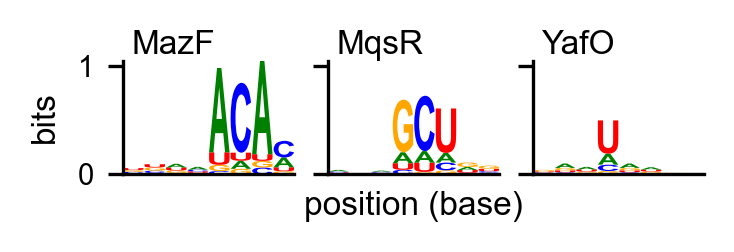

In [63]:
toxins_to_pull = ['MazF', 'MqsR', 'YafO']
toxin_indexes = [np.where(np.asarray(title_list) == t)[0][0] for t in toxins_to_pull]

n_sequences_in_motif = 30
# prepare plots for figures
fig, logo_axes = plt.subplots(1,3,figsize=(2.5,.5))

for ax_i,tx_i in enumerate(toxin_indexes):
    r16 = peak_sequences_16S[tx_i]
    r23 = peak_sequences_23S[tx_i]
    seqs, values = np.asarray(r16 + r23).T
    motif_values = values[np.argsort(values)[::-1][:n_sequences_in_motif]]
    motif_sequences = seqs[np.argsort(values)[::-1][:n_sequences_in_motif]]
    # get sequence counts in onehot format
    nt_counts = np.asarray([ga.dnatoonehot(s) for s in motif_sequences]).sum(0)
    # plot logo
    # get sites with more information than the threshold
    meet_info_threshold = np.max(lm.transform_matrix(pd.DataFrame(data=nt_counts), from_type='counts', to_type='information').values,axis=1) >= information_threshold
    motif_extent = [np.where(meet_info_threshold)[0][0], np.where(meet_info_threshold)[0][-1]]
    # draw the full logo
    logo = lm.Logo(lm.transform_matrix(pd.DataFrame(data=nt_counts, columns = ['A','U','G','C']), from_type='counts', to_type='information'),
            font_name = 'Arial', ax = logo_axes[ax_i],)
    logo.style_spines(spines=['right','top'], visible=False)
    logo.ax.set_xticks([])
    logo_axes[ax_i].text(0.05,1,toxins_to_pull[ax_i], va='bottom', transform = logo_axes[ax_i].transAxes,fontsize=8)
    logo_extents.append(motif_extent)

logo_max = np.max([ax.get_ylim()[1] for ax in logo_axes])
[ax.set_ylim([0, logo_max]) for ax in logo_axes]
[ax.set_yticklabels([]) for ax in logo_axes[1:]]
logo_axes[0].set_ylabel('bits')
logo_axes[1].set_xlabel('position (base)')

plt.savefig('figure_outputs/5A_rRNA_cleavage_motifs.pdf',format='pdf',bbox_inches='tight')

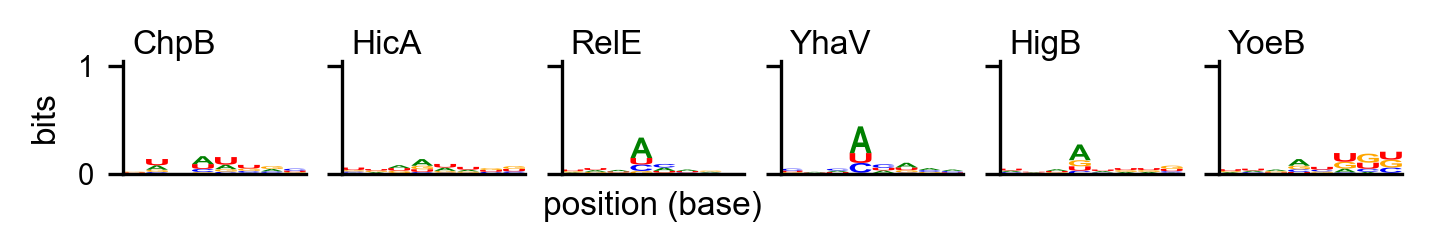

In [64]:
toxins_to_pull = ['ChpB', 'HicA', 'RelE', 'YhaV', 'HigB', 'YoeB']
toxin_indexes = [np.where(np.asarray(title_list) == t)[0][0] for t in toxins_to_pull]

n_sequences_in_motif = 30
# prepare plots for figures
fig, logo_axes = plt.subplots(1,6,figsize=(5.5,.5))

for ax_i,tx_i in enumerate(toxin_indexes):
    r16 = peak_sequences_16S[tx_i]
    r23 = peak_sequences_23S[tx_i]
    seqs, values = np.asarray(r16 + r23).T
    motif_values = values[np.argsort(values)[::-1][:n_sequences_in_motif]]
    motif_sequences = seqs[np.argsort(values)[::-1][:n_sequences_in_motif]]
    # get sequence counts in onehot format
    nt_counts = np.asarray([ga.dnatoonehot(s) for s in motif_sequences]).sum(0)
    # plot logo
    # get sites with more information than the threshold
    meet_info_threshold = np.max(lm.transform_matrix(pd.DataFrame(data=nt_counts), from_type='counts', to_type='information').values,axis=1) >= information_threshold
    motif_extent = [np.where(meet_info_threshold)[0][0], np.where(meet_info_threshold)[0][-1]]
    # draw the full logo
    logo = lm.Logo(lm.transform_matrix(pd.DataFrame(data=nt_counts, columns = ['A','U','G','C']), from_type='counts', to_type='information'),
            font_name = 'Arial', ax = logo_axes[ax_i],)
    logo.style_spines(spines=['right','top'], visible=False)
    logo.ax.set_xticks([])
    logo_axes[ax_i].text(0.05,1,toxins_to_pull[ax_i], va='bottom', transform = logo_axes[ax_i].transAxes,fontsize=8)
    logo_extents.append(motif_extent)

[ax.set_ylim([0, logo_max]) for ax in logo_axes] # use above logo maximum
[ax.set_yticklabels([]) for ax in logo_axes[1:]]
logo_axes[0].set_ylabel('bits')
logo_axes[2].set_xlabel('position (base)')

plt.savefig('figure_outputs/S2A_rRNA_cleavage_motifs.pdf',format='pdf',bbox_inches='tight')

## Figure S5B: visual inspection of top peaks in rRNA regions

In [65]:
from matplotlib.ticker import MultipleLocator,ScalarFormatter,FuncFormatter
from regex import search

def pullsequence(location, five, three, genome):
    strand, position = location
    if strand == 0:
        return str(genome.seq[position-five:position+three])
    if strand == 1:
        return str(genome.seq[position-three+1:position+five+1].reverse_complement())
    
def muscleAlign(names, sequences):
    # write a temporary fasta file for muscle to read / align
    writeFasta('_temp.fasta', names, sequences)
    # conduct a muscle alignment on the temporary fasta
    subprocess.call(['muscle','-in','_temp.fasta','-out','_temp_aligned.fasta'])
    # import alignments back into python
    names, sequences = readFasta('_temp_aligned.fasta',True)
    # clean up temporary file
    os.remove('_temp.fasta')
    return names, sequences

def writeFasta(filepath, names, sequences):
    # accepts list of names (spaces will be replaced with underscores) and list of sequences, writes to filepath
    with open(filepath,'w') as f:
        for n,seq in zip(names,sequences):
            f.write('>%s\n%s\n'%(n.replace(' ','_'),str(seq)))
    return filepath

def readFasta(filepath, delete=False):
    # returns names and records
    with open(filepath,'r') as f:
        lines = f.readlines()
        # now take out the records
        records = []
        names = []
        current_record = ''
        for line in lines:
            if line[0] == '>':
                names.append(line[1:-1])
                records.append(current_record)
                current_record = ''
            else:
                current_record += line[:-1]
        records.append(current_record)
        names = np.asarray(names)
        records = np.asarray(records[1:])
    if delete: # burn after reading
        os.remove(filepath)
    return names, records

def pullindexdata(target_indexes, alignment_mask, input_data, function = lambda x: x):
    return [function(input_data[alignment_mask == i]) for i in target_indexes]

def loadnormalizearbitraryarrays(target_folder, search_strings = None, verbose = True, normalization_mask = None, pseudo = True):
    # find numpy files in the target folder
    stdout, _ = quickshell('ls %s*.npy'%target_folder, print_output=False, return_output=True)
    all_numpy_files = stdout.split('\n')[:-1]
    # iterate through search strings of shape [[has1,has2,has3...],[not1,not2,not3...]]
    raw_arrays = []
    out_shape = []    
    for i,(has_strings, not_strings) in enumerate(search_strings):
        n = 0
        for file_path in all_numpy_files:
            file_name = file_path.split('/')[-1]
            if all([s.lower() in file_name.lower() for s in has_strings]) and all([s.lower() not in file_name.lower() for s in not_strings]):
                print('group %i: %s'%(i+1,file_name))
                raw_arrays.append(np.load(file_path))
                n+=1
        if n != 0:
            out_shape.append(n)
    # set empty normalization mask if none was given
    if normalization_mask is None:
        normalization_mask = np.zeros(raw_arrays[0].shape).astype(bool)
    # normalize arrays
    normalized_arrays = maskedcountnormalization(raw_arrays, normalization_mask, pseudo = pseudo)
    # reshape into output sets by slicing
    output_arrays = []
    for i in out_shape:
        output_arrays.append(normalized_arrays[:i])
        normalized_arrays = normalized_arrays[i:]
    return output_arrays

### collect 16S data for identifying top peaks

In [66]:
upstream_nt = 200
downstream_nt = 50
gene_product = '16S ribosomal RNA'

# load the mg1655 genome
genbank_path = '/home/pculviner/notebook/genomes/mg1655_v3/Ec_mg1655v3.gb'
loaded_genbank = SeqIO.read(genbank_path,'genbank')
# load a gene table csv from the provided path
gene_table_path = '/home/pculviner/notebook/genomes/mg1655_v3/gt_mg1655_v3.csv'
gene_table = pd.read_csv(gene_table_path, index_col=0)

# pull tRNA sequences from the genome
trna_sequences = []
for strand,start,end in gene_table.loc[gene_table.loc[:,'product'] == gene_product, ['strand', 'start', 'end']].values:
    if strand == 0:
        trna_sequences.append(pullsequence([strand,start], upstream_nt, end-start+downstream_nt+1, loaded_genbank))
    if strand == 1:
        trna_sequences.append(pullsequence([strand,end], upstream_nt, end-start+downstream_nt+1, loaded_genbank))
# align the sequences
names, alignments = muscleAlign(gene_table.loc[gene_table.loc[:,'product'] == gene_product].gene.values, trna_sequences)

# convert the alignments into a character array
alignments_array = np.asarray([list(a) for a in alignments])
label_array = np.asarray(names)

## paint the alignment positions on the genome
# generate a mask with np.nan at every position
alignment_mask = np.zeros((2,len(loaded_genbank)))+np.nan
# generate an array index including every position in the alignment
global_array_index = np.arange(len(alignments_array[0]))
# generate a count of positions at each array index
global_array_index_counts = np.sum(alignments_array != '-',0)
# iterate across the alignments we've made
for gene,strand,start,end in gene_table.loc[gene_table.loc[:,'product'] == gene_product, ['gene', 'strand', 'start', 'end']].values:
    # pull gene from list of alignments          
    a_array = alignments_array[label_array == gene][0]
    # calculate indexes to paint onto genome
    indexes_to_paint = [i for i, base in enumerate(a_array) if base != '-']
    # paint this alignment onto the genome
    if strand == 0:
        alignment_mask[0,start-upstream_nt:end+1+downstream_nt] = indexes_to_paint
    elif strand == 1:
        alignment_mask[1,start-downstream_nt:end+1+upstream_nt] = indexes_to_paint[::-1]
        
## error checking ##
# # check alignment mask
# for i in global_array_index:
#     print('%i:%s'%(i,''.join([pullsequence(location, 0, 1, loaded_genbank) for location in np.asarray(np.where(alignment_mask == i)).T])))
####################

# identify all indexes with no gaps
no_gaps_index = global_array_index[global_array_index_counts == np.max(global_array_index_counts)]
# store start and end in alignment coordinates
reference_string = ''.join(alignments_array[0][no_gaps_index])
start_index = search('AAATTGAAGAG', reference_string).span()[0]
end_index   = search('TCACCTCCTTA', reference_string).span()[1]-1

In [67]:
###### LOADING DATA #######
# function for moving from genome space to alignment space
reindexsamples = lambda sample_arrays, alignment_mask, target_indexes, function: [[pullindexdata(target_indexes, alignment_mask, replicate, function)
                                                                                   for replicate in sample_group] for sample_group in sample_arrays]

search_strings = [[['tot_30m','ev'],[]],
                  [['tot_30m','mazF'],[]],
                  [['tot_30m','mqsR'],[]],
                  [['tot_30m','yafO'],[]],
                  [['tot_30m','relE'],[]],]

title_list = ['MazF',
              'MqsR',
              'YafO',
              'RelE',]

# load a set of sample arrays
loaded_arrays = loadnormalizearbitraryarrays('/home/pculviner/notebook/storage/rnaseq/PCe22_novaseq/ezpool_pipeline/five_prime_numpy_all/',
                                             search_strings = search_strings)
# reindex using reindexing function into alignment space
reindexed_arrays = reindexsamples(loaded_arrays, alignment_mask, no_gaps_index, np.sum)

group 1: tot_30m-ev1.4.1.npy
group 1: tot_30m-ev2.4.13.npy
group 2: tot_30m-mazf1.4.2.npy
group 2: tot_30m-mazf2.4.14.npy
group 3: tot_30m-mqsr1.4.7.npy
group 3: tot_30m-mqsr2.4.19.npy
group 4: tot_30m-yafo1.4.10.npy
group 4: tot_30m-yafo2.4.22.npy
group 5: tot_30m-rele1.4.3.npy
group 5: tot_30m-rele2.4.15.npy


In [68]:
top_n = 25
pull_nt = 4

# storage for this data
peak_sequences_16S = []
# reorganize into mean signal
mean_signals = np.mean(np.log2(np.asarray(reindexed_arrays)),1)
# end ratio for the toxins
log_end_ratio = mean_signals[1:] - mean_signals[0]
for txi in range(len(log_end_ratio)):
    # storage for this particular toxin
    toxin_specific_list = []
    # find the top n sites for each toxin
    top_sites = np.argsort(log_end_ratio[txi])[::-1][:top_n]
    site_values = np.sort(log_end_ratio[txi])[::-1][:top_n]
    # iterate through the alignment indexes of the top sites
    for ai,val in zip(no_gaps_index[top_sites],site_values):
        surrounding_sequence_array = alignments_array[:,ai-pull_nt:ai+pull_nt]
        # check for variants at this site
        no_variants = np.all([len(np.unique(row)) == 1 for row in surrounding_sequence_array.T])
        if no_variants:
            toxin_specific_list.append([''.join(surrounding_sequence_array[0]),val,ai,16])
    peak_sequences_16S.append(toxin_specific_list)

### collect 23S data for identifying top peaks

In [69]:
upstream_nt = 75
downstream_nt = 75
gene_product = '23S ribosomal RNA'

# load the mg1655 genome
genbank_path = '/home/pculviner/notebook/genomes/mg1655_v3/Ec_mg1655v3.gb'
loaded_genbank = SeqIO.read(genbank_path,'genbank')
# load a gene table csv from the provided path
gene_table_path = '/home/pculviner/notebook/genomes/mg1655_v3/gt_mg1655_v3.csv'
gene_table = pd.read_csv(gene_table_path, index_col=0)

# pull tRNA sequences from the genome
trna_sequences = []
for strand,start,end in gene_table.loc[gene_table.loc[:,'product'] == gene_product, ['strand', 'start', 'end']].values:
    if strand == 0:
        trna_sequences.append(pullsequence([strand,start], upstream_nt, end-start+downstream_nt+1, loaded_genbank))
    if strand == 1:
        trna_sequences.append(pullsequence([strand,end], upstream_nt, end-start+downstream_nt+1, loaded_genbank))
# align the sequences
names, alignments = muscleAlign(gene_table.loc[gene_table.loc[:,'product'] == gene_product].gene.values, trna_sequences)

# convert the alignments into a character array
alignments_array = np.asarray([list(a) for a in alignments])
label_array = np.asarray(names)

## paint the alignment positions on the genome
# generate a mask with np.nan at every position
alignment_mask = np.zeros((2,len(loaded_genbank)))+np.nan
# generate an array index including every position in the alignment
global_array_index = np.arange(len(alignments_array[0]))
# generate a count of positions at each array index
global_array_index_counts = np.sum(alignments_array != '-',0)
# iterate across the alignments we've made
for gene,strand,start,end in gene_table.loc[gene_table.loc[:,'product'] == gene_product, ['gene', 'strand', 'start', 'end']].values:
    # pull gene from list of alignments          
    a_array = alignments_array[label_array == gene][0]
    # calculate indexes to paint onto genome
    indexes_to_paint = [i for i, base in enumerate(a_array) if base != '-']
    # paint this alignment onto the genome
    if strand == 0:
        alignment_mask[0,start-upstream_nt:end+1+downstream_nt] = indexes_to_paint
    elif strand == 1:
        alignment_mask[1,start-downstream_nt:end+1+upstream_nt] = indexes_to_paint[::-1]
        
## error checking ##
# # check alignment mask
# for i in global_array_index:
#     print('%i:%s'%(i,''.join([pullsequence(location, 0, 1, loaded_genbank) for location in np.asarray(np.where(alignment_mask == i)).T])))
####################

# identify all indexes with no gaps
no_gaps_index = global_array_index[global_array_index_counts == np.max(global_array_index_counts)]
# store start and end in alignment coordinates
reference_string = ''.join(alignments_array[0][no_gaps_index])
start_index = search('GGTTAAGCGAC', reference_string).span()[0]
end_index   = search('GGCTTAACCTT', reference_string).span()[1]-1

In [70]:
###### LOADING DATA #######
# function for moving from genome space to alignment space
reindexsamples = lambda sample_arrays, alignment_mask, target_indexes, function: [[pullindexdata(target_indexes, alignment_mask, replicate, function)
                                                                                   for replicate in sample_group] for sample_group in sample_arrays]

search_strings = [[['tot_30m','ev'],[]],
                  [['tot_30m','mazF'],[]],
                  [['tot_30m','mqsR'],[]],
                  [['tot_30m','yafO'],[]],
                  [['tot_30m','relE'],[]],]

title_list = ['MazF',
              'MqsR',
              'YafO',
              'RelE',]

# load a set of sample arrays
loaded_arrays = loadnormalizearbitraryarrays('/home/pculviner/notebook/storage/rnaseq/PCe22_novaseq/ezpool_pipeline/five_prime_numpy_all/',
                                             search_strings = search_strings)
# reindex using reindexing function into alignment space
reindexed_arrays = reindexsamples(loaded_arrays, alignment_mask, no_gaps_index, np.sum)

group 1: tot_30m-ev1.4.1.npy
group 1: tot_30m-ev2.4.13.npy
group 2: tot_30m-mazf1.4.2.npy
group 2: tot_30m-mazf2.4.14.npy
group 3: tot_30m-mqsr1.4.7.npy
group 3: tot_30m-mqsr2.4.19.npy
group 4: tot_30m-yafo1.4.10.npy
group 4: tot_30m-yafo2.4.22.npy
group 5: tot_30m-rele1.4.3.npy
group 5: tot_30m-rele2.4.15.npy


In [71]:
top_n = 25
pull_nt = 4

# storage for this data
peak_sequences_23S = []
# reorganize into mean signal
mean_signals = np.mean(np.log2(np.asarray(reindexed_arrays)),1)
# end ratio for the toxins
log_end_ratio = mean_signals[1:] - mean_signals[0]
for txi in range(len(log_end_ratio)):
    # storage for this particular toxin
    toxin_specific_list = []
    # find the top n sites for each toxin
    top_sites = np.argsort(log_end_ratio[txi])[::-1][:top_n]
    site_values = np.sort(log_end_ratio[txi])[::-1][:top_n]
    # iterate through the alignment indexes of the top sites
    for ai,val in zip(no_gaps_index[top_sites],site_values):
        surrounding_sequence_array = alignments_array[:,ai-pull_nt:ai+pull_nt]
        # check for variants at this site
        no_variants = np.all([len(np.unique(row)) == 1 for row in surrounding_sequence_array.T])
        if no_variants:
            toxin_specific_list.append([''.join(surrounding_sequence_array[0]),val,ai,23])
    peak_sequences_23S.append(toxin_specific_list)

### print top peaks for these toxins

In [72]:
n_sequences_in_motif = 10

for i, (r16, r23) in enumerate(zip(peak_sequences_16S, peak_sequences_23S)):
    seqs, values, peak_indexes, which_alignment = np.asarray(r16 + r23).T
    motif_values = values[np.argsort(values)[::-1][:n_sequences_in_motif]]
    motif_sequences = seqs[np.argsort(values)[::-1][:n_sequences_in_motif]]
    top_indexes = peak_indexes[np.argsort(values)[::-1][:n_sequences_in_motif]]
    top_which_alignment = which_alignment[np.argsort(values)[::-1][:n_sequences_in_motif]]
    print(title_list[i])
    print(np.asarray([motif_values.astype(float).round(1), motif_sequences, top_indexes, top_which_alignment]).T)

# plt.savefig('figure_outputs/5A_rRNA_cleavage_motifs.pdf',format='pdf',bbox_inches='tight')

MazF
[['8.1' 'GTGAACAC' '157' '16']
 ['7.7' 'GGAAACAA' '1064' '23']
 ['7.6' 'GCTGACAT' '1343' '23']
 ['7.4' 'GCGTACAC' '102' '23']
 ['7.4' 'TCAGACAA' '80' '16']
 ['6.9' 'TTGCACAA' '573' '16']
 ['6.5' 'CTTGACAC' '2173' '23']
 ['6.2' 'ACGTACAA' '609' '23']
 ['5.9' 'GCAAACAC' '1886' '23']
 ['5.8' 'CTGAACAT' '2180' '23']]
MqsR
[['6.0' 'CTCGCTGT' '2110' '23']
 ['5.8' 'AATGCTGA' '1340' '23']
 ['5.6' 'ATAGCTGG' '889' '23']
 ['5.5' 'CCGGCTAA' '709' '16']
 ['5.3' 'CCAGCTGG' '1847' '23']
 ['4.6' 'GGCGCTGG' '2713' '23']
 ['4.5' 'GTGAAATT' '2099' '23']
 ['4.5' 'ACTGCTCT' '61' '16']
 ['4.4' 'ATCGCTAG' '1546' '16']
 ['4.3' 'ATGGCTCA' '225' '16']]
YafO
[['3.1' 'GAATATTG' '568' '16']
 ['3.1' 'GGTTAAGT' '1294' '16']
 ['3.0' 'GAATGGAA' '2494' '23']
 ['3.0' 'TAATGATG' '2065' '23']
 ['3.0' 'GAATACCA' '139' '16']
 ['2.9' 'CGTTAATC' '1410' '23']
 ['2.8' 'TGCTAACG' '1042' '23']
 ['2.8' 'TTGAACTC' '2105' '23']
 ['2.8' 'GCGTAATG' '2062' '23']
 ['2.7' 'ACAATGGG' '577' '16']]
RelE
[['3.4' 'GATCAGAA' '1562' '16']

### output top peaks for each of MazF, MqsR, YafO (RelE for comparison)

#### 16S Peaks

##### Reload the 16S data

In [73]:
upstream_nt = 200
downstream_nt = 50
gene_product = '16S ribosomal RNA'

# load the mg1655 genome
genbank_path = '/home/pculviner/notebook/genomes/mg1655_v3/Ec_mg1655v3.gb'
loaded_genbank = SeqIO.read(genbank_path,'genbank')
# load a gene table csv from the provided path
gene_table_path = '/home/pculviner/notebook/genomes/mg1655_v3/gt_mg1655_v3.csv'
gene_table = pd.read_csv(gene_table_path, index_col=0)

# pull tRNA sequences from the genome
trna_sequences = []
for strand,start,end in gene_table.loc[gene_table.loc[:,'product'] == gene_product, ['strand', 'start', 'end']].values:
    if strand == 0:
        trna_sequences.append(pullsequence([strand,start], upstream_nt, end-start+downstream_nt+1, loaded_genbank))
    if strand == 1:
        trna_sequences.append(pullsequence([strand,end], upstream_nt, end-start+downstream_nt+1, loaded_genbank))
# align the sequences
names, alignments = muscleAlign(gene_table.loc[gene_table.loc[:,'product'] == gene_product].gene.values, trna_sequences)

# convert the alignments into a character array
alignments_array = np.asarray([list(a) for a in alignments])
label_array = np.asarray(names)

## paint the alignment positions on the genome
# generate a mask with np.nan at every position
alignment_mask = np.zeros((2,len(loaded_genbank)))+np.nan
# generate an array index including every position in the alignment
global_array_index = np.arange(len(alignments_array[0]))
# generate a count of positions at each array index
global_array_index_counts = np.sum(alignments_array != '-',0)
# iterate across the alignments we've made
for gene,strand,start,end in gene_table.loc[gene_table.loc[:,'product'] == gene_product, ['gene', 'strand', 'start', 'end']].values:
    # pull gene from list of alignments          
    a_array = alignments_array[label_array == gene][0]
    # calculate indexes to paint onto genome
    indexes_to_paint = [i for i, base in enumerate(a_array) if base != '-']
    # paint this alignment onto the genome
    if strand == 0:
        alignment_mask[0,start-upstream_nt:end+1+downstream_nt] = indexes_to_paint
    elif strand == 1:
        alignment_mask[1,start-downstream_nt:end+1+upstream_nt] = indexes_to_paint[::-1]
        
## error checking ##
# # check alignment mask
# for i in global_array_index:
#     print('%i:%s'%(i,''.join([pullsequence(location, 0, 1, loaded_genbank) for location in np.asarray(np.where(alignment_mask == i)).T])))
####################

# identify all indexes with no gaps
no_gaps_index = global_array_index[global_array_index_counts == np.max(global_array_index_counts)]
# store start and end in alignment coordinates
reference_string = ''.join(alignments_array[0][no_gaps_index])
start_index = search('AAATTGAAGAG', reference_string).span()[0]
end_index   = search('TCACCTCCTTA', reference_string).span()[1]-1

In [74]:
###### LOADING DATA #######
# function for moving from genome space to alignment space
reindexsamples = lambda sample_arrays, alignment_mask, target_indexes, function: [[pullindexdata(target_indexes, alignment_mask, replicate, function)
                                                                                   for replicate in sample_group] for sample_group in sample_arrays]

search_strings = [[['tot_30m','ev'],[]],
                  [['tot_30m','mazF'],[]],
                  [['tot_30m','mqsR'],[]],
                  [['tot_30m','yafO'],[]],
                  [['tot_30m','relE'],[]],]

title_list = ['MazF',
              'MqsR',
              'YafO',
              'RelE',]

# load a set of sample arrays
loaded_arrays = loadnormalizearbitraryarrays('/home/pculviner/notebook/storage/rnaseq/PCe22_novaseq/ezpool_pipeline/five_prime_numpy_all/',
                                             search_strings = search_strings)
# reindex using reindexing function into alignment space
reindexed_arrays = reindexsamples(loaded_arrays, alignment_mask, no_gaps_index, np.sum)

group 1: tot_30m-ev1.4.1.npy
group 1: tot_30m-ev2.4.13.npy
group 2: tot_30m-mazf1.4.2.npy
group 2: tot_30m-mazf2.4.14.npy
group 3: tot_30m-mqsr1.4.7.npy
group 3: tot_30m-mqsr2.4.19.npy
group 4: tot_30m-yafo1.4.10.npy
group 4: tot_30m-yafo2.4.22.npy
group 5: tot_30m-rele1.4.3.npy
group 5: tot_30m-rele2.4.15.npy


##### MazF #1 Peak at i=157

In [75]:
peak_position = 157 - no_gaps_index[start_index]
data_slice = np.asarray([reindexed_arrays[0]] + [reindexed_arrays[1]] + [reindexed_arrays[-1]])
title_slice = ['MazF', 'RelE']

window zero at 197, window is not reversed: True


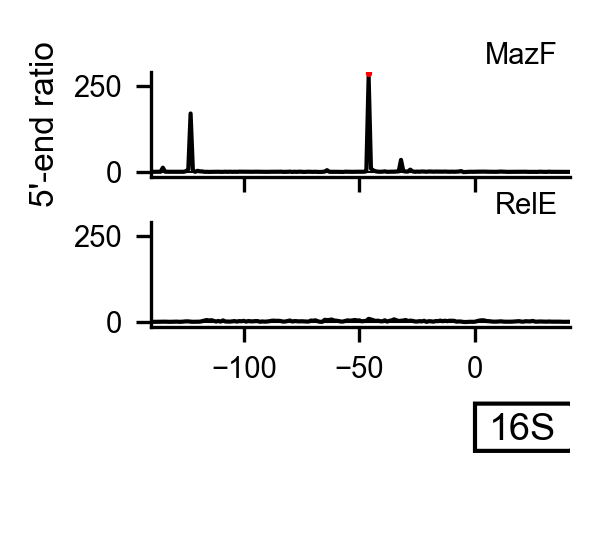

In [76]:
upstream, downstream = 140, -1500
gene_name = '16S'
gene_start = start_index
gene_end   = end_index

# make an alignment gene table
alignment_gene_table = pd.DataFrame(columns=['strand', 'start', 'end', 'plt_tag'],
                               data=[[0, gene_start, gene_end, gene_name]])
# prepare the genome window for plotting
window = gw.GenomeWindow(gene_table = alignment_gene_table, genome = '-'*len(no_gaps_index), gene_name_column='plt_tag', axes_heights = [.35,.35,.35], fig_width=1.8,)
# set position
window.setpositionbygene(name=gene_name, nt_5=upstream, nt_3=downstream)

for i in np.arange(len(title_slice)):
    empty_vector_arrays_30m = data_slice[0]
    toxin_arrays_30m = data_slice[i+1]
    
    window.plotdatastreams(axis_n = [i], input_data = [2**(np.mean(np.log2(toxin_arrays_30m),0) - np.mean(np.log2(empty_vector_arrays_30m),0))],
                           color = 'k', rasterize_data = False, stream_type = gw.ArrayAsLine, lw = 1, label=title_slice[i])
    
#     window.plotdatastreams(axis_n = [i], input_data = [np.mean(np.log2(toxin_arrays_30m),0) - np.mean(np.log2(empty_vector_arrays_30m),0),],
#                            color = 'k', rasterize_data = False, stream_type = gw.ArrayAsLine, lw = 1, label=title_slice[i])
    # draw a line for each axis
    window.axesdata[i].axhline(0,0,1,c='k',lw=.5)
    
    # generate label text
    legend = window.axesdata[i].legend(bbox_to_anchor=(1, 1.4), loc='upper right',
                                         borderaxespad=0., fontsize=7, frameon=False, handlelength=0, labelcolor ='linecolor', markerscale=0)
    
    legend = window.axesdata[i].legend(bbox_to_anchor=(1, 1.4), loc='upper right',
                                         borderaxespad=0., fontsize=7, frameon=False, handlelength=0, labelcolor ='linecolor', markerscale=0)
# add labels
window.axesdata[0].set_ylabel("5'-end ratio", labelpad=3)

# add line at maximum
window.axesdata[0].axvline(peak_position,.98,1,color = 'r')

# rescale axes
limits = np.asarray([ax.get_ylim() for ax in window.axesdata[:]]).T
[ax.set_ylim(np.min(limits[0]),np.max(limits[1])) for ax in window.axesdata[1:]]


plt.savefig('figure_outputs/S5B_MazF_top_peak.pdf',format='pdf',bbox_inches='tight')

##### YafO #1 Peak at i=568

In [77]:
peak_position = 568 - no_gaps_index[start_index]
data_slice = np.asarray([reindexed_arrays[0]] + [reindexed_arrays[-2]] + [reindexed_arrays[-1]])
title_slice = ['YafO', 'RelE']

window zero at 197, window is not reversed: True


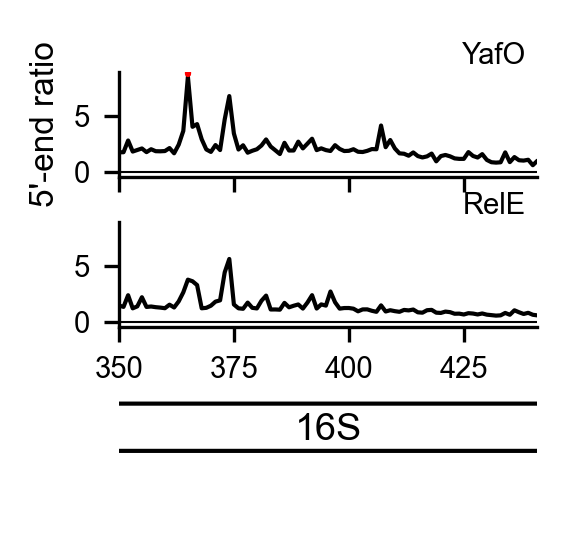

In [78]:
upstream, downstream = -350, -1100
gene_name = '16S'
gene_start = start_index
gene_end   = end_index

# make an alignment gene table
alignment_gene_table = pd.DataFrame(columns=['strand', 'start', 'end', 'plt_tag'],
                               data=[[0, gene_start, gene_end, gene_name]])
# prepare the genome window for plotting
window = gw.GenomeWindow(gene_table = alignment_gene_table, genome = '-'*len(no_gaps_index), gene_name_column='plt_tag', axes_heights = [.35,.35,.35], fig_width=1.8,)
# set position
window.setpositionbygene(name=gene_name, nt_5=upstream, nt_3=downstream)

for i in np.arange(len(title_slice)):
    empty_vector_arrays_30m = data_slice[0]
    toxin_arrays_30m = data_slice[i+1]
    
    window.plotdatastreams(axis_n = [i], input_data = [2**(np.mean(np.log2(toxin_arrays_30m),0) - np.mean(np.log2(empty_vector_arrays_30m),0))],
                           color = 'k', rasterize_data = False, stream_type = gw.ArrayAsLine, lw = 1, label=title_slice[i])
    
#     window.plotdatastreams(axis_n = [i], input_data = [np.mean(np.log2(toxin_arrays_30m),0) - np.mean(np.log2(empty_vector_arrays_30m),0),],
#                            color = 'k', rasterize_data = False, stream_type = gw.ArrayAsLine, lw = 1, label=title_slice[i])
    # draw a line for each axis
    window.axesdata[i].axhline(0,0,1,c='k',lw=.5)
    
    # generate label text
    legend = window.axesdata[i].legend(bbox_to_anchor=(1, 1.4), loc='upper right',
                                         borderaxespad=0., fontsize=7, frameon=False, handlelength=0, labelcolor ='linecolor', markerscale=0)
    
    legend = window.axesdata[i].legend(bbox_to_anchor=(1, 1.4), loc='upper right',
                                         borderaxespad=0., fontsize=7, frameon=False, handlelength=0, labelcolor ='linecolor', markerscale=0)
# add labels
window.axesdata[0].set_ylabel("5'-end ratio", labelpad=3)

# add line at maximum
window.axesdata[0].axvline(peak_position,.98,1,color = 'r')

# rescale axes
limits = np.asarray([ax.get_ylim() for ax in window.axesdata[:]]).T
[ax.set_ylim(np.min(limits[0]),np.max(limits[1])) for ax in window.axesdata[1:]]


plt.savefig('figure_outputs/S5B_YafO_top_peak.pdf',format='pdf',bbox_inches='tight')

##### MqsR #4 Peak at i=709

In [79]:
peak_position = 709 - no_gaps_index[start_index]
data_slice = np.asarray([reindexed_arrays[0]] + [reindexed_arrays[2]] + [reindexed_arrays[-1]])
title_slice = ['MqsR', 'RelE']

window zero at 197, window is not reversed: True


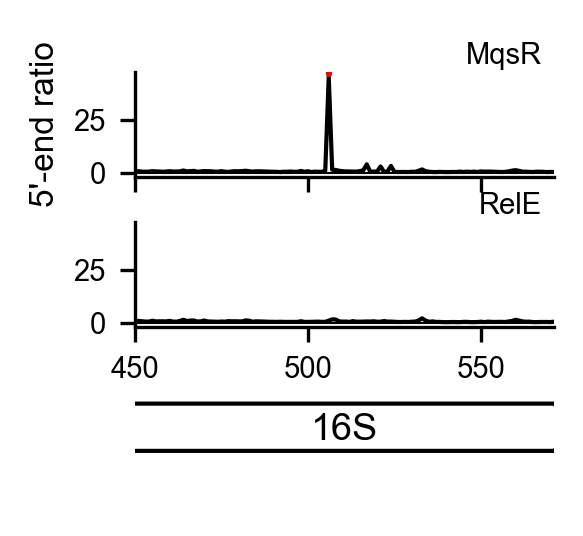

In [80]:
upstream, downstream = -450, -970
gene_name = '16S'
gene_start = start_index
gene_end   = end_index

# make an alignment gene table
alignment_gene_table = pd.DataFrame(columns=['strand', 'start', 'end', 'plt_tag'],
                               data=[[0, gene_start, gene_end, gene_name]])
# prepare the genome window for plotting
window = gw.GenomeWindow(gene_table = alignment_gene_table, genome = '-'*len(no_gaps_index), gene_name_column='plt_tag', axes_heights = [.35,.35,.35], fig_width=1.8,)
# set position
window.setpositionbygene(name=gene_name, nt_5=upstream, nt_3=downstream)

for i in np.arange(len(title_slice)):
    empty_vector_arrays_30m = data_slice[0]
    toxin_arrays_30m = data_slice[i+1]
    
    window.plotdatastreams(axis_n = [i], input_data = [2**(np.mean(np.log2(toxin_arrays_30m),0) - np.mean(np.log2(empty_vector_arrays_30m),0))],
                           color = 'k', rasterize_data = False, stream_type = gw.ArrayAsLine, lw = 1, label=title_slice[i])
    
#     window.plotdatastreams(axis_n = [i], input_data = [np.mean(np.log2(toxin_arrays_30m),0) - np.mean(np.log2(empty_vector_arrays_30m),0),],
#                            color = 'k', rasterize_data = False, stream_type = gw.ArrayAsLine, lw = 1, label=title_slice[i])
    # draw a line for each axis
    window.axesdata[i].axhline(0,0,1,c='k',lw=.5)
    
    # generate label text
    legend = window.axesdata[i].legend(bbox_to_anchor=(1, 1.4), loc='upper right',
                                         borderaxespad=0., fontsize=7, frameon=False, handlelength=0, labelcolor ='linecolor', markerscale=0)
    
    legend = window.axesdata[i].legend(bbox_to_anchor=(1, 1.4), loc='upper right',
                                         borderaxespad=0., fontsize=7, frameon=False, handlelength=0, labelcolor ='linecolor', markerscale=0)
# add labels
window.axesdata[0].set_ylabel("5'-end ratio", labelpad=3)

# add line at maximum
window.axesdata[0].axvline(peak_position,.98,1,color = 'r')

# rescale axes
limits = np.asarray([ax.get_ylim() for ax in window.axesdata[:]]).T
[ax.set_ylim(np.min(limits[0]),np.max(limits[1])) for ax in window.axesdata[1:]]


plt.savefig('figure_outputs/S5B_MqsR_number4_peak.pdf',format='pdf',bbox_inches='tight')

## Figure 5B / 5D: all sucrose gradients quantifying ribosome degradation

### Sucrose gradient plotting functions

In [81]:
import os

def findfiles(directory, terms):
    # output full path of files in directory with search terms, not case sensitive
    found_files = []
    for filename in os.listdir(directory):
        if all([t.lower() in filename.lower() for t in terms]):
            found_files.append(filename)
    if directory[-1] != '/':
        directory+='/'
    return [directory+f for f in found_files]

def window_average(x, y, step, window):
    # get a raveled array for x and y given there may be variable sizes in each data set
    rx = []
    for xi in x: rx = np.r_[rx,xi]
    ry = []
    for yi in y: ry = np.r_[ry,yi]
    new_x = np.arange(np.min(rx),np.max(rx),step)
    # now step through the data and collect windows
    new_y = []
    for xi in new_x:
        new_y.append(np.mean(ry[np.all([rx >= xi-window, rx <= xi+window],axis=0)]))
    return new_x, np.asarray(new_y)

def a260import(abs_file_path, final_fraction_path, skip_fractions=1, rescale=True):
    # load the abs table and remove unimportant data
    table   = pd.read_csv(abs_file_path, skiprows=47)
    columns = [' Position',' AbsA', ' Fraction Number']
    table   = table.loc[:,columns]
    table.columns = ['pos','abs260', 'frac']
    start_i = np.where(table.pos == 0)[0][-1] # last value where position == 0
    # now collect data for plotting
    x = table.pos.values[start_i:]
    y_abs = table.abs260.values[start_i:]
    fracs = table.frac.values[start_i:]
    frac_i = np.r_[0,np.where(fracs != ' ')[0]]
    # skip indicated number of fractions
    x = x[frac_i[skip_fractions]:]
    y_abs = y_abs[frac_i[skip_fractions]:]
    frac_i = frac_i[skip_fractions:] - frac_i[skip_fractions]
    # get fraction bounds and fraction middle positions
    frac_bounds = x[frac_i]
    frac_middles = np.mean([frac_bounds[:-1], frac_bounds[1:]],axis=0)
    if rescale is True:
        # rescale y_abs data between 0 and 1; rescale final_fraction_a260 between 0 and 1
        rescaled_y_abs = (y_abs - np.min(y_abs))/(np.max(y_abs) - np.min(y_abs))
        if final_fraction_path is None:
            return x, rescaled_y_abs, None, frac_bounds, frac_middles
        else:
            # get the final fraction a260 value from file and rescale
            final_fraction_a260 = pd.read_csv(final_fraction_path,index_col=0).loc[abs_file_path.split('/')[-1].split('.')[0],'a260']
            rescaled_ff_a260 = (final_fraction_a260 - np.min(y_abs))/(np.max(y_abs) - np.min(y_abs))
            return x, rescaled_y_abs, rescaled_ff_a260, frac_bounds, frac_middles
    if rescale is False:
        if final_fraction_path is None:
            return x, y_abs, None, frac_bounds, frac_middles
        else:
            # get the final fraction a260 value from file and rescale
            final_fraction_a260 = pd.read_csv(final_fraction_path,index_col=0).loc[abs_file_path.split('/')[-1].split('.')[0],'a260']
            rescaled_ff_a260 = (final_fraction_a260 - np.min(y_abs))/(np.max(y_abs) - np.min(y_abs))
            return x, y_abs, final_fraction_a260, frac_bounds, frac_middles
        

def a260profileplot(axis, x, y, ff_a260, frac_bounds, color='b', lw=.5):
    axis.plot(x[x <= frac_bounds[-3]], y[x <= frac_bounds[-3]], c=color,lw=lw)
    axis.plot([x[x <= frac_bounds[-3]][-1],frac_bounds[-2]],
                [y[x <= frac_bounds[-3]][-1],ff_a260],
                c=color,lw=lw)
    
def importboundaries(a260_directory, file_terms):
    list_boundaries = []
    for f in findfiles(a260_directory, file_terms):
        _, _, _, fraction_boundaries, _ = a260import(f, None)
        list_boundaries.append(fraction_boundaries)
    return np.asarray(list_boundaries)

def fractiona260(list_x, list_y, list_y_final, boundaries, normalization_path):
    # iterate across x_list, y_list, final_list
    y_values = []
    for x,y,final in zip(list_x, list_y, list_y_final):
        # get mean values for each bound
        y_values.append([np.mean(y[np.all([x>b[0],x<=b[1]],axis=0)]) for b in boundaries] # get mean readings for each region
                         + [final]) # add the final blanked concentration as well
    # now calculate the fraction of signal using the volume normalization
    normalization_values = pd.read_csv(vol_normalization_path).normalization.values
    normalized_y_values = np.asarray(y_values) * normalization_values.reshape(1,-1)
    normalized_y_values = normalized_y_values/normalized_y_values.sum(axis=1).reshape(-1,1)
    return normalized_y_values

def a260data(axis, a260_directory, file_terms, final_fraction_path, fraction_boundaries, rescale=True,
             each_kwargs=None, average_kwargs=None, boundary_kwargs=None, fraction_kwargs=None):
    # import all a260 data
    list_x, list_y, list_y_final = [[],[],[]]
    for f in findfiles(a260_directory, file_terms):
        x, y, y_final, _, _ = a260import(f, final_fraction_path, rescale=rescale)
        list_x.append(x)
        list_y.append(y)
        list_y_final.append(y_final)
        # plot each a260 if required
        if each_kwargs is not None:
            # plot the main trace
            axis.plot(x[x <= fraction_boundaries[-3]], y[x <= fraction_boundaries[-3]], **each_kwargs)
            # plot the final fraction
            axis.plot([x[x <= fraction_boundaries[-3]][-1],fraction_boundaries[-2]],[y[x <= fraction_boundaries[-3]][-1],y_final], **each_kwargs)    
    if boundary_kwargs is not None:
        for x in fraction_boundaries[:-2]:
            ax.axvline(x,0,1,**boundary_kwargs)
    if fraction_kwargs is not None:
        pass
    if average_kwargs is not None:
        avg_x, avg_y = window_average(list_x, list_y, .5, .5)
        axis.plot(avg_x[avg_x <= fraction_boundaries[-3]], avg_y[avg_x <= fraction_boundaries[-3]], **average_kwargs)
        try:
            average_kwargs.pop('label')
        except:
            pass
        axis.plot([avg_x[avg_x <= fraction_boundaries[-3]][-1],
                   fraction_boundaries[-2]],[avg_y[avg_x <= fraction_boundaries[-3]][-1],np.mean(list_y_final)], **average_kwargs)
    return list_x, list_y, list_y_final

def loadcolumns(columns, file_path):
    csv_df = pd.read_csv(file_path)
    if columns is None:
        print(csv_df.columns.values)
    else:
        return np.asarray([csv_df[c_name].values for c_name in columns])

def fractioncpm(cpm_path, data_terms, vol_norm_path, cpm_norm_path):
    cpm_data = pd.read_csv(cpm_file,header=1)
    selected_data = []
    for col in cpm_data.columns:
        if any([(t in col) for t in data_terms]):
            selected_data.append(cpm_data.loc[:,col].values)
    eff_norm = loadcolumns(['normalization'],cpm_norm_path)
    vol_norm = loadcolumns(['normalization'],vol_norm_path)
    total_signal = np.asarray(selected_data) * eff_norm * vol_norm
    total_percent = total_signal/total_signal.sum(1).reshape((-1,1))*100 # normalize by total signal
    return total_percent


def log2cpmdata(axis, cpm_path, data_terms, vol_normalization_path, cpm_normalization_path, fraction_boundaries,
            each_kwargs=None, each_wobble=None, average_kwargs=None, tick_step=5):
    cpm_total_percents = fractioncpm(cpm_path, data_terms, vol_normalization_path, cpm_normalization_path)
    # prepare the figure
    fig = axis.get_figure()
    sns.despine(ax=axis)
    ax_cpm = fig.subplots(1,sharex=True) # make axis, move to overlay existing axis
    x0,y0,x1,y1 = axis.get_position().bounds
    ax_cpm.set_position((x0,y0,x1,y1))
    # now plot the actual data
    x_positions = np.r_[np.mean(np.asarray([fraction_boundaries[:-3],fraction_boundaries[1:-2]]),axis=0), [fraction_boundaries[-2]]]
    if each_kwargs is not None:
        for y in cpm_total_percents:
            ax_cpm.plot(x_positions,y,**each_kwargs)
            if each_wobble is not None:
                pass
    if average_kwargs is not None:
        ax_cpm.plot(x_positions,np.mean(cpm_total_percents,0),**average_kwargs)
    # make some visual changes to the axis
    sns.despine(ax=ax_cpm,left=True,right=False,bottom=True)
    ax_cpm.set_yscale("log")
    ax_cpm.set_facecolor('None')
    ax_cpm.yaxis.tick_right()
    ax_cpm.set_xticks([])
    ax_cpm.spines['right'].set_color('red')
    ax_cpm.tick_params(axis='y', which='both', colors='red', pad = 0)
    ax_cpm.set_xlim(axis.get_xlim())
    return ax_cpm

directory = '/home/pculviner/notebook/projects/PCe22/sucrose_gradients/a260/'
terms = ['ev']
final_fraction_file = '/home/pculviner/notebook/projects/PCe22/sucrose_gradients/a260/a260_final_fraction.csv'
vol_normalization_path = '/home/pculviner/notebook/projects/PCe22/sucrose_gradients/normalizations/volume_normalization.csv'
cpm_normalization_path = '/home/pculviner/notebook/projects/PCe22/sucrose_gradients/normalizations/cpmb_normalization.csv'
# get mean boundaries
mean_boundaries = np.mean(importboundaries('/home/pculviner/notebook/projects/PCe22/sucrose_gradients/a260/', ['ev']),axis=0)
pair_boundaries = np.asarray([mean_boundaries[:-3],mean_boundaries[1:-2]]).T

### Plots

In [82]:
search_terms = [ 'ev',
           'MazF',
           'ChpB',
           'HicA',
           'MqsR',
           'RelE',
           'YhaV',
           'HigB',
           'YoeB',
           'YafO',]

titles = [ 'empty',
           'MazF',
           'ChpB',
           'HicA',
           'MqsR',
           'RelE',
           'YhaV',
           'HigB',
           'YoeB',
           'YafO',]

cpm_file = '/home/pculviner/notebook/projects/PCe22/sucrose_gradients/cpm/ribodeg_cpmb.csv'

/home/pculviner/miniconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/pculviner/miniconda3/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/pculviner/miniconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/pculviner/miniconda3/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/pculviner/miniconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/pculviner/miniconda3/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value en

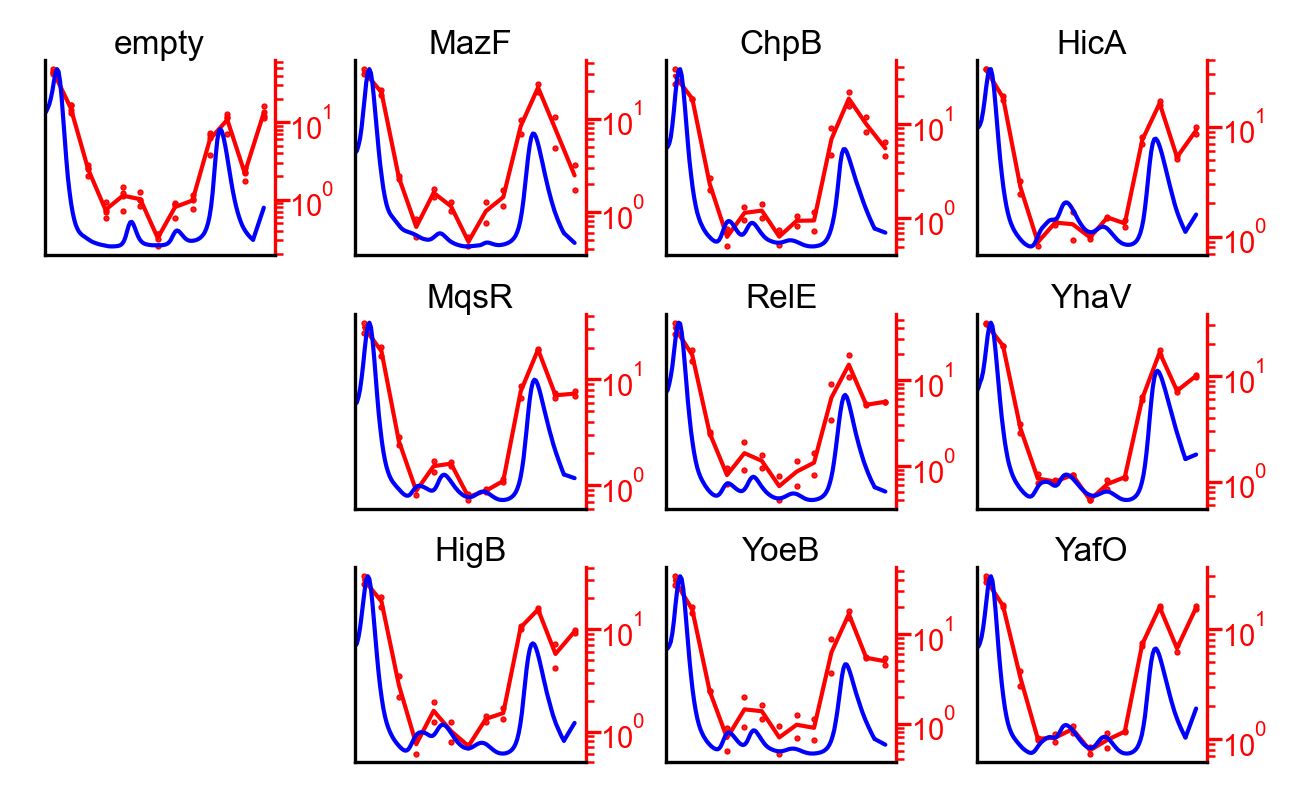

In [83]:
# now plot all the things
fig,axes_260 = plt.subplots(3,4,figsize=(5,3.1),gridspec_kw = {'wspace':.35,'hspace':.3})
axes_260[1][0].set_visible(False)
axes_260[2][0].set_visible(False)
for ax,term,title in zip(np.r_[axes_260[0],axes_260[1][1:],axes_260[2][1:]],search_terms,titles):
    a260data(ax, directory, [term], final_fraction_file, mean_boundaries, rescale=True,
             each_kwargs=None,
             average_kwargs={'lw':1, 'c':'b', 'zorder':1},
             boundary_kwargs=None)
    sns.despine(ax=ax)
    ax.set_yticks([])
    ax.set_xticks([])
    ax.set_title(title,pad=-3,loc='center',fontsize=8)
    
    ax_cpm = log2cpmdata(ax, cpm_file, [term.lower()], vol_normalization_path, cpm_normalization_path,  mean_boundaries, tick_step=10,
                         each_kwargs={'c':'r','lw':0,'marker':'.','markersize':1, 'zorder':1},
                         average_kwargs={'c':'r','lw':1,'zorder':1})
    # rescale x limits
    lims = ax.dataLim.bounds[0],ax.get_xlim()[1]
    ax.set_xlim(*lims)
    ax_cpm.set_xlim(*lims)
    ax.set_facecolor('None')
    ax.set_zorder(2)
    ax_cpm.set_zorder(1)

plt.savefig('figure_outputs/5B_degradation.pdf',format='pdf',bbox_inches='tight')

/home/pculviner/miniconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/pculviner/miniconda3/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/pculviner/miniconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/pculviner/miniconda3/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/pculviner/miniconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/pculviner/miniconda3/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value en

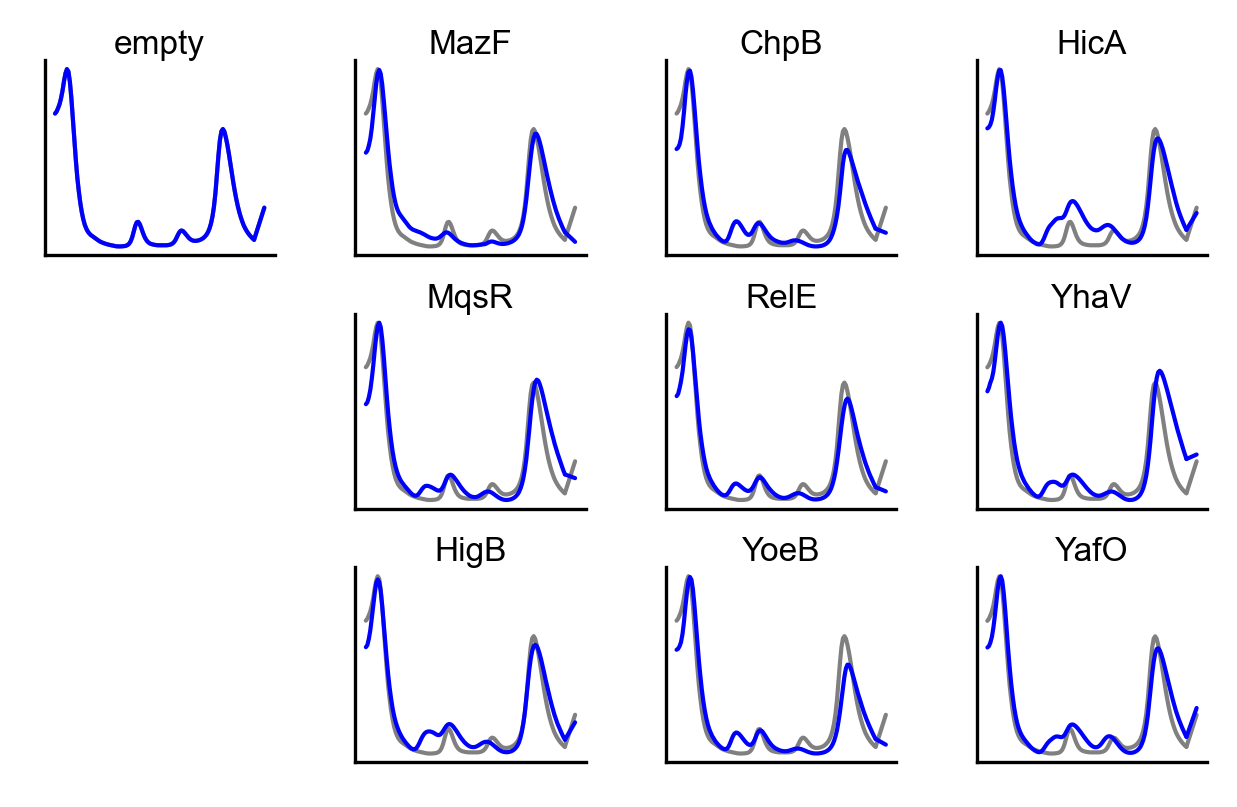

In [84]:
# now plot all the things
fig,axes_260 = plt.subplots(3,4,figsize=(5,3.1),gridspec_kw = {'wspace':.35,'hspace':.3})
axes_260[1][0].set_visible(False)
axes_260[2][0].set_visible(False)
for ax,term,title in zip(np.r_[axes_260[0],axes_260[1][1:],axes_260[2][1:]],search_terms,titles):
    a260data(ax, directory, [search_terms[0]], final_fraction_file, mean_boundaries, rescale=True,
             each_kwargs=None,
             average_kwargs={'lw':1, 'c':'grey', 'zorder':1},
             boundary_kwargs=None)
    
    a260data(ax, directory, [term], final_fraction_file, mean_boundaries, rescale=True,
             each_kwargs=None,
             average_kwargs={'lw':1, 'c':'b', 'zorder':1},
             boundary_kwargs=None)
    sns.despine(ax=ax)
    ax.set_yticks([])
    ax.set_xticks([])
    ax.set_title(title,pad=-3,loc='center',fontsize=8)

plt.savefig('figure_outputs/5D_a260_only.pdf',format='pdf',bbox_inches='tight')

## Figure 5C: heatmaps quantifying degradation

### Sucrose gradient plotting functions

In [85]:
import os

def findfiles(directory, terms):
    # output full path of files in directory with search terms, not case sensitive
    found_files = []
    for filename in os.listdir(directory):
        if all([t.lower() in filename.lower() for t in terms]):
            found_files.append(filename)
    if directory[-1] != '/':
        directory+='/'
    return [directory+f for f in found_files]

def window_average(x, y, step, window):
    # get a raveled array for x and y given there may be variable sizes in each data set
    rx = []
    for xi in x: rx = np.r_[rx,xi]
    ry = []
    for yi in y: ry = np.r_[ry,yi]
    new_x = np.arange(np.min(rx),np.max(rx),step)
    # now step through the data and collect windows
    new_y = []
    for xi in new_x:
        new_y.append(np.mean(ry[np.all([rx >= xi-window, rx <= xi+window],axis=0)]))
    return new_x, np.asarray(new_y)

def a260import(abs_file_path, final_fraction_path, skip_fractions=1, rescale=True):
    # load the abs table and remove unimportant data
    table   = pd.read_csv(abs_file_path, skiprows=47)
    columns = [' Position',' AbsA', ' Fraction Number']
    table   = table.loc[:,columns]
    table.columns = ['pos','abs260', 'frac']
    start_i = np.where(table.pos == 0)[0][-1] # last value where position == 0
    # now collect data for plotting
    x = table.pos.values[start_i:]
    y_abs = table.abs260.values[start_i:]
    fracs = table.frac.values[start_i:]
    frac_i = np.r_[0,np.where(fracs != ' ')[0]]
    # skip indicated number of fractions
    x = x[frac_i[skip_fractions]:]
    y_abs = y_abs[frac_i[skip_fractions]:]
    frac_i = frac_i[skip_fractions:] - frac_i[skip_fractions]
    # get fraction bounds and fraction middle positions
    frac_bounds = x[frac_i]
    frac_middles = np.mean([frac_bounds[:-1], frac_bounds[1:]],axis=0)
    if rescale is True:
        # rescale y_abs data between 0 and 1; rescale final_fraction_a260 between 0 and 1
        rescaled_y_abs = (y_abs - np.min(y_abs))/(np.max(y_abs) - np.min(y_abs))
        if final_fraction_path is None:
            return x, rescaled_y_abs, None, frac_bounds, frac_middles
        else:
            # get the final fraction a260 value from file and rescale
            final_fraction_a260 = pd.read_csv(final_fraction_path,index_col=0).loc[abs_file_path.split('/')[-1].split('.')[0],'a260']
            rescaled_ff_a260 = (final_fraction_a260 - np.min(y_abs))/(np.max(y_abs) - np.min(y_abs))
            return x, rescaled_y_abs, rescaled_ff_a260, frac_bounds, frac_middles
    if rescale is False:
        if final_fraction_path is None:
            return x, y_abs, None, frac_bounds, frac_middles
        else:
            # get the final fraction a260 value from file and rescale
            final_fraction_a260 = pd.read_csv(final_fraction_path,index_col=0).loc[abs_file_path.split('/')[-1].split('.')[0],'a260']
            rescaled_ff_a260 = (final_fraction_a260 - np.min(y_abs))/(np.max(y_abs) - np.min(y_abs))
            return x, y_abs, final_fraction_a260, frac_bounds, frac_middles
        

def a260profileplot(axis, x, y, ff_a260, frac_bounds, color='b', lw=.5):
    axis.plot(x[x <= frac_bounds[-3]], y[x <= frac_bounds[-3]], c=color,lw=lw)
    axis.plot([x[x <= frac_bounds[-3]][-1],frac_bounds[-2]],
                [y[x <= frac_bounds[-3]][-1],ff_a260],
                c=color,lw=lw)
    
def importboundaries(a260_directory, file_terms):
    list_boundaries = []
    for f in findfiles(a260_directory, file_terms):
        _, _, _, fraction_boundaries, _ = a260import(f, None)
        list_boundaries.append(fraction_boundaries)
    return np.asarray(list_boundaries)

def fractiona260(list_x, list_y, list_y_final, boundaries, normalization_path):
    # iterate across x_list, y_list, final_list
    y_values = []
    for x,y,final in zip(list_x, list_y, list_y_final):
        # get mean values for each bound
        y_values.append([np.mean(y[np.all([x>b[0],x<=b[1]],axis=0)]) for b in boundaries] # get mean readings for each region
                         + [final]) # add the final blanked concentration as well
    # now calculate the fraction of signal using the volume normalization
    normalization_values = pd.read_csv(vol_normalization_path).normalization.values
    normalized_y_values = np.asarray(y_values) * normalization_values.reshape(1,-1)
    normalized_y_values = normalized_y_values/normalized_y_values.sum(axis=1).reshape(-1,1)
    return normalized_y_values

def a260data(axis, a260_directory, file_terms, final_fraction_path, fraction_boundaries, rescale=True,
             each_kwargs=None, average_kwargs=None, boundary_kwargs=None, fraction_kwargs=None):
    # import all a260 data
    list_x, list_y, list_y_final = [[],[],[]]
    for f in findfiles(a260_directory, file_terms):
        x, y, y_final, _, _ = a260import(f, final_fraction_path, rescale=rescale)
        list_x.append(x)
        list_y.append(y)
        list_y_final.append(y_final)
        # plot each a260 if required
        if each_kwargs is not None:
            # plot the main trace
            axis.plot(x[x <= fraction_boundaries[-3]], y[x <= fraction_boundaries[-3]], **each_kwargs)
            # plot the final fraction
            axis.plot([x[x <= fraction_boundaries[-3]][-1],fraction_boundaries[-2]],[y[x <= fraction_boundaries[-3]][-1],y_final], **each_kwargs)    
    if boundary_kwargs is not None:
        for x in fraction_boundaries[:-2]:
            ax.axvline(x,0,1,**boundary_kwargs)
    if fraction_kwargs is not None:
        pass
    if average_kwargs is not None:
        avg_x, avg_y = window_average(list_x, list_y, .5, .5)
        axis.plot(avg_x[avg_x <= fraction_boundaries[-3]], avg_y[avg_x <= fraction_boundaries[-3]], **average_kwargs)
        try:
            average_kwargs.pop('label')
        except:
            pass
        axis.plot([avg_x[avg_x <= fraction_boundaries[-3]][-1],
                   fraction_boundaries[-2]],[avg_y[avg_x <= fraction_boundaries[-3]][-1],np.mean(list_y_final)], **average_kwargs)
    return list_x, list_y, list_y_final

def loadcolumns(columns, file_path):
    csv_df = pd.read_csv(file_path)
    if columns is None:
        print(csv_df.columns.values)
    else:
        return np.asarray([csv_df[c_name].values for c_name in columns])

def fractioncpm(cpm_path, data_terms, vol_norm_path, cpm_norm_path):
    cpm_data = pd.read_csv(cpm_file,header=1)
    selected_data = []
    for col in cpm_data.columns:
        if any([(t in col) for t in data_terms]):
            selected_data.append(cpm_data.loc[:,col].values)
    eff_norm = loadcolumns(['normalization'],cpm_norm_path)
    vol_norm = loadcolumns(['normalization'],vol_norm_path)
    total_signal = np.asarray(selected_data) * eff_norm * vol_norm
    total_percent = total_signal/total_signal.sum(1).reshape((-1,1))*100 # normalize by total signal
    return total_percent


def log2cpmdata(axis, cpm_path, data_terms, vol_normalization_path, cpm_normalization_path, fraction_boundaries,
            each_kwargs=None, each_wobble=None, average_kwargs=None, tick_step=5):
    cpm_total_percents = fractioncpm(cpm_path, data_terms, vol_normalization_path, cpm_normalization_path)
    # prepare the figure
    fig = axis.get_figure()
    sns.despine(ax=axis)
    ax_cpm = fig.subplots(1,sharex=True) # make axis, move to overlay existing axis
    x0,y0,x1,y1 = axis.get_position().bounds
    ax_cpm.set_position((x0,y0,x1,y1))
    # now plot the actual data
    x_positions = np.r_[np.mean(np.asarray([fraction_boundaries[:-3],fraction_boundaries[1:-2]]),axis=0), [fraction_boundaries[-2]]]
    if each_kwargs is not None:
        for y in cpm_total_percents:
            ax_cpm.plot(x_positions,y,**each_kwargs)
            if each_wobble is not None:
                pass
    if average_kwargs is not None:
        ax_cpm.plot(x_positions,np.mean(cpm_total_percents,0),**average_kwargs)
    # make some visual changes to the axis
    sns.despine(ax=ax_cpm,left=True,right=False,bottom=True)
    ax_cpm.set_yscale("log")
    ax_cpm.set_facecolor('None')
    ax_cpm.yaxis.tick_right()
    ax_cpm.set_xticks([])
    ax_cpm.spines['right'].set_color('red')
    ax_cpm.tick_params(axis='y', which='both', colors='red', pad = 0)
    ax_cpm.set_xlim(axis.get_xlim())
    return ax_cpm

directory = '/home/pculviner/notebook/projects/PCe22/sucrose_gradients/a260/'
terms = ['ev']
final_fraction_file = '/home/pculviner/notebook/projects/PCe22/sucrose_gradients/a260/a260_final_fraction.csv'
vol_normalization_path = '/home/pculviner/notebook/projects/PCe22/sucrose_gradients/normalizations/volume_normalization.csv'
cpm_normalization_path = '/home/pculviner/notebook/projects/PCe22/sucrose_gradients/normalizations/cpmb_normalization.csv'
# get mean boundaries
mean_boundaries = np.mean(importboundaries('/home/pculviner/notebook/projects/PCe22/sucrose_gradients/a260/', ['ev']),axis=0)
pair_boundaries = np.asarray([mean_boundaries[:-3],mean_boundaries[1:-2]]).T

### Generate heatmap

In [86]:
search_terms = [ 'ev',
           'MazF',
           'ChpB',
           'HicA',
           'MqsR',
           'RelE',
           'YhaV',
           'HigB',
           'YoeB',
           'YafO',]

titles = [ 'empty',
           'MazF',
           'ChpB',
           'HicA',
           'MqsR',
           'RelE',
           'YhaV',
           'HigB',
           'YoeB',
           'YafO',]

cpm_file = '/home/pculviner/notebook/projects/PCe22/sucrose_gradients/cpm/ribodeg_cpmb.csv'

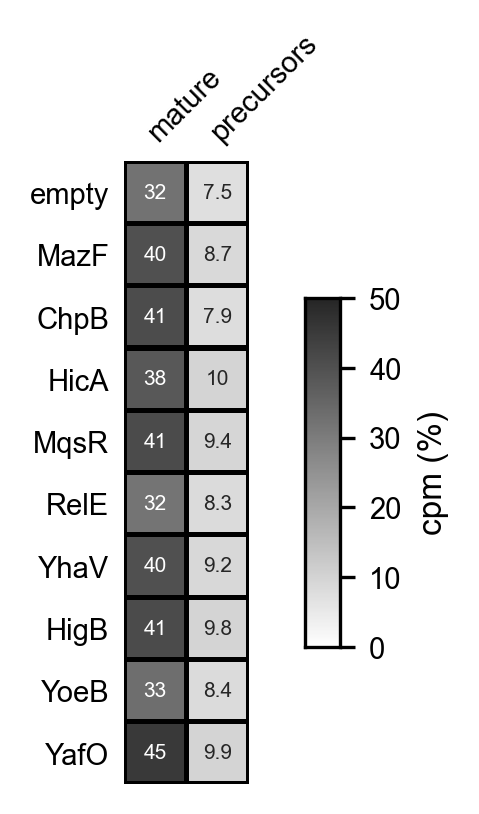

In [87]:
def moveaxis(ax, dx=0, dy=0):
    # where x and y are in inches on final figure
    fig = ax.get_figure()
    ax_coor = ax.get_position()
    dx = dx / fig.get_figwidth() # convert to figure coordinates
    dy = dy / fig.get_figheight() #  .5 = 2 1 # .25  = 2 .5
    ax.set_position([ax_coor.x0+dx, ax_coor.y0+dy, ax_coor.x1-ax_coor.x0, ax_coor.y1-ax_coor.y0])

mature_ribosomes = []
precursor_regions = [] 
for term in search_terms:
    cpm_total_percents = fractioncpm(cpm_file, [term.lower()], vol_normalization_path, cpm_normalization_path)
    mature_ribosomes.append(np.mean(np.sum(cpm_total_percents[:,-4:],axis=1)))
    precursor_regions.append(np.mean(np.sum(cpm_total_percents[:,2:-4],axis=1)))

data = pd.DataFrame(columns=['mature', 'precursors'], data=np.asarray([mature_ribosomes,precursor_regions]).T, index=titles)

fig,ax = plt.subplots(1, figsize=(1,2.75))

discrete_white_black = sns.color_palette("dark:white_r",as_cmap=True)
sns.heatmap(data = data, cmap=discrete_white_black, vmin=0, vmax=50, annot=True, annot_kws={'fontsize':5},
            ax = ax, xticklabels=False, yticklabels=False, square = True, linewidth = 1, linecolor='k', cbar_kws={'shrink':1, 'use_gridspec':False, 'aspect':10, 'location':'right'})

ax.tick_params(axis='both', which='both',length=0)
ax.set_yticks(np.arange(len(data.index))+.5)
ax.set_yticklabels(data.index,fontsize=7)

ax.tick_params(axis='x', which='major',length=0, labelrotation=45, labeltop=True, labelbottom=False,)
ax.set_xticks(np.arange(len(data.columns))+.3)
ax.set_xticklabels(data.columns,fontsize=7,ha='left')
fig.axes[1].set_frame_on(True)
fig.axes[1].set_ylabel('cpm (%)')
moveaxis(fig.axes[1], dx=.15)
plt.savefig('figure_outputs/5C_degradation_quantification.pdf',format='pdf',bbox_inches='tight')

# Figure 6

## Figure 6A: all sucrose gradient quantifying ribosome maturation

### Sucrose gradient plotting functions

In [88]:
import os

def findfiles(directory, terms):
    # output full path of files in directory with search terms, not case sensitive
    found_files = []
    for filename in os.listdir(directory):
        if all([t.lower() in filename.lower() for t in terms]):
            found_files.append(filename)
    if directory[-1] != '/':
        directory+='/'
    return [directory+f for f in found_files]

def window_average(x, y, step, window):
    # get a raveled array for x and y given there may be variable sizes in each data set
    rx = []
    for xi in x: rx = np.r_[rx,xi]
    ry = []
    for yi in y: ry = np.r_[ry,yi]
    new_x = np.arange(np.min(rx),np.max(rx),step)
    # now step through the data and collect windows
    new_y = []
    for xi in new_x:
        new_y.append(np.mean(ry[np.all([rx >= xi-window, rx <= xi+window],axis=0)]))
    return new_x, np.asarray(new_y)

def a260import(abs_file_path, final_fraction_path, skip_fractions=1, rescale=True):
    # load the abs table and remove unimportant data
    table   = pd.read_csv(abs_file_path, skiprows=47)
    columns = [' Position',' AbsA', ' Fraction Number']
    table   = table.loc[:,columns]
    table.columns = ['pos','abs260', 'frac']
    start_i = np.where(table.pos == 0)[0][-1] # last value where position == 0
    # now collect data for plotting
    x = table.pos.values[start_i:]
    y_abs = table.abs260.values[start_i:]
    fracs = table.frac.values[start_i:]
    frac_i = np.r_[0,np.where(fracs != ' ')[0]]
    # skip indicated number of fractions
    x = x[frac_i[skip_fractions]:]
    y_abs = y_abs[frac_i[skip_fractions]:]
    frac_i = frac_i[skip_fractions:] - frac_i[skip_fractions]
    # get fraction bounds and fraction middle positions
    frac_bounds = x[frac_i]
    frac_middles = np.mean([frac_bounds[:-1], frac_bounds[1:]],axis=0)
    if rescale is True:
        # rescale y_abs data between 0 and 1; rescale final_fraction_a260 between 0 and 1
        rescaled_y_abs = (y_abs - np.min(y_abs))/(np.max(y_abs) - np.min(y_abs))
        if final_fraction_path is None:
            return x, rescaled_y_abs, None, frac_bounds, frac_middles
        else:
            # get the final fraction a260 value from file and rescale
            final_fraction_a260 = pd.read_csv(final_fraction_path,index_col=0).loc[abs_file_path.split('/')[-1].split('.')[0],'a260']
            rescaled_ff_a260 = (final_fraction_a260 - np.min(y_abs))/(np.max(y_abs) - np.min(y_abs))
            return x, rescaled_y_abs, rescaled_ff_a260, frac_bounds, frac_middles
    if rescale is False:
        if final_fraction_path is None:
            return x, y_abs, None, frac_bounds, frac_middles
        else:
            # get the final fraction a260 value from file and rescale
            final_fraction_a260 = pd.read_csv(final_fraction_path,index_col=0).loc[abs_file_path.split('/')[-1].split('.')[0],'a260']
            rescaled_ff_a260 = (final_fraction_a260 - np.min(y_abs))/(np.max(y_abs) - np.min(y_abs))
            return x, y_abs, final_fraction_a260, frac_bounds, frac_middles
        

def a260profileplot(axis, x, y, ff_a260, frac_bounds, color='b', lw=.5):
    axis.plot(x[x <= frac_bounds[-3]], y[x <= frac_bounds[-3]], c=color,lw=lw)
    axis.plot([x[x <= frac_bounds[-3]][-1],frac_bounds[-2]],
                [y[x <= frac_bounds[-3]][-1],ff_a260],
                c=color,lw=lw)
    
def importboundaries(a260_directory, file_terms):
    list_boundaries = []
    for f in findfiles(a260_directory, file_terms):
        _, _, _, fraction_boundaries, _ = a260import(f, None)
        list_boundaries.append(fraction_boundaries)
    return np.asarray(list_boundaries)

def fractiona260(list_x, list_y, list_y_final, boundaries, normalization_path):
    # iterate across x_list, y_list, final_list
    y_values = []
    for x,y,final in zip(list_x, list_y, list_y_final):
        # get mean values for each bound
        y_values.append([np.mean(y[np.all([x>b[0],x<=b[1]],axis=0)]) for b in boundaries] # get mean readings for each region
                         + [final]) # add the final blanked concentration as well
    # now calculate the fraction of signal using the volume normalization
    normalization_values = pd.read_csv(vol_normalization_path).normalization.values
    normalized_y_values = np.asarray(y_values) * normalization_values.reshape(1,-1)
    normalized_y_values = normalized_y_values/normalized_y_values.sum(axis=1).reshape(-1,1)
    return normalized_y_values

def a260data(axis, a260_directory, file_terms, final_fraction_path, fraction_boundaries, rescale=True,
             each_kwargs=None, average_kwargs=None, boundary_kwargs=None, fraction_kwargs=None):
    # import all a260 data
    list_x, list_y, list_y_final = [[],[],[]]
    for f in findfiles(a260_directory, file_terms):
        x, y, y_final, _, _ = a260import(f, final_fraction_path, rescale=rescale)
        list_x.append(x)
        list_y.append(y)
        list_y_final.append(y_final)
        # plot each a260 if required
        if each_kwargs is not None:
            # plot the main trace
            axis.plot(x[x <= fraction_boundaries[-3]], y[x <= fraction_boundaries[-3]], **each_kwargs)
            # plot the final fraction
            axis.plot([x[x <= fraction_boundaries[-3]][-1],fraction_boundaries[-2]],[y[x <= fraction_boundaries[-3]][-1],y_final], **each_kwargs)    
    if boundary_kwargs is not None:
        for x in fraction_boundaries[:-2]:
            ax.axvline(x,0,1,**boundary_kwargs)
    if fraction_kwargs is not None:
        pass
    if average_kwargs is not None:
        avg_x, avg_y = window_average(list_x, list_y, .5, .5)
        axis.plot(avg_x[avg_x <= fraction_boundaries[-3]], avg_y[avg_x <= fraction_boundaries[-3]], **average_kwargs)
        try:
            average_kwargs.pop('label')
        except:
            pass
        axis.plot([avg_x[avg_x <= fraction_boundaries[-3]][-1],
                   fraction_boundaries[-2]],[avg_y[avg_x <= fraction_boundaries[-3]][-1],np.mean(list_y_final)], **average_kwargs)
    return list_x, list_y, list_y_final

def loadcolumns(columns, file_path):
    csv_df = pd.read_csv(file_path)
    if columns is None:
        print(csv_df.columns.values)
    else:
        return np.asarray([csv_df[c_name].values for c_name in columns])

def fractioncpm(cpm_path, data_terms, vol_norm_path, cpm_norm_path):
    cpm_data = pd.read_csv(cpm_file,header=1)
    selected_data = []
    for col in cpm_data.columns:
        if any([(t in col) for t in data_terms]):
            selected_data.append(cpm_data.loc[:,col].values)
    eff_norm = loadcolumns(['normalization'],cpm_norm_path)
    vol_norm = loadcolumns(['normalization'],vol_norm_path)
    total_signal = np.asarray(selected_data) * eff_norm * vol_norm
    total_percent = total_signal/total_signal.sum(1).reshape((-1,1))*100 # normalize by total signal
    return total_percent


def log2cpmdata(axis, cpm_path, data_terms, vol_normalization_path, cpm_normalization_path, fraction_boundaries,
            each_kwargs=None, each_wobble=None, average_kwargs=None, tick_step=5):
    cpm_total_percents = fractioncpm(cpm_path, data_terms, vol_normalization_path, cpm_normalization_path)
    # prepare the figure
    fig = axis.get_figure()
    sns.despine(ax=axis)
    ax_cpm = fig.subplots(1,sharex=True) # make axis, move to overlay existing axis
    x0,y0,x1,y1 = axis.get_position().bounds
    ax_cpm.set_position((x0,y0,x1,y1))
    # now plot the actual data
    x_positions = np.r_[np.mean(np.asarray([fraction_boundaries[:-3],fraction_boundaries[1:-2]]),axis=0), [fraction_boundaries[-2]]]
    if each_kwargs is not None:
        for y in cpm_total_percents:
            ax_cpm.plot(x_positions,y,**each_kwargs)
            if each_wobble is not None:
                pass
    if average_kwargs is not None:
        ax_cpm.plot(x_positions,np.mean(cpm_total_percents,0),**average_kwargs)
    # make some visual changes to the axis
    sns.despine(ax=ax_cpm,left=True,right=False,bottom=True)
    ax_cpm.set_yscale("log")
    ax_cpm.set_facecolor('None')
    ax_cpm.yaxis.tick_right()
    ax_cpm.set_xticks([])
    ax_cpm.spines['right'].set_color('red')
    ax_cpm.tick_params(axis='y', which='both', colors='red', pad = 0)
    ax_cpm.set_xlim(axis.get_xlim())
    return ax_cpm

directory = '/home/pculviner/notebook/projects/PCe22/sucrose_gradients/a260/'
terms = ['ev']
final_fraction_file = '/home/pculviner/notebook/projects/PCe22/sucrose_gradients/a260/a260_final_fraction.csv'
vol_normalization_path = '/home/pculviner/notebook/projects/PCe22/sucrose_gradients/normalizations/volume_normalization.csv'
cpm_normalization_path = '/home/pculviner/notebook/projects/PCe22/sucrose_gradients/normalizations/cpmb_normalization.csv'
# get mean boundaries
mean_boundaries = np.mean(importboundaries('/home/pculviner/notebook/projects/PCe22/sucrose_gradients/a260/', ['ev']),axis=0)
pair_boundaries = np.asarray([mean_boundaries[:-3],mean_boundaries[1:-2]]).T

### Plots

In [89]:
search_terms = [ 'ev',
           'MazF',
           'ChpB',
           'HicA',
           'MqsR',
           'RelE',
           'YhaV',
           'HigB',
           'YoeB',
           'YafO',]

titles = [ 'empty',
           'MazF',
           'ChpB',
           'HicA',
           'MqsR',
           'RelE',
           'YhaV',
           'HigB',
           'YoeB',
           'YafO',]

cpm_file = '/home/pculviner/notebook/projects/PCe22/sucrose_gradients/cpm/maturation_cpmb.csv'

/home/pculviner/miniconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/pculviner/miniconda3/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/pculviner/miniconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/pculviner/miniconda3/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/pculviner/miniconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/pculviner/miniconda3/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value en

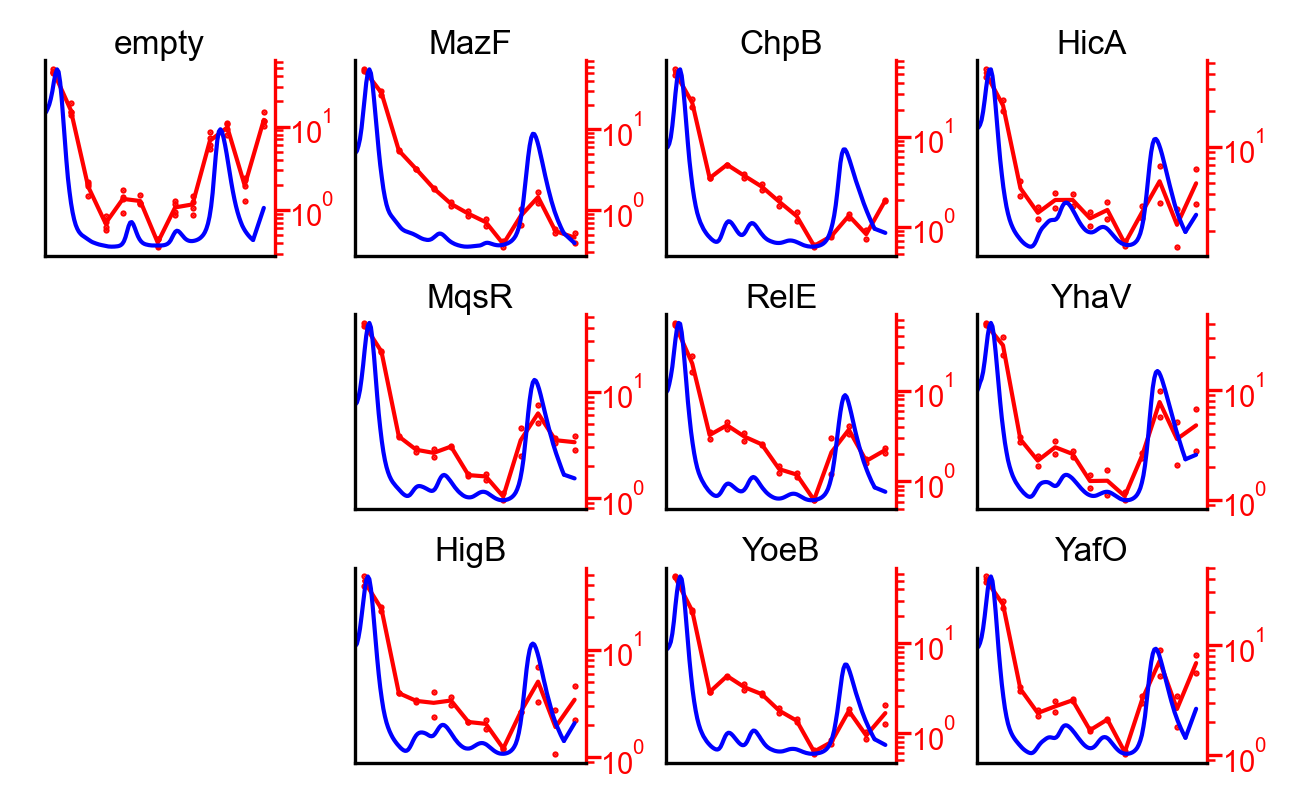

In [90]:
# now plot all the things
fig,axes_260 = plt.subplots(3,4,figsize=(5,3.1),gridspec_kw = {'wspace':.35,'hspace':.3})
axes_260[1][0].set_visible(False)
axes_260[2][0].set_visible(False)
for ax,term,title in zip(np.r_[axes_260[0],axes_260[1][1:],axes_260[2][1:]],search_terms,titles):
    a260data(ax, directory, [term], final_fraction_file, mean_boundaries, rescale=True,
             each_kwargs=None,
             average_kwargs={'lw':1, 'c':'b', 'zorder':1},
             boundary_kwargs=None)
    sns.despine(ax=ax)
    ax.set_yticks([])
    ax.set_xticks([])
    ax.set_title(title,pad=-3,loc='center',fontsize=8)
    
    ax_cpm = log2cpmdata(ax, cpm_file, [term.lower()], vol_normalization_path, cpm_normalization_path,  mean_boundaries, tick_step=10,
                         each_kwargs={'c':'r','lw':0,'marker':'.','markersize':1, 'zorder':1},
                         average_kwargs={'c':'r','lw':1,'zorder':1})
    # rescale x limits
    lims = ax.dataLim.bounds[0],ax.get_xlim()[1]
    ax.set_xlim(*lims)
    ax_cpm.set_xlim(*lims)
    ax.set_facecolor('None')
    ax.set_zorder(2)
    ax_cpm.set_zorder(1)

plt.savefig('figure_outputs/6A_maturation.pdf',format='pdf',bbox_inches='tight')

## Figure 6B: sucrose gradient quantifications / ribosome degradation

### Sucrose gradient plotting functions

In [91]:
import os

def findfiles(directory, terms):
    # output full path of files in directory with search terms, not case sensitive
    found_files = []
    for filename in os.listdir(directory):
        if all([t.lower() in filename.lower() for t in terms]):
            found_files.append(filename)
    if directory[-1] != '/':
        directory+='/'
    return [directory+f for f in found_files]

def window_average(x, y, step, window):
    # get a raveled array for x and y given there may be variable sizes in each data set
    rx = []
    for xi in x: rx = np.r_[rx,xi]
    ry = []
    for yi in y: ry = np.r_[ry,yi]
    new_x = np.arange(np.min(rx),np.max(rx),step)
    # now step through the data and collect windows
    new_y = []
    for xi in new_x:
        new_y.append(np.mean(ry[np.all([rx >= xi-window, rx <= xi+window],axis=0)]))
    return new_x, np.asarray(new_y)

def a260import(abs_file_path, final_fraction_path, skip_fractions=1, rescale=True):
    # load the abs table and remove unimportant data
    table   = pd.read_csv(abs_file_path, skiprows=47)
    columns = [' Position',' AbsA', ' Fraction Number']
    table   = table.loc[:,columns]
    table.columns = ['pos','abs260', 'frac']
    start_i = np.where(table.pos == 0)[0][-1] # last value where position == 0
    # now collect data for plotting
    x = table.pos.values[start_i:]
    y_abs = table.abs260.values[start_i:]
    fracs = table.frac.values[start_i:]
    frac_i = np.r_[0,np.where(fracs != ' ')[0]]
    # skip indicated number of fractions
    x = x[frac_i[skip_fractions]:]
    y_abs = y_abs[frac_i[skip_fractions]:]
    frac_i = frac_i[skip_fractions:] - frac_i[skip_fractions]
    # get fraction bounds and fraction middle positions
    frac_bounds = x[frac_i]
    frac_middles = np.mean([frac_bounds[:-1], frac_bounds[1:]],axis=0)
    if rescale is True:
        # rescale y_abs data between 0 and 1; rescale final_fraction_a260 between 0 and 1
        rescaled_y_abs = (y_abs - np.min(y_abs))/(np.max(y_abs) - np.min(y_abs))
        if final_fraction_path is None:
            return x, rescaled_y_abs, None, frac_bounds, frac_middles
        else:
            # get the final fraction a260 value from file and rescale
            final_fraction_a260 = pd.read_csv(final_fraction_path,index_col=0).loc[abs_file_path.split('/')[-1].split('.')[0],'a260']
            rescaled_ff_a260 = (final_fraction_a260 - np.min(y_abs))/(np.max(y_abs) - np.min(y_abs))
            return x, rescaled_y_abs, rescaled_ff_a260, frac_bounds, frac_middles
    if rescale is False:
        if final_fraction_path is None:
            return x, y_abs, None, frac_bounds, frac_middles
        else:
            # get the final fraction a260 value from file and rescale
            final_fraction_a260 = pd.read_csv(final_fraction_path,index_col=0).loc[abs_file_path.split('/')[-1].split('.')[0],'a260']
            rescaled_ff_a260 = (final_fraction_a260 - np.min(y_abs))/(np.max(y_abs) - np.min(y_abs))
            return x, y_abs, final_fraction_a260, frac_bounds, frac_middles
        

def a260profileplot(axis, x, y, ff_a260, frac_bounds, color='b', lw=.5):
    axis.plot(x[x <= frac_bounds[-3]], y[x <= frac_bounds[-3]], c=color,lw=lw)
    axis.plot([x[x <= frac_bounds[-3]][-1],frac_bounds[-2]],
                [y[x <= frac_bounds[-3]][-1],ff_a260],
                c=color,lw=lw)
    
def importboundaries(a260_directory, file_terms):
    list_boundaries = []
    for f in findfiles(a260_directory, file_terms):
        _, _, _, fraction_boundaries, _ = a260import(f, None)
        list_boundaries.append(fraction_boundaries)
    return np.asarray(list_boundaries)

def fractiona260(list_x, list_y, list_y_final, boundaries, normalization_path):
    # iterate across x_list, y_list, final_list
    y_values = []
    for x,y,final in zip(list_x, list_y, list_y_final):
        # get mean values for each bound
        y_values.append([np.mean(y[np.all([x>b[0],x<=b[1]],axis=0)]) for b in boundaries] # get mean readings for each region
                         + [final]) # add the final blanked concentration as well
    # now calculate the fraction of signal using the volume normalization
    normalization_values = pd.read_csv(vol_normalization_path).normalization.values
    normalized_y_values = np.asarray(y_values) * normalization_values.reshape(1,-1)
    normalized_y_values = normalized_y_values/normalized_y_values.sum(axis=1).reshape(-1,1)
    return normalized_y_values

def a260data(axis, a260_directory, file_terms, final_fraction_path, fraction_boundaries, rescale=True,
             each_kwargs=None, average_kwargs=None, boundary_kwargs=None, fraction_kwargs=None):
    # import all a260 data
    list_x, list_y, list_y_final = [[],[],[]]
    for f in findfiles(a260_directory, file_terms):
        x, y, y_final, _, _ = a260import(f, final_fraction_path, rescale=rescale)
        list_x.append(x)
        list_y.append(y)
        list_y_final.append(y_final)
        # plot each a260 if required
        if each_kwargs is not None:
            # plot the main trace
            axis.plot(x[x <= fraction_boundaries[-3]], y[x <= fraction_boundaries[-3]], **each_kwargs)
            # plot the final fraction
            axis.plot([x[x <= fraction_boundaries[-3]][-1],fraction_boundaries[-2]],[y[x <= fraction_boundaries[-3]][-1],y_final], **each_kwargs)    
    if boundary_kwargs is not None:
        for x in fraction_boundaries[:-2]:
            ax.axvline(x,0,1,**boundary_kwargs)
    if fraction_kwargs is not None:
        pass
    if average_kwargs is not None:
        avg_x, avg_y = window_average(list_x, list_y, .5, .5)
        axis.plot(avg_x[avg_x <= fraction_boundaries[-3]], avg_y[avg_x <= fraction_boundaries[-3]], **average_kwargs)
        try:
            average_kwargs.pop('label')
        except:
            pass
        axis.plot([avg_x[avg_x <= fraction_boundaries[-3]][-1],
                   fraction_boundaries[-2]],[avg_y[avg_x <= fraction_boundaries[-3]][-1],np.mean(list_y_final)], **average_kwargs)
    return list_x, list_y, list_y_final

def loadcolumns(columns, file_path):
    csv_df = pd.read_csv(file_path)
    if columns is None:
        print(csv_df.columns.values)
    else:
        return np.asarray([csv_df[c_name].values for c_name in columns])

def fractioncpm(cpm_path, data_terms, vol_norm_path, cpm_norm_path):
    cpm_data = pd.read_csv(cpm_file,header=1)
    selected_data = []
    for col in cpm_data.columns:
        if any([(t in col) for t in data_terms]):
            selected_data.append(cpm_data.loc[:,col].values)
    eff_norm = loadcolumns(['normalization'],cpm_norm_path)
    vol_norm = loadcolumns(['normalization'],vol_norm_path)
    total_signal = np.asarray(selected_data) * eff_norm * vol_norm
    total_percent = total_signal/total_signal.sum(1).reshape((-1,1))*100 # normalize by total signal
    return total_percent


def log2cpmdata(axis, cpm_path, data_terms, vol_normalization_path, cpm_normalization_path, fraction_boundaries,
            each_kwargs=None, each_wobble=None, average_kwargs=None, tick_step=5):
    cpm_total_percents = fractioncpm(cpm_path, data_terms, vol_normalization_path, cpm_normalization_path)
    # prepare the figure
    fig = axis.get_figure()
    sns.despine(ax=axis)
    ax_cpm = fig.subplots(1,sharex=True) # make axis, move to overlay existing axis
    x0,y0,x1,y1 = axis.get_position().bounds
    ax_cpm.set_position((x0,y0,x1,y1))
    # now plot the actual data
    x_positions = np.r_[np.mean(np.asarray([fraction_boundaries[:-3],fraction_boundaries[1:-2]]),axis=0), [fraction_boundaries[-2]]]
    if each_kwargs is not None:
        for y in cpm_total_percents:
            ax_cpm.plot(x_positions,y,**each_kwargs)
            if each_wobble is not None:
                pass
    if average_kwargs is not None:
        ax_cpm.plot(x_positions,np.mean(cpm_total_percents,0),**average_kwargs)
    # make some visual changes to the axis
    sns.despine(ax=ax_cpm,left=True,right=False,bottom=True)
    ax_cpm.set_yscale("log")
    ax_cpm.set_facecolor('None')
    ax_cpm.yaxis.tick_right()
    ax_cpm.set_xticks([])
    ax_cpm.spines['right'].set_color('red')
    ax_cpm.tick_params(axis='y', which='both', colors='red', pad = 0)
    ax_cpm.set_xlim(axis.get_xlim())
    return ax_cpm

directory = '/home/pculviner/notebook/projects/PCe22/sucrose_gradients/a260/'
terms = ['ev']
final_fraction_file = '/home/pculviner/notebook/projects/PCe22/sucrose_gradients/a260/a260_final_fraction.csv'
vol_normalization_path = '/home/pculviner/notebook/projects/PCe22/sucrose_gradients/normalizations/volume_normalization.csv'
cpm_normalization_path = '/home/pculviner/notebook/projects/PCe22/sucrose_gradients/normalizations/cpmb_normalization.csv'
# get mean boundaries
mean_boundaries = np.mean(importboundaries('/home/pculviner/notebook/projects/PCe22/sucrose_gradients/a260/', ['ev']),axis=0)
pair_boundaries = np.asarray([mean_boundaries[:-3],mean_boundaries[1:-2]]).T

### Generate heatmap

In [92]:
search_terms = [ 'ev',
           'MazF',
           'ChpB',
           'HicA',
           'MqsR',
           'RelE',
           'YhaV',
           'HigB',
           'YoeB',
           'YafO',]

titles = [ 'empty',
           'MazF',
           'ChpB',
           'HicA',
           'MqsR',
           'RelE',
           'YhaV',
           'HigB',
           'YoeB',
           'YafO',]

cpm_file = '/home/pculviner/notebook/projects/PCe22/sucrose_gradients/cpm/maturation_cpmb.csv'

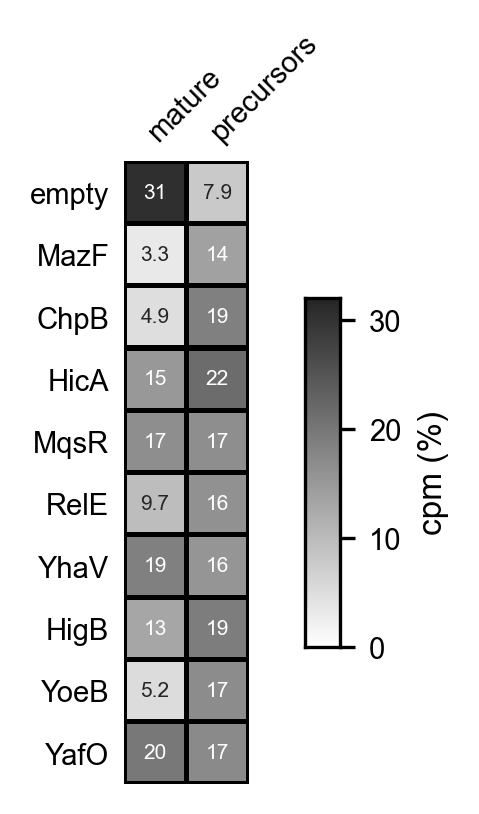

In [93]:
def moveaxis(ax, dx=0, dy=0):
    # where x and y are in inches on final figure
    fig = ax.get_figure()
    ax_coor = ax.get_position()
    dx = dx / fig.get_figwidth() # convert to figure coordinates
    dy = dy / fig.get_figheight() #  .5 = 2 1 # .25  = 2 .5
    ax.set_position([ax_coor.x0+dx, ax_coor.y0+dy, ax_coor.x1-ax_coor.x0, ax_coor.y1-ax_coor.y0])

mature_ribosomes = []
precursor_regions = [] 
for term in search_terms:
    cpm_total_percents = fractioncpm(cpm_file, [term.lower()], vol_normalization_path, cpm_normalization_path)
    mature_ribosomes.append(np.mean(np.sum(cpm_total_percents[:,-4:],axis=1)))
    precursor_regions.append(np.mean(np.sum(cpm_total_percents[:,2:-4],axis=1)))

data = pd.DataFrame(columns=['mature', 'precursors'], data=np.asarray([mature_ribosomes,precursor_regions]).T, index=titles)

fig,ax = plt.subplots(1, figsize=(1,2.75))

discrete_white_black = sns.color_palette("dark:white_r",as_cmap=True)
sns.heatmap(data = data, cmap=discrete_white_black, vmin=0, vmax=32, annot=True, annot_kws={'fontsize':5},
            ax = ax, xticklabels=False, yticklabels=False, square = True, linewidth = 1, linecolor='k', cbar_kws={'shrink':1, 'use_gridspec':False, 'aspect':10, 'location':'right'})

ax.tick_params(axis='both', which='both',length=0)
ax.set_yticks(np.arange(len(data.index))+.5)
ax.set_yticklabels(data.index,fontsize=7)

ax.tick_params(axis='x', which='major',length=0, labelrotation=45, labeltop=True, labelbottom=False,)
ax.set_xticks(np.arange(len(data.columns))+.3)
ax.set_xticklabels(data.columns,fontsize=7,ha='left')
fig.axes[1].set_frame_on(True)
fig.axes[1].set_ylabel('cpm (%)')
moveaxis(fig.axes[1], dx=.15)
plt.savefig('figure_outputs/6B_sucrose_gradient_quantification_maturation.pdf',format='pdf',bbox_inches='tight')

## Figure 6C: rRNA profiles - 16S precursor region

In [94]:
from matplotlib.ticker import MultipleLocator,ScalarFormatter,FuncFormatter
from regex import search

def pullsequence(location, five, three, genome):
    strand, position = location
    if strand == 0:
        return str(genome.seq[position-five:position+three])
    if strand == 1:
        return str(genome.seq[position-three+1:position+five+1].reverse_complement())
    
def muscleAlign(names, sequences):
    # write a temporary fasta file for muscle to read / align
    writeFasta('_temp.fasta', names, sequences)
    # conduct a muscle alignment on the temporary fasta
    subprocess.call(['muscle','-in','_temp.fasta','-out','_temp_aligned.fasta'])
    # import alignments back into python
    names, sequences = readFasta('_temp_aligned.fasta',True)
    # clean up temporary file
    os.remove('_temp.fasta')
    return names, sequences

def writeFasta(filepath, names, sequences):
    # accepts list of names (spaces will be replaced with underscores) and list of sequences, writes to filepath
    with open(filepath,'w') as f:
        for n,seq in zip(names,sequences):
            f.write('>%s\n%s\n'%(n.replace(' ','_'),str(seq)))
    return filepath

def readFasta(filepath, delete=False):
    # returns names and records
    with open(filepath,'r') as f:
        lines = f.readlines()
        # now take out the records
        records = []
        names = []
        current_record = ''
        for line in lines:
            if line[0] == '>':
                names.append(line[1:-1])
                records.append(current_record)
                current_record = ''
            else:
                current_record += line[:-1]
        records.append(current_record)
        names = np.asarray(names)
        records = np.asarray(records[1:])
    if delete: # burn after reading
        os.remove(filepath)
    return names, records

def pullindexdata(target_indexes, alignment_mask, input_data, function = lambda x: x):
    return [function(input_data[alignment_mask == i]) for i in target_indexes]

def loadnormalizearbitraryarrays(target_folder, search_strings = None, verbose = True, normalization_mask = None, pseudo = True):
    # find numpy files in the target folder
    stdout, _ = quickshell('ls %s*.npy'%target_folder, print_output=False, return_output=True)
    all_numpy_files = stdout.split('\n')[:-1]
    # iterate through search strings of shape [[has1,has2,has3...],[not1,not2,not3...]]
    raw_arrays = []
    out_shape = []    
    for i,(has_strings, not_strings) in enumerate(search_strings):
        n = 0
        for file_path in all_numpy_files:
            file_name = file_path.split('/')[-1]
            if all([s.lower() in file_name.lower() for s in has_strings]) and all([s.lower() not in file_name.lower() for s in not_strings]):
                print('group %i: %s'%(i+1,file_name))
                raw_arrays.append(np.load(file_path))
                n+=1
        if n != 0:
            out_shape.append(n)
    # set empty normalization mask if none was given
    if normalization_mask is None:
        normalization_mask = np.zeros(raw_arrays[0].shape).astype(bool)
    # normalize arrays
    normalized_arrays = maskedcountnormalization(raw_arrays, normalization_mask, pseudo = pseudo)
    # reshape into output sets by slicing
    output_arrays = []
    for i in out_shape:
        output_arrays.append(normalized_arrays[:i])
        normalized_arrays = normalized_arrays[i:]
    return output_arrays

### generate plots

In [95]:
upstream_nt = 200
downstream_nt = 50
gene_product = '16S ribosomal RNA'

# load the mg1655 genome
genbank_path = '/home/pculviner/notebook/genomes/mg1655_v3/Ec_mg1655v3.gb'
loaded_genbank = SeqIO.read(genbank_path,'genbank')
# load a gene table csv from the provided path
gene_table_path = '/home/pculviner/notebook/genomes/mg1655_v3/gt_mg1655_v3.csv'
gene_table = pd.read_csv(gene_table_path, index_col=0)

# pull tRNA sequences from the genome
trna_sequences = []
for strand,start,end in gene_table.loc[gene_table.loc[:,'product'] == gene_product, ['strand', 'start', 'end']].values:
    if strand == 0:
        trna_sequences.append(pullsequence([strand,start], upstream_nt, end-start+downstream_nt+1, loaded_genbank))
    if strand == 1:
        trna_sequences.append(pullsequence([strand,end], upstream_nt, end-start+downstream_nt+1, loaded_genbank))
# align the sequences
names, alignments = muscleAlign(gene_table.loc[gene_table.loc[:,'product'] == gene_product].gene.values, trna_sequences)

# convert the alignments into a character array
alignments_array = np.asarray([list(a) for a in alignments])
label_array = np.asarray(names)

## paint the alignment positions on the genome
# generate a mask with np.nan at every position
alignment_mask = np.zeros((2,len(loaded_genbank)))+np.nan
# generate an array index including every position in the alignment
global_array_index = np.arange(len(alignments_array[0]))
# generate a count of positions at each array index
global_array_index_counts = np.sum(alignments_array != '-',0)
# iterate across the alignments we've made
for gene,strand,start,end in gene_table.loc[gene_table.loc[:,'product'] == gene_product, ['gene', 'strand', 'start', 'end']].values:
    # pull gene from list of alignments          
    a_array = alignments_array[label_array == gene][0]
    # calculate indexes to paint onto genome
    indexes_to_paint = [i for i, base in enumerate(a_array) if base != '-']
    # paint this alignment onto the genome
    if strand == 0:
        alignment_mask[0,start-upstream_nt:end+1+downstream_nt] = indexes_to_paint
    elif strand == 1:
        alignment_mask[1,start-downstream_nt:end+1+upstream_nt] = indexes_to_paint[::-1]
        
## error checking ##
# # check alignment mask
# for i in global_array_index:
#     print('%i:%s'%(i,''.join([pullsequence(location, 0, 1, loaded_genbank) for location in np.asarray(np.where(alignment_mask == i)).T])))
####################

# identify all indexes with no gaps
no_gaps_index = global_array_index[global_array_index_counts == np.max(global_array_index_counts)]
# store start and end in alignment coordinates
reference_string = ''.join(alignments_array[0][no_gaps_index])
start_index = search('AAATTGAAGAG', reference_string).span()[0]
end_index   = search('TCACCTCCTTA', reference_string).span()[1]-1

In [96]:
###### LOADING DATA #######
# function for moving from genome space to alignment space
reindexsamples = lambda sample_arrays, alignment_mask, target_indexes, function: [[pullindexdata(target_indexes, alignment_mask, replicate, function)
                                                                                   for replicate in sample_group] for sample_group in sample_arrays]

search_strings = [[['tot_30m','ev'],[]],
                  [['tot_30m','chpB'],[]],
                  [['tot_30m','relE'],[]],
                  [['tot_30m','mqsR'],[]],
                  [['tot_30m','mazF'],[]],]

title_list_30m = ['ChpB',
                  'RelE',
                  'MqsR',
                  'MazF',]

# load a set of sample arrays
loaded_arrays = loadnormalizearbitraryarrays('/home/pculviner/notebook/storage/rnaseq/PCe22_novaseq/ezpool_pipeline/five_prime_numpy_all/',
                                             search_strings = search_strings)
# reindex using reindexing function into alignment space
reindexed_arrays_30m = reindexsamples(loaded_arrays, alignment_mask, no_gaps_index, np.sum)

group 1: tot_30m-ev1.4.1.npy
group 1: tot_30m-ev2.4.13.npy
group 2: tot_30m-chpb1.4.4.npy
group 2: tot_30m-chpb2.4.16.npy
group 3: tot_30m-rele1.4.3.npy
group 3: tot_30m-rele2.4.15.npy
group 4: tot_30m-mqsr1.4.7.npy
group 4: tot_30m-mqsr2.4.19.npy
group 5: tot_30m-mazf1.4.2.npy
group 5: tot_30m-mazf2.4.14.npy


window zero at 197, window is not reversed: True


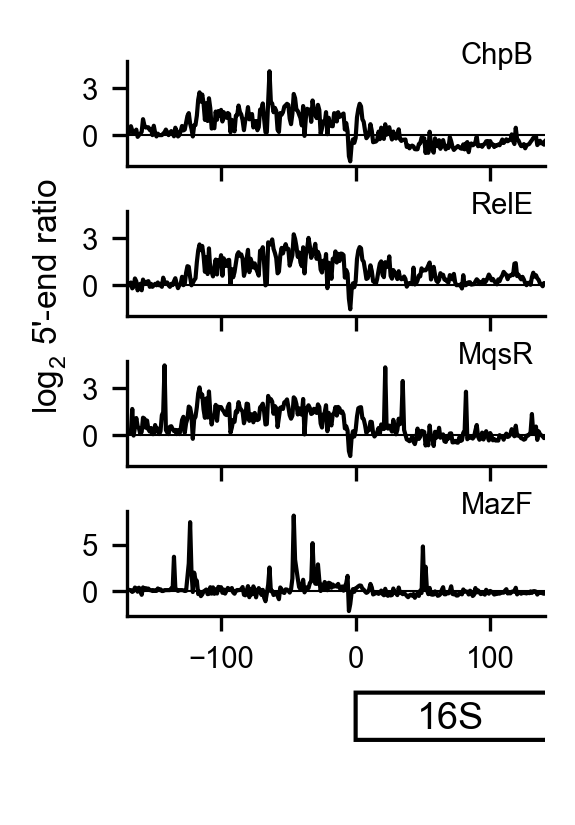

In [97]:
upstream, downstream = 170, -1400
gene_name = '16S'
gene_start = start_index
gene_end   = end_index

# make an alignment gene table
alignment_gene_table = pd.DataFrame(columns=['strand', 'start', 'end', 'plt_tag'],
                               data=[[0, gene_start, gene_end, gene_name]])
# prepare the genome window for plotting
window = gw.GenomeWindow(gene_table = alignment_gene_table, genome = '-'*len(no_gaps_index), gene_name_column='plt_tag', axes_heights = [.35,.35,.35,.35,.35], fig_width=1.8,)
# set position
window.setpositionbygene(name=gene_name, nt_5=upstream, nt_3=downstream)

for i in np.arange(len(title_list_30m)):
    empty_vector_arrays_30m = reindexed_arrays_30m[0]
    toxin_arrays_30m = reindexed_arrays_30m[i+1]

    
    window.plotdatastreams(axis_n = [i], input_data = [(np.mean(np.log2(toxin_arrays_30m),0) - np.mean(np.log2(empty_vector_arrays_30m),0))],
                           color = 'k', rasterize_data = False, stream_type = gw.ArrayAsLine, lw = 1, label=title_list_30m[i])
    # draw a line for each axis
    window.axesdata[i].axhline(0,0,1,c='k',lw=.5)
    
    # generate label text
    
    legend = window.axesdata[i].legend(bbox_to_anchor=(1, 1.3), loc='upper right',
                                         borderaxespad=0., fontsize=7, frameon=False, handlelength=0, labelcolor ='linecolor', markerscale=0)
# add labels
window.axesdata[2].set_ylabel("log$\mathdefault{_2}$ 5'-end ratio", labelpad=3, ha='left')
# rescale axes
limits = np.asarray([ax.get_ylim() for ax in window.axesdata[:-1]]).T
[ax.set_ylim(np.min(limits[0]),np.max(limits[1])) for ax in window.axesdata[:-1]]
[ax.set_yticks([0,3]) for ax in window.axesdata[:-1]]
# save figure
plt.savefig('figure_outputs/6C_16S_precursor_end.pdf',format='pdf',bbox_inches='tight')

## Figure 6D: rRNA profiles - 23S precursor region

In [98]:
from matplotlib.ticker import MultipleLocator,ScalarFormatter,FuncFormatter
from regex import search

def pullsequence(location, five, three, genome):
    strand, position = location
    if strand == 0:
        return str(genome.seq[position-five:position+three])
    if strand == 1:
        return str(genome.seq[position-three+1:position+five+1].reverse_complement())
    
def muscleAlign(names, sequences):
    # write a temporary fasta file for muscle to read / align
    writeFasta('_temp.fasta', names, sequences)
    # conduct a muscle alignment on the temporary fasta
    subprocess.call(['muscle','-in','_temp.fasta','-out','_temp_aligned.fasta'])
    # import alignments back into python
    names, sequences = readFasta('_temp_aligned.fasta',True)
    # clean up temporary file
    os.remove('_temp.fasta')
    return names, sequences

def writeFasta(filepath, names, sequences):
    # accepts list of names (spaces will be replaced with underscores) and list of sequences, writes to filepath
    with open(filepath,'w') as f:
        for n,seq in zip(names,sequences):
            f.write('>%s\n%s\n'%(n.replace(' ','_'),str(seq)))
    return filepath

def readFasta(filepath, delete=False):
    # returns names and records
    with open(filepath,'r') as f:
        lines = f.readlines()
        # now take out the records
        records = []
        names = []
        current_record = ''
        for line in lines:
            if line[0] == '>':
                names.append(line[1:-1])
                records.append(current_record)
                current_record = ''
            else:
                current_record += line[:-1]
        records.append(current_record)
        names = np.asarray(names)
        records = np.asarray(records[1:])
    if delete: # burn after reading
        os.remove(filepath)
    return names, records

def pullindexdata(target_indexes, alignment_mask, input_data, function = lambda x: x):
    return [function(input_data[alignment_mask == i]) for i in target_indexes]

def loadnormalizearbitraryarrays(target_folder, search_strings = None, verbose = True, normalization_mask = None, pseudo = True):
    # find numpy files in the target folder
    stdout, _ = quickshell('ls %s*.npy'%target_folder, print_output=False, return_output=True)
    all_numpy_files = stdout.split('\n')[:-1]
    # iterate through search strings of shape [[has1,has2,has3...],[not1,not2,not3...]]
    raw_arrays = []
    out_shape = []    
    for i,(has_strings, not_strings) in enumerate(search_strings):
        n = 0
        for file_path in all_numpy_files:
            file_name = file_path.split('/')[-1]
            if all([s.lower() in file_name.lower() for s in has_strings]) and all([s.lower() not in file_name.lower() for s in not_strings]):
                print('group %i: %s'%(i+1,file_name))
                raw_arrays.append(np.load(file_path))
                n+=1
        if n != 0:
            out_shape.append(n)
    # set empty normalization mask if none was given
    if normalization_mask is None:
        normalization_mask = np.zeros(raw_arrays[0].shape).astype(bool)
    # normalize arrays
    normalized_arrays = maskedcountnormalization(raw_arrays, normalization_mask, pseudo = pseudo)
    # reshape into output sets by slicing
    output_arrays = []
    for i in out_shape:
        output_arrays.append(normalized_arrays[:i])
        normalized_arrays = normalized_arrays[i:]
    return output_arrays

### plot selected data

In [99]:
upstream_nt = 75
downstream_nt = 75
gene_product = '23S ribosomal RNA'

# load the mg1655 genome
genbank_path = '/home/pculviner/notebook/genomes/mg1655_v3/Ec_mg1655v3.gb'
loaded_genbank = SeqIO.read(genbank_path,'genbank')
# load a gene table csv from the provided path
gene_table_path = '/home/pculviner/notebook/genomes/mg1655_v3/gt_mg1655_v3.csv'
gene_table = pd.read_csv(gene_table_path, index_col=0)

# pull tRNA sequences from the genome
trna_sequences = []
for strand,start,end in gene_table.loc[gene_table.loc[:,'product'] == gene_product, ['strand', 'start', 'end']].values:
    if strand == 0:
        trna_sequences.append(pullsequence([strand,start], upstream_nt, end-start+downstream_nt+1, loaded_genbank))
    if strand == 1:
        trna_sequences.append(pullsequence([strand,end], upstream_nt, end-start+downstream_nt+1, loaded_genbank))
# align the sequences
names, alignments = muscleAlign(gene_table.loc[gene_table.loc[:,'product'] == gene_product].gene.values, trna_sequences)

# convert the alignments into a character array
alignments_array = np.asarray([list(a) for a in alignments])
label_array = np.asarray(names)

## paint the alignment positions on the genome
# generate a mask with np.nan at every position
alignment_mask = np.zeros((2,len(loaded_genbank)))+np.nan
# generate an array index including every position in the alignment
global_array_index = np.arange(len(alignments_array[0]))
# generate a count of positions at each array index
global_array_index_counts = np.sum(alignments_array != '-',0)
# iterate across the alignments we've made
for gene,strand,start,end in gene_table.loc[gene_table.loc[:,'product'] == gene_product, ['gene', 'strand', 'start', 'end']].values:
    # pull gene from list of alignments          
    a_array = alignments_array[label_array == gene][0]
    # calculate indexes to paint onto genome
    indexes_to_paint = [i for i, base in enumerate(a_array) if base != '-']
    # paint this alignment onto the genome
    if strand == 0:
        alignment_mask[0,start-upstream_nt:end+1+downstream_nt] = indexes_to_paint
    elif strand == 1:
        alignment_mask[1,start-downstream_nt:end+1+upstream_nt] = indexes_to_paint[::-1]
        
## error checking ##
# # check alignment mask
# for i in global_array_index:
#     print('%i:%s'%(i,''.join([pullsequence(location, 0, 1, loaded_genbank) for location in np.asarray(np.where(alignment_mask == i)).T])))
####################

# identify all indexes with no gaps
no_gaps_index = global_array_index[global_array_index_counts == np.max(global_array_index_counts)]
# store start and end in alignment coordinates
reference_string = ''.join(alignments_array[0][no_gaps_index])
start_index = search('GGTTAAGCGAC', reference_string).span()[0]
end_index   = search('GGCTTAACCTT', reference_string).span()[1]-1

In [100]:
###### LOADING DATA #######
# function for moving from genome space to alignment space
reindexsamples = lambda sample_arrays, alignment_mask, target_indexes, function: [[pullindexdata(target_indexes, alignment_mask, replicate, function)
                                                                                   for replicate in sample_group] for sample_group in sample_arrays]

search_strings = [[['tot_30m','ev'],[]],
                  [['tot_30m','chpB'],[]],
                  [['tot_30m','relE'],[]],
                  [['tot_30m','mqsR'],[]],
                  [['tot_30m','mazF'],[]],]

title_list_30m = ['ChpB',
                  'RelE',
                  'MqsR',
                  'MazF',]

# load a set of sample arrays
loaded_arrays = loadnormalizearbitraryarrays('/home/pculviner/notebook/storage/rnaseq/PCe22_novaseq/ezpool_pipeline/five_prime_numpy_all/',
                                             search_strings = search_strings)
# reindex using reindexing function into alignment space
reindexed_arrays_30m = reindexsamples(loaded_arrays, alignment_mask, no_gaps_index, np.sum)

group 1: tot_30m-ev1.4.1.npy
group 1: tot_30m-ev2.4.13.npy
group 2: tot_30m-chpb1.4.4.npy
group 2: tot_30m-chpb2.4.16.npy
group 3: tot_30m-rele1.4.3.npy
group 3: tot_30m-rele2.4.15.npy
group 4: tot_30m-mqsr1.4.7.npy
group 4: tot_30m-mqsr2.4.19.npy
group 5: tot_30m-mazf1.4.2.npy
group 5: tot_30m-mazf2.4.14.npy


window zero at 66, window is not reversed: True


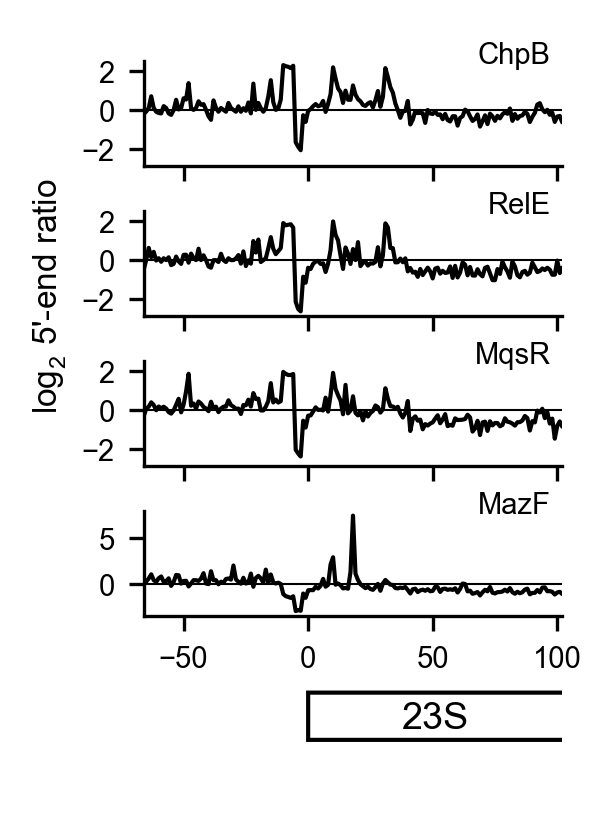

In [101]:
upstream, downstream = 75, -2800
gene_name = '23S'
gene_start = start_index
gene_end   = end_index


# make an alignment gene table
alignment_gene_table = pd.DataFrame(columns=['strand', 'start', 'end', 'plt_tag'],
                               data=[[0, gene_start, gene_end, gene_name]])
# prepare the genome window for plotting
window = gw.GenomeWindow(gene_table = alignment_gene_table, genome = '-'*len(no_gaps_index), gene_name_column='plt_tag', axes_heights = [.35,.35,.35,.35,.35], fig_width=1.8,)
# set position
window.setpositionbygene(name=gene_name, nt_5=upstream, nt_3=downstream)

for i in np.arange(len(title_list_30m)):
    empty_vector_arrays_30m = reindexed_arrays_30m[0]
    toxin_arrays_30m = reindexed_arrays_30m[i+1]

    
    window.plotdatastreams(axis_n = [i], input_data = [(np.mean(np.log2(toxin_arrays_30m),0) - np.mean(np.log2(empty_vector_arrays_30m),0))],
                           color = 'k', rasterize_data = False, stream_type = gw.ArrayAsLine, lw = 1, label=title_list_30m[i])
    # draw a line for each axis
    window.axesdata[i].axhline(0,0,1,c='k',lw=.5)
    
    # generate label text
    
    legend = window.axesdata[i].legend(bbox_to_anchor=(1, 1.3), loc='upper right',
                                         borderaxespad=0., fontsize=7, frameon=False, handlelength=0, labelcolor ='linecolor', markerscale=0)
# add labels
window.axesdata[2].set_ylabel("log$\mathdefault{_2}$ 5'-end ratio", labelpad=3, ha='left')
# rescale axes
limits = np.asarray([ax.get_ylim() for ax in window.axesdata[:-1]]).T
[ax.set_ylim(np.min(limits[0]),np.max(limits[1])) for ax in window.axesdata[:-1]]
[ax.set_yticks([-2,0,2]) for ax in window.axesdata[:-1]]
# save figure
plt.savefig('figure_outputs/S2B_23S_precursor_end.pdf',format='pdf',bbox_inches='tight')

## Figure 6E: ribosomal proteins

In [102]:
def moveaxis(ax, dx=0, dy=0):
    # where x and y are in inches on final figure
    fig = ax.get_figure()
    ax_coor = ax.get_position()
    dx = dx / fig.get_figwidth() # convert to figure coordinates
    dy = dy / fig.get_figheight() #  .5 = 2 1 # .25  = 2 .5
    ax.set_position([ax_coor.x0+dx, ax_coor.y0+dy, ax_coor.x1-ax_coor.x0, ax_coor.y1-ax_coor.y0])

def normalizebynonrrna(ctl_arrays, exp_arrays, rrna_margin, gene_table):
    # generate the rrna mask - these regions will not be included in the calculation of size factors for count normalization
    rrna_regions = gene_table.loc[gene_table.locus_type == 'rRNA',['strand', 'start', 'end']].values.astype(int)
    rrna_regions[:,1] = rrna_regions[:,1] - rrna_margin
    rrna_regions[:,2] = rrna_regions[:,2] + rrna_margin
    rrna_mask = ga.regionstomask(rrna_regions, len(loaded_genbank))
    # normalize the arrays by counts in the non-masked regions 
    normalized_arrays = maskedcountnormalization(np.r_[ctl_arrays,exp_arrays], rrna_mask, pseudo = True)
    # split the arrays back into control and experimental
    normalized_ctl_arrays = normalized_arrays[:len(ctl_arrays)]
    normalized_exp_arrays = normalized_arrays[len(ctl_arrays):]
    return normalized_ctl_arrays, normalized_exp_arrays

In [103]:
## INPUTS ##
toxin_list = ['MazF', 'ChpB', 'HicA', 'MqsR', 'RelE', 'YoeB', 'YhaV', 'HigB', 'YafO',]
rrna_margin = 100
exp_threshold = 6.

############
# load the mg1655 genome
genbank_path = '/home/pculviner/notebook/genomes/mg1655_v3/Ec_mg1655v3.gb'
loaded_genbank = SeqIO.read(genbank_path,'genbank')
# load a gene table csv from the provided path
gene_table_path = '/home/pculviner/notebook/genomes/mg1655_v3/gt_mg1655_v3.csv'
gene_table = pd.read_csv(gene_table_path, index_col=0)
# load r protein region extents
r_protein_names = ['rpsA','rpsB','rpsC','rpsD','rpsE','rpsF','rpsG','rpsH','rpsI','rpsJ','rpsK','rpsL','rpsM','rpsN',
                   'rpsO','rpsP','rpsQ','rpsR','rpsS','rpsT','rpsU','rplA','rplB','rplC','rplD','rplE','rplF',
                   'rplJ','rplL','rplI','rplK','rplM','rplN','rplO','rplP','rplQ','rplR','rplS','rplT','rplU','rplV',
                   'rplW','rplX','rplY','rpmA','rpmB','rpmC','rpmD','rpmE','rpmF','rpmG','rpmH','rpmI','rpmJ']
r_protein_regions = gene_table.loc[gene_table.gene.isin(r_protein_names),['strand','start','end']].values
# storage arrays for things that need be handled at the end
raw_cleavage_ratio   = []
for i,toxin_name in enumerate(toxin_list):
    print('%s: load data...'%toxin_name)
    # load density arrays
    density_ctl_arrays, density_exp_arrays = loadarrays('/home/pculviner/notebook/storage/rnaseq/PCe22_novaseq/ezpool_pipeline/density_numpy_all/',
                                                         control_has = ['rz','ev','frg'], control_not = ['trna',],
                                                         experimental_has = ['rz',toxin_name,'frg'], experimental_not = ['trna',], verbose = False)
    density_ctl_arrays, density_exp_arrays = normalizebynonrrna(density_ctl_arrays, density_exp_arrays, rrna_margin, gene_table)
    # calculate log2 averages
    avg_tswitch_ctl_density =  np.mean(np.log2(density_ctl_arrays),axis=0)
    avg_tswitch_cleavage_ratio = np.mean(np.log2(density_exp_arrays),axis=0) - np.mean(np.log2(density_ctl_arrays),axis=0)
    # mask the dataframe for positions below the threshold
    avg_tswitch_cleavage_ratio[avg_tswitch_ctl_density < exp_threshold] = np.nan
    # store maximum and minimum data
    raw_cleavage_ratio.append(ga.regionfunc(np.min, r_protein_regions, avg_tswitch_cleavage_ratio))
# input the data into a dataframe
r_protein_cleavage_ratios = pd.DataFrame(data = np.asarray(raw_cleavage_ratio).T, columns = toxin_list, index = r_protein_names)
# filter to remove any unexpressed r proteins
r_protein_cleavage_ratios = r_protein_cleavage_ratios.loc[~r_protein_cleavage_ratios.isnull().any(1)]
# sort the values lowest to highest
r_protein_cleavage_ratios_sorted = r_protein_cleavage_ratios.iloc[np.argsort(r_protein_cleavage_ratios.mean(1).values)]

MazF: load data...
ChpB: load data...
HicA: load data...
MqsR: load data...
RelE: load data...
YoeB: load data...
YhaV: load data...
HigB: load data...
YafO: load data...


In [104]:
# prepare colormap for minimum cleavage ratios
blue_black_yellow = sns.diverging_palette(65, 230, s=90, l=80, as_cmap=True, center="dark")
raw_vmin, raw_vmax = r_protein_cleavage_ratios.values.min(), r_protein_cleavage_ratios.values.max()

In [105]:
# prepare colormap for minimum cleavage ratios
blue_black_yellow = sns.diverging_palette(65, 230, s=90, l=80, as_cmap=True, center="dark")
raw_vmin, raw_vmax = -5, r_protein_cleavage_ratios.values.max()

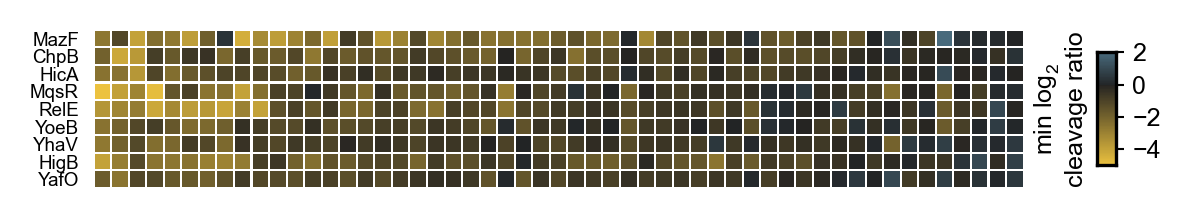

In [106]:
fig,ax = plt.subplots(1,figsize=(5,1))

# plot motif counts
sns.heatmap(data = r_protein_cleavage_ratios_sorted.transpose(), cmap=blue_black_yellow, vmin = raw_vmin, vmax=raw_vmax, center = 0,
            ax = ax, xticklabels=False, yticklabels=False, square = True, linewidth = .25, linecolor='w', cbar_kws={'shrink':.5, 'use_gridspec':False, 'aspect':6})

ax.set_yticks(np.arange(len(r_protein_cleavage_ratios_sorted.columns))+.5)
ax.tick_params(axis='both', which='both',length=0)
ax.set_yticklabels(r_protein_cleavage_ratios_sorted.columns,fontsize=4.5)

fig.axes[1].set_frame_on(True)
fig.axes[1].yaxis.set_major_locator(MultipleLocator(2))
fig.axes[1].tick_params(axis='y', which='both',length=2, width=.5, labelsize= 6, pad=2)
fig.axes[1].yaxis.set_label_position('left')
fig.axes[1].set_ylabel('min log$\mathregular{_2}$\ncleavage ratio',fontsize=6,labelpad=2)
moveaxis(fig.axes[1], dx=.05, dy=0)

plt.savefig('figure_outputs/6E_ribosomal_proteins.pdf',format='pdf',bbox_inches='tight')